In [ ]:
# Download the synced KITTI dataset
!curl -O https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0093/2011_09_26_drive_0093_sync.zip

In [ ]:
# Download the calibration (includes rigid body transformation matrices)
!curl -O https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

In [ ]:
# Extract files
!jar xf 2011_09_26_drive_0093_sync.zip
!jar xf 2011_09_26_calib.zip

In [1]:
# Data Overview

"""
In the KITTI raw dataset we get images from four cameras (two grayscale and two RGB), the velodyne LiDAR, and the OXTS GPS navigation system. 

The update rates are as follows:
- RGB camera: 15 Hz (15 fps)
- OXTS GPS navigation system: 100Hz
- Velodyne LiDAR: 10Hz 

The data is synched to the LiDAR, since it has the lowest update rate, but the sync between the camera, GPS/IMU (navigation), and LiDAR is not precise (even though we are using the synched raw data!).
"""

'\nIn the KITTI raw dataset we get images from four cameras (two grayscale and two RGB), the velodyne LiDAR, and the OXTS GPS navigation system. \n\nThe update rates are as follows:\n- RGB camera: 15 Hz (15 fps)\n- OXTS GPS navigation system: 100Hz\n- Velodyne LiDAR: 10Hz \n\nThe data is synched to the LiDAR, since it has the lowest update rate, but the sync between the camera, GPS/IMU (navigation), and LiDAR is not precise (even though we are using the synched raw data!).\n'

In [1]:
# Imports 
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Kitti Utility Functions
#!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
#!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_detection_utils.py
from kitti_utils import *
from kitti_detection_utils import *


In [2]:
# Load KITTI Dataset

"""
The camera images are stored in the following directories:

- 'image_00': Left rectified grayscale image sequence
- 'image_01': Right rectified grayscale image sequence
- 'image_02': Left rectified color image sequence
- 'image_03': Right rectified color image sequence
"""

# Load KITTI dataset 
DATA_PATH = r'2011_09_26/2011_09_26_drive_0093_sync'

# get RGB camera data (1382 x 512 pixels)
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 433
Number of right images: 433
Number of LiDAR point clouds: 433
Number of GPS/IMU frames: 433


In [3]:
# Load calibration data from KITTI's camera calibration file
with open('2011_09_26/calib_cam_to_cam.txt', 'r') as f:
    calib = f.readlines()

# Extract the projection matrix for Camera 2 (rectified left camera)
# This maps 3D points from the rectified left camera frame to 2D pixel coordinates (u, v, z).
P_rect_02 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3, 4))
# print(P_rect_02)

# Extract the rectification rotation matrix (R_rect_00), which aligns Camera 0 with the rectified stereo frame.
# This ensures all stereo images are aligned in a common rectified coordinate system.
R_rect_00 = np.eye(4)  # Initialize as a 4x4 identity matrix
R_rect_00[:3, :3] = np.array([float(x) for x in calib[8].strip().split(' ')[1:]]).reshape((3, 3))
# print(R_rect_00.shape)

# Load the rigid body transformation from LiDAR (Velodyne) to the reference camera (Camera 0)
T_velo_ref0 = get_rigid_transformation(r'2011_09_26/calib_velo_to_cam.txt')
# print(T_velo_ref0)

# Compute the transformation matrix from LiDAR (Velodyne) to Camera 2
# This combines the projection matrix, rectification matrix, and Velodyne-to-Camera 0 transformation.
# The resulting matrix transforms 3D LiDAR points into Camera 2’s coordinate frame.
T_velo_cam2 = P_rect_02 @ R_rect_00 @ T_velo_ref0
# print(T_velo_cam2)

# Load the rigid body transformation from IMU to LiDAR (Velodyne)
T_imu_velo = get_rigid_transformation(r'2011_09_26/calib_imu_to_velo.txt')

# Compute the transformation matrix from IMU to Camera 2
# This converts 3D points from the IMU coordinate system to Camera 2’s coordinate frame.
T_imu_cam2 = T_velo_cam2 @ T_imu_velo

# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2, 3, values=[0,0,0,1], axis=0)) 


In [4]:
import torch


from ultralytics import YOLO

# Load YOLOv11 model (modify path if needed)
model = YOLO('yolov11s.pt')  # You may need to download the weight file

# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25 # NMS IoU threshold (0-1), default: 0.45


0: 224x640 4 cars, 1 truck, 39.8ms
Speed: 1.6ms preprocess, 39.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)


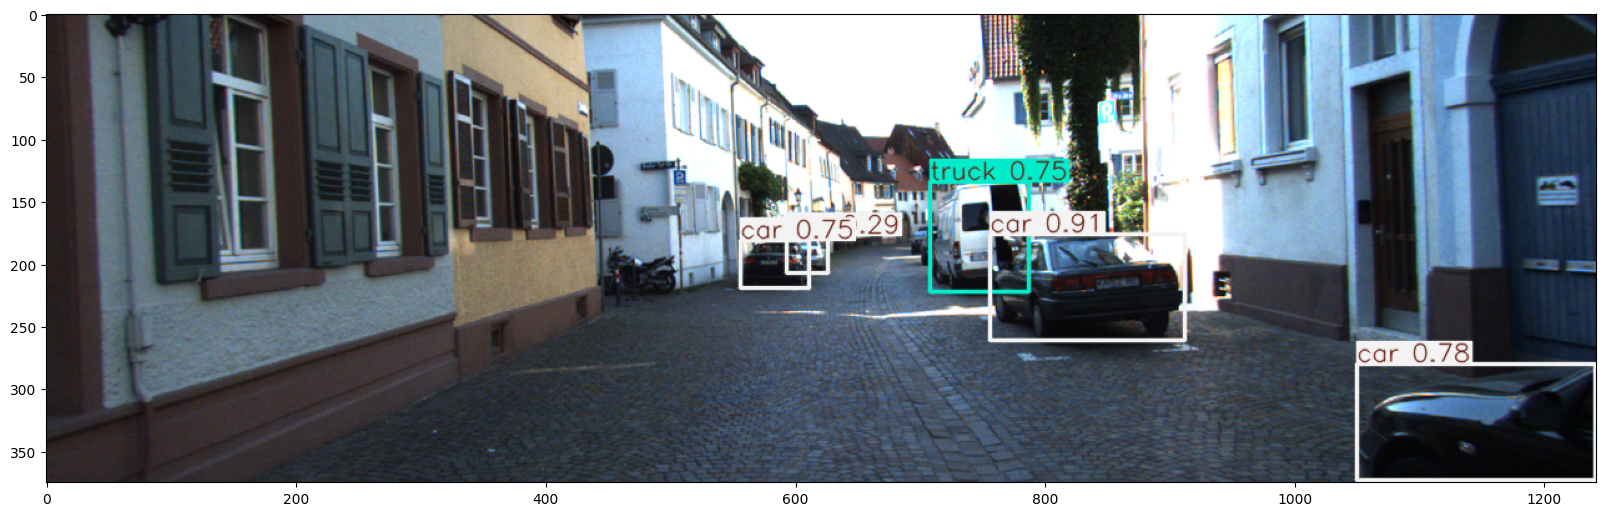

In [5]:
index = 10

# Converts the loaded BGR image to RGB format
left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)

# Loads Lidar points for this image
bin_path = bin_paths[index]

# Loads IMU data for this image
oxts_frame = get_oxts(oxts_paths[index])

# Get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path, model, T_velo_cam2)

# Get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# Transform to (u,v,z)
# velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordinates
imu_xyz = transform_uvz(uvz, T_cam2_imu)

# Get Lat/Lon on each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

In [6]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

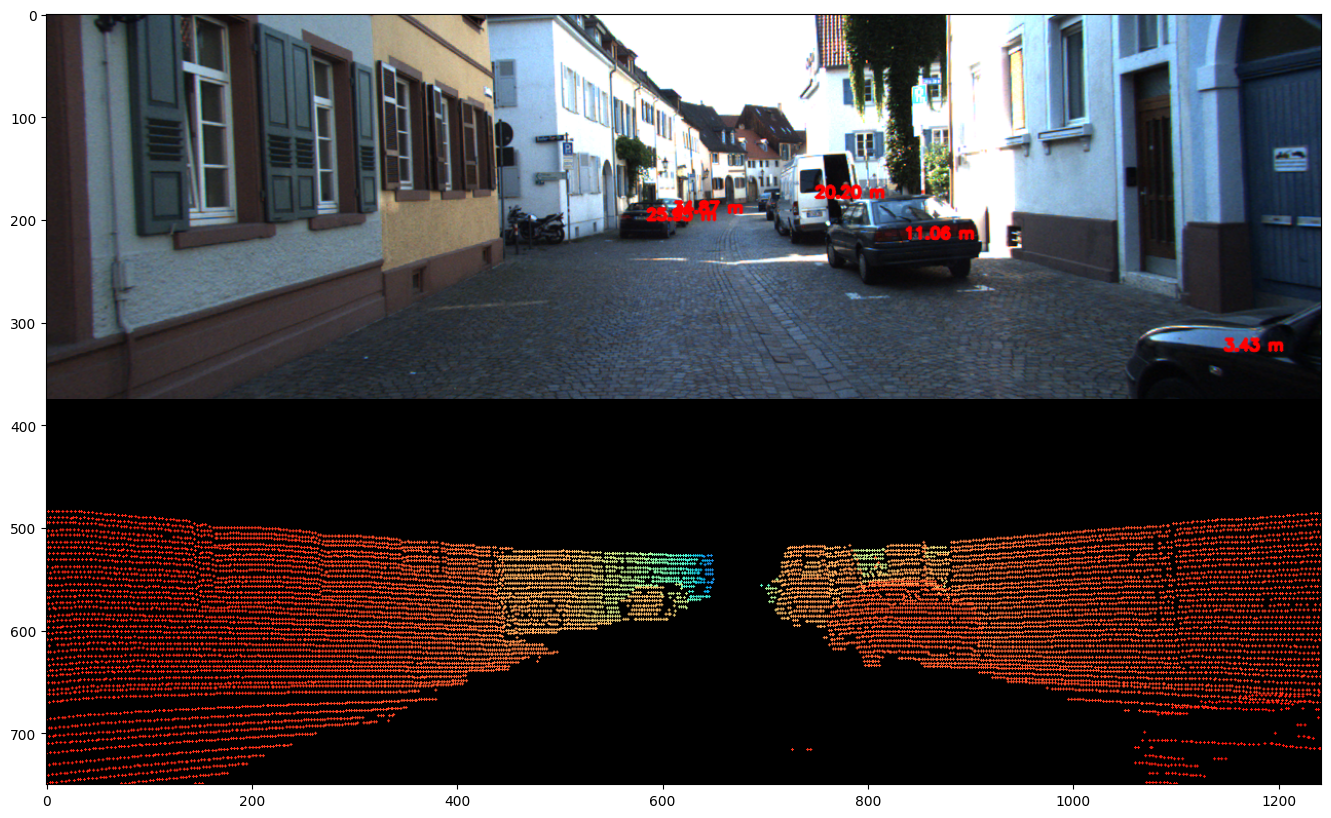

In [7]:
# pymap3d seems to mess with matplotlib in colab
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

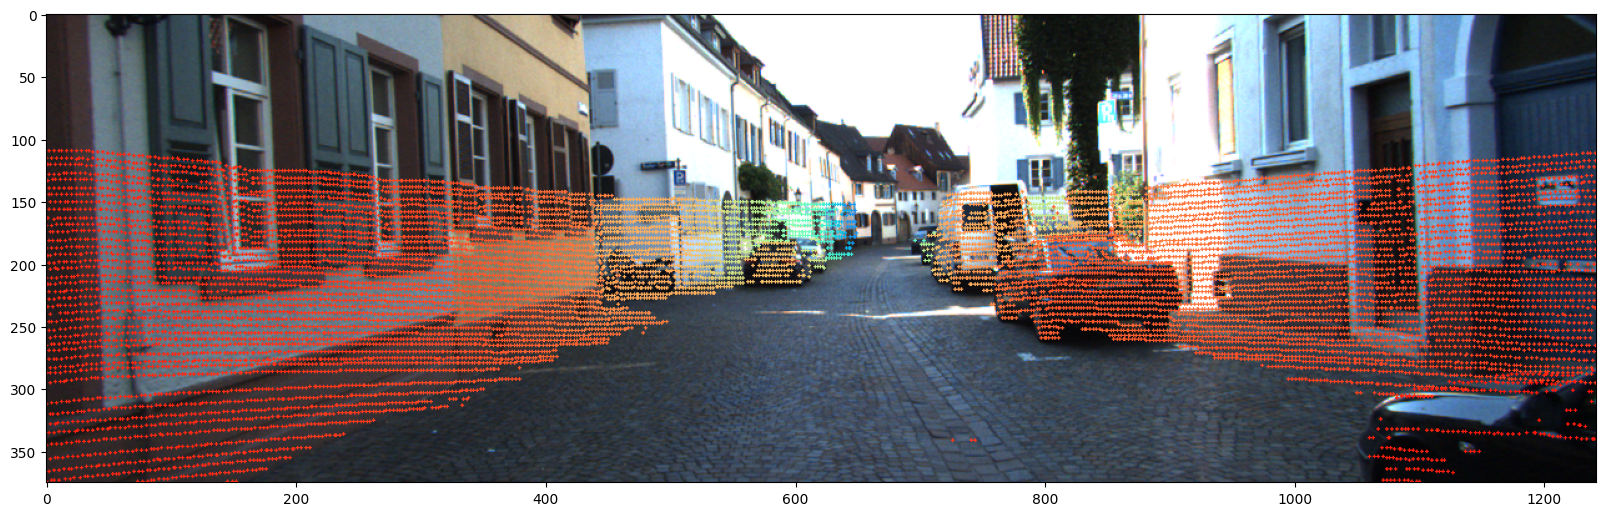

In [8]:
left_image_2 = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
velo_image_2 = draw_velo_on_image(velo_uvz, left_image_2)

plt.imshow(velo_image_2);

In [9]:
(uvz[:, 2] + 1.08) - imu_xyz[:, 0]

array([ -0.0092375,  -0.0094205,  -0.0051841,  -0.0072308,  -0.0062358])

In [10]:
get_total_seconds = lambda hms: hms[0]*60*60 + hms[1]*60 + hms[2]


def timestamps2seconds(timestamp_path):
    ''' Reads in timestamp path and returns total seconds (does not account for day rollover '''
    
    timestamps = pd.read_csv(timestamp_path, header=None).iloc[:, 0] \
              .astype(str).apply(lambda x: x.split(' ')[1])

    # Get Hours, Minutes, and Seconds
    hours = timestamps.apply(lambda x: x.split(':')[0]).astype(np.float64)
    minutes = timestamps.apply(lambda x: x.split(':')[1]).astype(np.float64)
    seconds = timestamps.apply(lambda x: x.split(':')[2]).astype(np.float64)

    hms_vals = np.vstack((hours, minutes, seconds)).T
    
    total_seconds = np.array(list(map(get_total_seconds, hms_vals)))
    
    return total_seconds

In [11]:
cam2_total_seconds = timestamps2seconds(os.path.join(DATA_PATH, r'image_02/timestamps.txt'))

In [12]:
# camera 2 frames per second
cam2_fps = 1/np.median(np.diff(cam2_total_seconds))
cam2_fps

9.661068090117853

In [13]:
canvas_height = stacked.shape[0]
canvas_width = 500

# get consistent center for ego vehicle
ego_center = (250, int(canvas_height*0.95))

# get rectangle coordiantes for ego vehicle
ego_x1 = ego_center[0] - 5
ego_y1 = ego_center[1] - 10
ego_x2 = ego_center[0] + 5
ego_y2 = ego_center[1] + 10

def draw_scenario(canvas, imu_xyz, sf=12):
    # draw ego vehicle
    cv2.rectangle(canvas, (ego_x1, ego_y1), (ego_x2, ego_y2), (0, 255, 0), -1);

    # draw detected objects
    for val in imu_xyz:
        obj_center = (ego_center[0] - sf*int(np.round(val[1])),
                      ego_center[1] - sf*int(np.round(val[0])))
        # cv2.circle(canvas, obj_center, 5, (255, 0, 0), -1);

        # get object rectangle coordinates
        obj_x1 = obj_center[0] - 5
        obj_y1 = obj_center[1] - 10
        obj_x2 = obj_center[0] + 5
        obj_y2 = obj_center[1] + 10

        cv2.rectangle(canvas, (obj_x1, obj_y1), (obj_x2, obj_y2), (255, 0, 0), -1);


    return canvas

In [15]:
# Dictionary to store tracked objects with velocity and acceleration

tracking_data = {}

for index in range(len(left_image_paths) - 1): 
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
    bin_path = bin_paths[index]
    oxts_frame = get_oxts(oxts_paths[index])

    # get detections and object centers in uvz
    bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path, model, T_velo_cam2, False, False)

    # Time difference between current and next frame
    # dt = cam2_total_seconds[index + 1] - cam2_total_seconds[index]  # Time difference (in seconds)

    get_kitti_tracking_csv(bboxes, index, cam2_total_seconds, tracking_data, T_cam2_imu)



0: 224x640 4 cars, 1 truck, 49.6ms
Speed: 1.8ms preprocess, 49.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z  vx  vy  vz  ax  ay  \
0        243  55113.010594   8.022420 -3.114352  0.109314   0   0   0   0   0   
1        272  55113.010594   6.734644  4.136993 -0.039192   0   0   0   0   0   
2        200  55113.010594  18.565805 -3.967666  0.261965   0   0   0   0   0   
3        193  55113.010594  33.588222  0.294470  0.133005   0   0   0   0   0   
4        172  55113.010594  27.818062 -4.405476  0.971299   0   0   0   0   0   

   az  
0   0  
1   0  
2   0  
3   0  
4   0


0: 224x640 4 cars, 2 trucks, 1 backpack, 235.2ms
Speed: 6.0ms preprocess, 235.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
4         193  55113.010594  33.588222  0.294470  0.133005  0.000000   
5         193  55113.114112  32.968735  0.236141  0.100419 -5.985100   
6         172  55113.010594  27.818062 -4.405476  0.971299  0.000000   
7         172  55113.114112  27.169420 -4.358295  0.927025 -6.266772   
8         250  55113.114112   7.372388 -3.068359  0.103409  0.000000   
9         184  55113.114112  33.900787  0.132445  0.332400  0.000000   
10        167  55113.114112  31.454285  3.138753  1.155881  0.000000   
11        287  55113.114112   6.451338  4.145207 -0.092384  0.000000   

          vy        vz  ax  ay  az  
0   0.000000  0.000000   0   0   0  
1   0.000000  0.000000   0   0   0  
2   0.000000  0.000000   0   0   0  
3   0.048915 -0.274561   0   0   0  
4   0.000000  0.000000   0   0   0  
5  -0.563544 -0.314824   0   0   0  
6   0.000000  0.000000   0   0   0  
7   0.455838 -0.427748   0   0   0  
8   0.000000  0.000000   0   0   0  
9   0.000000  0.000000   0   0   0  
10  0.000000  0.000000   0   0   0  
11  0.000000  0.000000   0   0   0


0: 224x640 4 cars, 1 truck, 238.2ms
Speed: 9.6ms preprocess, 238.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
4         193  55113.010594  33.588222  0.294470  0.133005  0.000000   
5         193  55113.114112  32.968735  0.236141  0.100419 -5.985100   
6         172  55113.010594  27.818062 -4.405476  0.971299  0.000000   
7         172  55113.114112  27.169420 -4.358295  0.927025 -6.266772   
8         250  55113.114112   7.372388 -3.068359  0.103409  0.000000   
9         184  55113.114112  33.900787  0.132445  0.332400  0.000000   
10        167  55113.114112  31.454285  3.138753  1.155881  0.000000   
11        287  55113.114112   6.451338  4.145207 -0.092384  0.000000   
12        260  55113.217617   6.775163 -3.059867  0.104328  0.000000   
13        199  55113.217617  17.245547 -3.923726  0.242250  0.000000   
14        197  55113.217617  32.188907  0.493769 -0.034492  0.000000   
15        177  55113.217617  26.480087 -4.299368  0.877098  0.000000   
16        190  55113.217617  41.123719 -0.562331  0.164732  0.000000   

          vy        vz  ax  ay  az  
0   0.000000  0.000000   0   0   0  
1   0.000000  0.000000   0   0   0  
2   0.000000  0.000000   0   0   0  
3   0.048915 -0.274561   0   0   0  
4   0.000000  0.000000   0   0   0  
5  -0.563544 -0.314824   0   0   0  
6   0.000000  0.000000   0   0   0  
7   0.455838 -0.427748   0   0   0  
8   0.000000  0.000000   0   0   0  
9   0.000000  0.000000   0   0   0  
10  0.000000  0.000000   0   0   0  
11  0.000000  0.000000   0   0   0  
12  0.000000  0.000000   0   0   0  
13  0.000000  0.000000   0   0   0  
14  0.000000  0.000000   0   0   0  
15  0.000000  0.000000   0   0   0  
16  0.000000  0.000000   0   0   0


0: 224x640 3 cars, 1 truck, 267.9ms
Speed: 5.1ms preprocess, 267.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
4         193  55113.010594  33.588222  0.294470  0.133005  0.000000   
5         193  55113.114112  32.968735  0.236141  0.100419 -5.985100   
6         172  55113.010594  27.818062 -4.405476  0.971299  0.000000   
7         172  55113.114112  27.169420 -4.358295  0.927025 -6.266772   
8         250  55113.114112   7.372388 -3.068359  0.103409  0.000000   
9         184  55113.114112  33.900787  0.132445  0.332400  0.000000   
10        167  55113.114112  31.454285  3.138753  1.155881  0.000000   
11        287  55113.114112   6.451338  4.145207 -0.092384  0.000000   
12        260  55113.217617   6.775163 -3.059867  0.104328  0.000000   
13        199  55113.217617  17.245547 -3.923726  0.242250  0.000000   
14        197  55113.217617  32.188907  0.493769 -0.034492  0.000000   
15        197  55113.321111  31.586200  0.388613 -0.033097 -5.815506   
16        177  55113.217617  26.480087 -4.299368  0.877098  0.000000   
17        190  55113.217617  41.123719 -0.562331  0.164732  0.000000   
18        268  55113.321111   6.119343 -3.017939  0.099731  0.000000   
19        203  55113.321111  16.613053 -3.875723  0.216489  0.000000   
20        176  55113.321111  25.810561 -4.290819  0.826556  0.000000   

          vy        vz  ax  ay  az  
0   0.000000  0.000000   0   0   0  
1   0.000000  0.000000   0   0   0  
2   0.000000  0.000000   0   0   0  
3   0.048915 -0.274561   0   0   0  
4   0.000000  0.000000   0   0   0  
5  -0.563544 -0.314824   0   0   0  
6   0.000000  0.000000   0   0   0  
7   0.455838 -0.427748   0   0   0  
8   0.000000  0.000000   0   0   0  
9   0.000000  0.000000   0   0   0  
10  0.000000  0.000000   0   0   0  
11  0.000000  0.000000   0   0   0  
12  0.000000  0.000000   0   0   0  
13  0.000000  0.000000   0   0   0  
14  0.000000  0.000000   0   0   0  
15 -1.014649  0.013459   0   0   0  
16  0.000000  0.000000   0   0   0  
17  0.000000  0.000000   0   0   0  
18  0.000000  0.000000   0   0   0  
19  0.000000  0.000000   0   0   0  
20  0.000000  0.000000   0   0   0


0: 224x640 3 cars, 1 truck, 240.4ms
Speed: 4.5ms preprocess, 240.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
4         193  55113.010594  33.588222  0.294470  0.133005  0.000000   
5         193  55113.114112  32.968735  0.236141  0.100419 -5.985100   
6         172  55113.010594  27.818062 -4.405476  0.971299  0.000000   
7         172  55113.114112  27.169420 -4.358295  0.927025 -6.266772   
8         250  55113.114112   7.372388 -3.068359  0.103409  0.000000   
9         184  55113.114112  33.900787  0.132445  0.332400  0.000000   
10        167  55113.114112  31.454285  3.138753  1.155881  0.000000   
11        287  55113.114112   6.451338  4.145207 -0.092384  0.000000   
12        260  55113.217617   6.775163 -3.059867  0.104328  0.000000   
13        199  55113.217617  17.245547 -3.923726  0.242250  0.000000   
14        197  55113.217617  32.188907  0.493769 -0.034492  0.000000   
15        197  55113.321111  31.586200  0.388613 -0.033097 -5.815506   
16        197  55113.424749  30.927051  0.381243  0.013410 -6.368200   
17        177  55113.217617  26.480087 -4.299368  0.877098  0.000000   
18        190  55113.217617  41.123719 -0.562331  0.164732  0.000000   
19        268  55113.321111   6.119343 -3.017939  0.099731  0.000000   
20        203  55113.321111  16.613053 -3.875723  0.216489  0.000000   
21        203  55113.424749  15.988487 -3.843098  0.200987 -6.034092   
22        176  55113.321111  25.810561 -4.290819  0.826556  0.000000   
23        176  55113.424749  25.168457 -4.263744  0.844163 -6.203533   
24        266  55113.424749   5.520648 -2.900971  0.162604  0.000000   

          vy        vz        ax        ay        az  
0   0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.048915 -0.274561  0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  0.000000  0.000000  
5  -0.563544 -0.314824  0.000000  0.000000  0.000000  
6   0.000000  0.000000  0.000000  0.000000  0.000000  
7   0.455838 -0.427748  0.000000  0.000000  0.000000  
8   0.000000  0.000000  0.000000  0.000000  0.000000  
9   0.000000  0.000000  0.000000  0.000000  0.000000  
10  0.000000  0.000000  0.000000  0.000000  0.000000  
11  0.000000  0.000000  0.000000  0.000000  0.000000  
12  0.000000  0.000000  0.000000  0.000000  0.000000  
13  0.000000  0.000000  0.000000  0.000000  0.000000  
14  0.000000  0.000000  0.000000  0.000000  0.000000  
15 -1.014649  0.013459  0.000000  0.000000  0.000000  
16 -0.071203  0.449318 -5.339714  9.114878  4.210942  
17  0.000000  0.000000  0.000000  0.000000  0.000000  
18  0.000000  0.000000  0.000000  0.000000  0.000000  
19  0.000000  0.000000  0.000000  0.000000  0.000000  
20  0.000000  0.000000  0.000000  0.000000  0.000000  
21  0.315199 -0.149770  0.000000  0.000000  0.000000  
22  0.000000  0.000000  0.000000  0.000000  0.000000  
23  0.261578  0.170103  0.000000  0.000000  0.000000  
24  0.000000  0.000000  0.000000  0.000000  0.000000


0: 224x640 3 cars, 1 truck, 269.1ms
Speed: 4.0ms preprocess, 269.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
4         193  55113.010594  33.588222  0.294470  0.133005  0.000000   
5         193  55113.114112  32.968735  0.236141  0.100419 -5.985100   
6         172  55113.010594  27.818062 -4.405476  0.971299  0.000000   
7         172  55113.114112  27.169420 -4.358295  0.927025 -6.266772   
8         250  55113.114112   7.372388 -3.068359  0.103409  0.000000   
9         184  55113.114112  33.900787  0.132445  0.332400  0.000000   
10        167  55113.114112  31.454285  3.138753  1.155881  0.000000   
11        287  55113.114112   6.451338  4.145207 -0.092384  0.000000   
12        260  55113.217617   6.775163 -3.059867  0.104328  0.000000   
13        199  55113.217617  17.245547 -3.923726  0.242250  0.000000   
14        197  55113.217617  32.188907  0.493769 -0.034492  0.000000   
15        197  55113.321111  31.586200  0.388613 -0.033097 -5.815506   
16        197  55113.424749  30.927051  0.381243  0.013410 -6.368200   
17        197  55113.528255  30.245785  0.442575  0.067615 -6.581229   
18        177  55113.217617  26.480087 -4.299368  0.877098  0.000000   
19        190  55113.217617  41.123719 -0.562331  0.164732  0.000000   
20        268  55113.321111   6.119343 -3.017939  0.099731  0.000000   
21        203  55113.321111  16.613053 -3.875723  0.216489  0.000000   
22        203  55113.424749  15.988487 -3.843098  0.200987 -6.034092   
23        176  55113.321111  25.810561 -4.290819  0.826556  0.000000   
24        176  55113.424749  25.168457 -4.263744  0.844163 -6.203533   
25        176  55113.528255  24.512661 -4.241751  0.826638 -6.335179   
26        266  55113.424749   5.520648 -2.900971  0.162604  0.000000   
27        280  55113.528255   5.116863 -2.718861  0.200199  0.000000   
28        207  55113.528255  15.314169 -3.807491  0.159495  0.000000   

          vy        vz        ax        ay        az  
0   0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.048915 -0.274561  0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  0.000000  0.000000  
5  -0.563544 -0.314824  0.000000  0.000000  0.000000  
6   0.000000  0.000000  0.000000  0.000000  0.000000  
7   0.455838 -0.427748  0.000000  0.000000  0.000000  
8   0.000000  0.000000  0.000000  0.000000  0.000000  
9   0.000000  0.000000  0.000000  0.000000  0.000000  
10  0.000000  0.000000  0.000000  0.000000  0.000000  
11  0.000000  0.000000  0.000000  0.000000  0.000000  
12  0.000000  0.000000  0.000000  0.000000  0.000000  
13  0.000000  0.000000  0.000000  0.000000  0.000000  
14  0.000000  0.000000  0.000000  0.000000  0.000000  
15 -1.014649  0.013459  0.000000  0.000000  0.000000  
16 -0.071203  0.449318 -5.339714  9.114878  4.210942  
17  0.592487  0.523636 -2.057917  6.411433  0.717931  
18  0.000000  0.000000  0.000000  0.000000  0.000000  
19  0.000000  0.000000  0.000000  0.000000  0.000000  
20  0.000000  0.000000  0.000000  0.000000  0.000000  
21  0.000000  0.000000  0.000000  0.000000  0.000000  
22  0.315199 -0.149770  0.000000  0.000000  0.000000  
23  0.000000  0.000000  0.000000  0.000000  0.000000  
24  0.261578  0.170103  0.000000  0.000000  0.000000  
25  0.212464 -0.169297 -1.271734 -0.474452 -3.278693  
26  0.000000  0.000000  0.000000  0.000000  0.000000  
27  0.000000  0.000000  0.000000  0.000000  0.000000  
28  0.000000  0.000000  0.000000  0.000000  0.000000


0: 224x640 4 cars, 1 truck, 252.6ms
Speed: 2.1ms preprocess, 252.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
4         193  55113.010594  33.588222  0.294470  0.133005  0.000000   
5         193  55113.114112  32.968735  0.236141  0.100419 -5.985100   
6         172  55113.010594  27.818062 -4.405476  0.971299  0.000000   
7         172  55113.114112  27.169420 -4.358295  0.927025 -6.266772   
8         250  55113.114112   7.372388 -3.068359  0.103409  0.000000   
9         184  55113.114112  33.900787  0.132445  0.332400  0.000000   
10        167  55113.114112  31.454285  3.138753  1.155881  0.000000   
11        287  55113.114112   6.451338  4.145207 -0.092384  0.000000   
12        260  55113.217617   6.775163 -3.059867  0.104328  0.000000   
13        199  55113.217617  17.245547 -3.923726  0.242250  0.000000   
14        197  55113.217617  32.188907  0.493769 -0.034492  0.000000   
15        197  55113.321111  31.586200  0.388613 -0.033097 -5.815506   
16        197  55113.424749  30.927051  0.381243  0.013410 -6.368200   
17        197  55113.528255  30.245785  0.442575  0.067615 -6.581229   
18        177  55113.217617  26.480087 -4.299368  0.877098  0.000000   
19        190  55113.217617  41.123719 -0.562331  0.164732  0.000000   
20        268  55113.321111   6.119343 -3.017939  0.099731  0.000000   
21        203  55113.321111  16.613053 -3.875723  0.216489  0.000000   
22        203  55113.424749  15.988487 -3.843098  0.200987 -6.034092   
23        176  55113.321111  25.810561 -4.290819  0.826556  0.000000   
24        176  55113.424749  25.168457 -4.263744  0.844163 -6.203533   
25        176  55113.528255  24.512661 -4.241751  0.826638 -6.335179   
26        176  55113.631772  23.858552 -4.224278  0.844579 -6.319687   
27        266  55113.424749   5.520648 -2.900971  0.162604  0.000000   
28        280  55113.528255   5.116863 -2.718861  0.200199  0.000000   
29        280  55113.631772   4.996057 -2.710980  0.197672 -1.167173   
30        207  55113.528255  15.314169 -3.807491  0.159495  0.000000   
31        206  55113.631772  14.658223 -3.781662  0.197965  0.000000   
32        196  55113.631772  29.587189  0.289387  0.063630  0.000000   
33        196  55113.631772  29.613558 -0.006834  0.169210  0.254759   

          vy        vz        ax        ay        az  
0   0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.048915 -0.274561  0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  0.000000  0.000000  
5  -0.563544 -0.314824  0.000000  0.000000  0.000000  
6   0.000000  0.000000  0.000000  0.000000  0.000000  
7   0.455838 -0.427748  0.000000  0.000000  0.000000  
8   0.000000  0.000000  0.000000  0.000000  0.000000  
9   0.000000  0.000000  0.000000  0.000000  0.000000  
10  0.000000  0.000000  0.000000  0.000000  0.000000  
11  0.000000  0.000000  0.000000  0.000000  0.000000  
12  0.000000  0.000000  0.000000  0.000000  0.000000  
13  0.000000  0.000000  0.000000  0.000000  0.000000  
14  0.000000  0.000000  0.000000  0.000000  0.000000  
15 -1.014649  0.013459  0.000000  0.000000  0.000000  
16 -0.071203  0.449318 -5.339714  9.114878  4.210942  
17  0.592487  0.523636 -2.057917  6.411433  0.717931  
18  0.000000  0.000000  0.000000  0.000000  0.000000  
19  0.000000  0.000000  0.000000  0.000000  0.000000  
20  0.000000  0.000000  0.000000  0.000000  0.000000  
21  0.000000  0.000000  0.000000  0.000000  0.000000  
22  0.315199 -0.149770  0.000000  0.000000  0.000000  
23  0.000000  0.000000  0.000000  0.000000  0.000000  
24  0.261578  0.170103  0.000000  0.000000  0.000000  
25  0.212464 -0.169297 -1.271734 -0.474452 -3.278693 


0: 224x640 4 cars, 1 truck, 104.4ms
Speed: 28.7ms preprocess, 104.4ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
4         193  55113.010594  33.588222  0.294470  0.133005   0.000000   
5         193  55113.114112  32.968735  0.236141  0.100419  -5.985100   
6         193  55113.735276  37.798250 -0.435837  0.062945  46.662201   
7         172  55113.010594  27.818062 -4.405476  0.971299   0.000000   
8         172  55113.114112  27.169420 -4.358295  0.927025  -6.266772   
9         250  55113.114112   7.372388 -3.068359  0.103409   0.000000   
10        184  55113.114112  33.900787  0.132445  0.332400   0.000000   
11        167  55113.114112  31.454285  3.138753  1.155881   0.000000   
12        287  55113.114112   6.451338  4.145207 -0.092384   0.000000   
13        260  55113.217617   6.775163 -3.059867  0.104328   0.000000   
14        199  55113.217617  17.245547 -3.923726  0.242250   0.000000   
15        197  55113.217617  32.188907  0.493769 -0.034492   0.000000   
16        197  55113.321111  31.586200  0.388613 -0.033097  -5.815506   
17        197  55113.424749  30.927051  0.381243  0.013410  -6.368200   
18        197  55113.528255  30.245785  0.442575  0.067615  -6.581229   
19        177  55113.217617  26.480087 -4.299368  0.877098   0.000000   
20        190  55113.217617  41.123719 -0.562331  0.164732   0.000000   
21        268  55113.321111   6.119343 -3.017939  0.099731   0.000000   
22        203  55113.321111  16.613053 -3.875723  0.216489   0.000000   
23        203  55113.424749  15.988487 -3.843098  0.200987  -6.034092   
24        176  55113.321111  25.810561 -4.290819  0.826556   0.000000   
25        176  55113.424749  25.168457 -4.263744  0.844163  -6.203533   
26        176  55113.528255  24.512661 -4.241751  0.826638  -6.335179   
27        176  55113.631772  23.858552 -4.224278  0.844579  -6.319687   
28        266  55113.424749   5.520648 -2.900971  0.162604   0.000000   
29        280  55113.528255   5.116863 -2.718861  0.200199   0.000000   
30        280  55113.631772   4.996057 -2.710980  0.197672  -1.167173   
31        207  55113.528255  15.314169 -3.807491  0.159495   0.000000   
32        206  55113.631772  14.658223 -3.781662  0.197965   0.000000   
33        196  55113.631772  29.587189  0.289387  0.063630   0.000000   
34        196  55113.631772  29.613558 -0.006834  0.169210   0.254759   
35        196  55113.735276  28.988122  0.582201 -0.054388  -6.042885   
36        281  55113.735276   4.959904 -2.765170  0.223091   0.000000   
37        210  55113.735276  14.023744 -3.765369  0.207786   0.000000   
38        175  55113.735276  23.234927 -4.164189  0.801753   0.000000   

          vy        vz          ax         ay         az  
0   0.000000  0.000000    0.000000   0.000000   0.000000  
1   0.000000  0.000000    0.000000   0.000000   0.000000  
2   0.000000  0.000000    0.000000   0.000000   0.000000  
3   0.048915 -0.274561    0.000000   0.000000   0.000000  
4   0.000000  0.000000    0.000000   0.000000   0.000000  
5  -0.563544 -0.314824    0.000000   0.000000   0.000000  
6  -6.492564 -0.362075  508.671928 -57.285479  -0.456533  
7   0.000000  0.000000    0.000000   0.000000   0.000000  
8   0.455838 -0.427748    0.000000   0.000000   0.000000  
9   0.000000  0.000000    0.000000   0.000000   0.000000  
10  0.000000  0.000000    0.000000   0.000000   0.000000  
11  0.000000  0.000000    0.000000   0.000000   0.000000  
12  0.000000  0.000000    0.000000   0.000000   0.000000  
13  0.000000  0.000000    0.000000   0.000000   0.000000  
14  0.000000  0.000000    0.000000   0.000000   0.000000  
15  0.000000  0.000000    0.000000   0.000000   0.000000  
16 -1.014649  0.013459    0.000000   0.000000   0.000000  
17 -0.071203  0.44931


0: 224x640 4 cars, 1 truck, 246.5ms
Speed: 19.2ms preprocess, 246.5ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
4         193  55113.010594  33.588222  0.294470  0.133005   0.000000   
5         193  55113.114112  32.968735  0.236141  0.100419  -5.985100   
6         193  55113.735276  37.798250 -0.435837  0.062945  46.662201   
7         193  55113.838775  37.216334 -0.407009  0.069352  -5.622061   
8         172  55113.010594  27.818062 -4.405476  0.971299   0.000000   
9         172  55113.114112  27.169420 -4.358295  0.927025  -6.266772   
10        250  55113.114112   7.372388 -3.068359  0.103409   0.000000   
11        184  55113.114112  33.900787  0.132445  0.332400   0.000000   
12        167  55113.114112  31.454285  3.138753  1.155881   0.000000   
13        287  55113.114112   6.451338  4.145207 -0.092384   0.000000   
14        260  55113.217617   6.775163 -3.059867  0.104328   0.000000   
15        199  55113.217617  17.245547 -3.923726  0.242250   0.000000   
16        197  55113.217617  32.188907  0.493769 -0.034492   0.000000   
17        197  55113.321111  31.586200  0.388613 -0.033097  -5.815506   
18        197  55113.424749  30.927051  0.381243  0.013410  -6.368200   
19        197  55113.528255  30.245785  0.442575  0.067615  -6.581229   
20        177  55113.217617  26.480087 -4.299368  0.877098   0.000000   
21        190  55113.217617  41.123719 -0.562331  0.164732   0.000000   
22        268  55113.321111   6.119343 -3.017939  0.099731   0.000000   
23        203  55113.321111  16.613053 -3.875723  0.216489   0.000000   
24        203  55113.424749  15.988487 -3.843098  0.200987  -6.034092   
25        176  55113.321111  25.810561 -4.290819  0.826556   0.000000   
26        176  55113.424749  25.168457 -4.263744  0.844163  -6.203533   
27        176  55113.528255  24.512661 -4.241751  0.826638  -6.335179   
28        176  55113.631772  23.858552 -4.224278  0.844579  -6.319687   
29        266  55113.424749   5.520648 -2.900971  0.162604   0.000000   
30        280  55113.528255   5.116863 -2.718861  0.200199   0.000000   
31        280  55113.631772   4.996057 -2.710980  0.197672  -1.167173   
32        207  55113.528255  15.314169 -3.807491  0.159495   0.000000   
33        206  55113.631772  14.658223 -3.781662  0.197965   0.000000   
34        196  55113.631772  29.587189  0.289387  0.063630   0.000000   
35        196  55113.631772  29.613558 -0.006834  0.169210   0.254759   
36        196  55113.735276  28.988122  0.582201 -0.054388  -6.042885   
37        281  55113.735276   4.959904 -2.765170  0.223091   0.000000   
38        210  55113.735276  14.023744 -3.765369  0.207786   0.000000   
39        175  55113.735276  23.234927 -4.164189  0.801753   0.000000   
40        290  55113.838775   4.852684 -2.788215  0.208337   0.000000   
41        214  55113.838775  13.381616 -3.741493  0.156960   0.000000   
42        201  55113.838775  28.345833  0.638675 -0.103904   0.000000   
43        180  55113.838775  22.572768 -4.117708  0.773472   0.000000   

          vy        vz          ax         ay         az  
0   0.000000  0.000000    0.000000   0.000000   0.000000  
1   0.000000  0.000000    0.000000   0.000000   0.000000  
2   0.000000  0.000000    0.000000   0.000000   0.000000  
3   0.048915 -0.274561    0.000000   0.000000   0.000000  
4   0.000000  0.000000    0.000000   0.000000   0.000000  
5  -0.563544 -0.314824    0.000000   0.000000   0.000000  
6  -6.492564 -0.362075  508.671928 -57.285479  -0.456533  
7   0.278515  0.061901 -505.133053  65.417315   4.096155  
8   0.000000  0.000000    0.000000   0.000000   0.000000  
9   0.455838 -0.427748    0.000000   0.000000   0.000000  
10  0.000000  0.000000    0.000000   0.000000   0.000000  
11  0.0000


0: 224x640 4 cars, 1 truck, 236.4ms
Speed: 13.1ms preprocess, 236.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
4         193  55113.010594  33.588222  0.294470  0.133005   0.000000   
5         193  55113.114112  32.968735  0.236141  0.100419  -5.985100   
6         193  55113.735276  37.798250 -0.435837  0.062945  46.662201   
7         193  55113.838775  37.216334 -0.407009  0.069352  -5.622061   
8         172  55113.010594  27.818062 -4.405476  0.971299   0.000000   
9         172  55113.114112  27.169420 -4.358295  0.927025  -6.266772   
10        250  55113.114112   7.372388 -3.068359  0.103409   0.000000   
11        184  55113.114112  33.900787  0.132445  0.332400   0.000000   
12        167  55113.114112  31.454285  3.138753  1.155881   0.000000   
13        287  55113.114112   6.451338  4.145207 -0.092384   0.000000   
14        260  55113.217617   6.775163 -3.059867  0.104328   0.000000   
15        199  55113.217617  17.245547 -3.923726  0.242250   0.000000   
16        197  55113.217617  32.188907  0.493769 -0.034492   0.000000   
17        197  55113.321111  31.586200  0.388613 -0.033097  -5.815506   
18        197  55113.424749  30.927051  0.381243  0.013410  -6.368200   
19        197  55113.528255  30.245785  0.442575  0.067615  -6.581229   
20        177  55113.217617  26.480087 -4.299368  0.877098   0.000000   
21        190  55113.217617  41.123719 -0.562331  0.164732   0.000000   
22        268  55113.321111   6.119343 -3.017939  0.099731   0.000000   
23        203  55113.321111  16.613053 -3.875723  0.216489   0.000000   
24        203  55113.424749  15.988487 -3.843098  0.200987  -6.034092   
25        176  55113.321111  25.810561 -4.290819  0.826556   0.000000   
26        176  55113.424749  25.168457 -4.263744  0.844163  -6.203533   
27        176  55113.528255  24.512661 -4.241751  0.826638  -6.335179   
28        176  55113.631772  23.858552 -4.224278  0.844579  -6.319687   
29        266  55113.424749   5.520648 -2.900971  0.162604   0.000000   
30        280  55113.528255   5.116863 -2.718861  0.200199   0.000000   
31        280  55113.631772   4.996057 -2.710980  0.197672  -1.167173   
32        207  55113.528255  15.314169 -3.807491  0.159495   0.000000   
33        206  55113.631772  14.658223 -3.781662  0.197965   0.000000   
34        196  55113.631772  29.587189  0.289387  0.063630   0.000000   
35        196  55113.631772  29.613558 -0.006834  0.169210   0.254759   
36        196  55113.735276  28.988122  0.582201 -0.054388  -6.042885   
37        281  55113.735276   4.959904 -2.765170  0.223091   0.000000   
38        210  55113.735276  14.023744 -3.765369  0.207786   0.000000   
39        175  55113.735276  23.234927 -4.164189  0.801753   0.000000   
40        175  55113.942281  21.944106 -4.161460  0.795156 -12.456046   
41        290  55113.838775   4.852684 -2.788215  0.208337   0.000000   
42        214  55113.838775  13.381616 -3.741493  0.156960   0.000000   
43        201  55113.838775  28.345833  0.638675 -0.103904   0.000000   
44        201  55113.942281  27.681410  0.643364 -0.022587  -6.411490   
45        180  55113.838775  22.572768 -4.117708  0.773472   0.000000   
46        291  55113.942281   4.721263 -2.806874  0.162940   0.000000   
47        217  55113.942281  12.755534 -3.710618  0.139663   0.000000   
48        189  55113.942281  36.610040 -0.341915  0.106872   0.000000   

          vy        vz          ax         ay         az  
0   0.000000  0.000000    0.000000   0.000000   0.000000  
1   0.000000  0.000000    0.000000   0.000000   0.000000  
2   0.000000  0.000000    0.000000   0.000000   0.000000  
3   0.048915 -0.274561    0.000000   0.000000   0.000000  
4   0.000000  0.000000    0.000000   0.000000   0.000000  


0: 224x640 4 cars, 1 truck, 189.3ms
Speed: 16.0ms preprocess, 189.3ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
4         193  55113.010594  33.588222  0.294470  0.133005   0.000000   
5         193  55113.114112  32.968735  0.236141  0.100419  -5.985100   
6         193  55113.735276  37.798250 -0.435837  0.062945  46.662201   
7         193  55113.838775  37.216334 -0.407009  0.069352  -5.622061   
8         172  55113.010594  27.818062 -4.405476  0.971299   0.000000   
9         172  55113.114112  27.169420 -4.358295  0.927025  -6.266772   
10        250  55113.114112   7.372388 -3.068359  0.103409   0.000000   
11        184  55113.114112  33.900787  0.132445  0.332400   0.000000   
12        167  55113.114112  31.454285  3.138753  1.155881   0.000000   
13        287  55113.114112   6.451338  4.145207 -0.092384   0.000000   
14        260  55113.217617   6.775163 -3.059867  0.104328   0.000000   
15        199  55113.217617  17.245547 -3.923726  0.242250   0.000000   
16        197  55113.217617  32.188907  0.493769 -0.034492   0.000000   
17        197  55113.321111  31.586200  0.388613 -0.033097  -5.815506   
18        197  55113.424749  30.927051  0.381243  0.013410  -6.368200   
19        197  55113.528255  30.245785  0.442575  0.067615  -6.581229   
20        177  55113.217617  26.480087 -4.299368  0.877098   0.000000   
21        190  55113.217617  41.123719 -0.562331  0.164732   0.000000   
22        268  55113.321111   6.119343 -3.017939  0.099731   0.000000   
23        203  55113.321111  16.613053 -3.875723  0.216489   0.000000   
24        203  55113.424749  15.988487 -3.843098  0.200987  -6.034092   
25        176  55113.321111  25.810561 -4.290819  0.826556   0.000000   
26        176  55113.424749  25.168457 -4.263744  0.844163  -6.203533   
27        176  55113.528255  24.512661 -4.241751  0.826638  -6.335179   
28        176  55113.631772  23.858552 -4.224278  0.844579  -6.319687   
29        266  55113.424749   5.520648 -2.900971  0.162604   0.000000   
30        280  55113.528255   5.116863 -2.718861  0.200199   0.000000   
31        280  55113.631772   4.996057 -2.710980  0.197672  -1.167173   
32        207  55113.528255  15.314169 -3.807491  0.159495   0.000000   
33        206  55113.631772  14.658223 -3.781662  0.197965   0.000000   
34        196  55113.631772  29.587189  0.289387  0.063630   0.000000   
35        196  55113.631772  29.613558 -0.006834  0.169210   0.254759   
36        196  55113.735276  28.988122  0.582201 -0.054388  -6.042885   
37        281  55113.735276   4.959904 -2.765170  0.223091   0.000000   
38        210  55113.735276  14.023744 -3.765369  0.207786   0.000000   
39        175  55113.735276  23.234927 -4.164189  0.801753   0.000000   
40        175  55113.942281  21.944106 -4.161460  0.795156 -12.456046   
41        290  55113.838775   4.852684 -2.788215  0.208337   0.000000   
42        214  55113.838775  13.381616 -3.741493  0.156960   0.000000   
43        201  55113.838775  28.345833  0.638675 -0.103904   0.000000   
44        201  55113.942281  27.681410  0.643364 -0.022587  -6.411490   
45        201  55114.045911  27.035812  0.680679 -0.041609  -6.236592   
46        180  55113.838775  22.572768 -4.117708  0.773472   0.000000   
47        291  55113.942281   4.721263 -2.806874  0.162940   0.000000   
48        217  55113.942281  12.755534 -3.710618  0.139663   0.000000   
49        217  55114.045911  12.148047 -3.694648  0.133349  -5.868440   
50        189  55113.942281  36.610040 -0.341915  0.106872   0.000000   
51        189  55114.045911  35.960461 -0.246151  0.066644  -6.275053   
52        335  55114.045911   4.523479 -2.801720  0.034984   0.000000   
53        179  55114.045911  21.283091 -4.103595  0.758302   0


0: 224x640 2 cars, 1 truck, 200.6ms
Speed: 2.8ms preprocess, 200.6ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
4         200  55114.149429  26.431911  0.690936 -0.024425  81.162824   
5         193  55113.010594  33.588222  0.294470  0.133005   0.000000   
6         193  55113.114112  32.968735  0.236141  0.100419  -5.985100   
7         193  55113.735276  37.798250 -0.435837  0.062945  46.662201   
8         193  55113.838775  37.216334 -0.407009  0.069352  -5.622061   
9         172  55113.010594  27.818062 -4.405476  0.971299   0.000000   
10        172  55113.114112  27.169420 -4.358295  0.927025  -6.266772   
11        250  55113.114112   7.372388 -3.068359  0.103409   0.000000   
12        184  55113.114112  33.900787  0.132445  0.332400   0.000000   
13        167  55113.114112  31.454285  3.138753  1.155881   0.000000   
14        287  55113.114112   6.451338  4.145207 -0.092384   0.000000   
15        260  55113.217617   6.775163 -3.059867  0.104328   0.000000   
16        199  55113.217617  17.245547 -3.923726  0.242250   0.000000   
17        197  55113.217617  32.188907  0.493769 -0.034492   0.000000   
18        197  55113.321111  31.586200  0.388613 -0.033097  -5.815506   
19        197  55113.424749  30.927051  0.381243  0.013410  -6.368200   
20        197  55113.528255  30.245785  0.442575  0.067615  -6.581229   
21        177  55113.217617  26.480087 -4.299368  0.877098   0.000000   
22        190  55113.217617  41.123719 -0.562331  0.164732   0.000000   
23        268  55113.321111   6.119343 -3.017939  0.099731   0.000000   
24        203  55113.321111  16.613053 -3.875723  0.216489   0.000000   
25        203  55113.424749  15.988487 -3.843098  0.200987  -6.034092   
26        176  55113.321111  25.810561 -4.290819  0.826556   0.000000   
27        176  55113.424749  25.168457 -4.263744  0.844163  -6.203533   
28        176  55113.528255  24.512661 -4.241751  0.826638  -6.335179   
29        176  55113.631772  23.858552 -4.224278  0.844579  -6.319687   
30        266  55113.424749   5.520648 -2.900971  0.162604   0.000000   
31        280  55113.528255   5.116863 -2.718861  0.200199   0.000000   
32        280  55113.631772   4.996057 -2.710980  0.197672  -1.167173   
33        207  55113.528255  15.314169 -3.807491  0.159495   0.000000   
34        206  55113.631772  14.658223 -3.781662  0.197965   0.000000   
35        196  55113.631772  29.587189  0.289387  0.063630   0.000000   
36        196  55113.631772  29.613558 -0.006834  0.169210   0.254759   
37        196  55113.735276  28.988122  0.582201 -0.054388  -6.042885   
38        281  55113.735276   4.959904 -2.765170  0.223091   0.000000   
39        210  55113.735276  14.023744 -3.765369  0.207786   0.000000   
40        175  55113.735276  23.234927 -4.164189  0.801753   0.000000   
41        175  55113.942281  21.944106 -4.161460  0.795156 -12.456046   
42        290  55113.838775   4.852684 -2.788215  0.208337   0.000000   
43        214  55113.838775  13.381616 -3.741493  0.156960   0.000000   
44        201  55113.838775  28.345833  0.638675 -0.103904   0.000000   
45        201  55113.942281  27.681410  0.643364 -0.022587  -6.411490   
46        201  55114.045911  27.035812  0.680679 -0.041609  -6.236592   
47        180  55113.838775  22.572768 -4.117708  0.773472   0.000000   
48        291  55113.942281   4.721263 -2.806874  0.162940   0.000000   
49        217  55113.942281  12.755534 -3.710618  0.139663   0.000000   
50        217  55114.045911  12.148047 -3.694648  0.133349  -5.868440   
51        189  55113.942281  36.610040 -0.341915  0.106872   0.000000   
52        189  55114.045911  35.960461 -0.246151  0.066644  -6.275053   
53        335  55114.045911   4.523479 -2.801720  0.034984   0


0: 224x640 3 cars, 1 truck, 176.5ms
Speed: 4.0ms preprocess, 176.5ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
4         200  55114.149429  26.431911  0.690936 -0.024425  81.162824   
..        ...           ...        ...       ...       ...        ...   
56        179  55114.045911  21.283091 -4.103595  0.758302   0.000000   
57        179  55114.149429  20.651867 -4.110006  0.797117  -6.098591   
58        221  55114.149429  11.468640 -3.648027  0.146618   0.000000   
59        224  55114.252932  10.821600 -3.595449  0.134815   0.000000   
60        178  55114.252932  20.023831 -4.032349  0.805631   0.000000   

           vy        vz          ax          ay         az  
0    0.000000  0.000000    0.000000    0.000000   0.000000  
1    0.000000  0.000000    0.000000    0.000000   0.000000  
2    0.000000  0.000000    0.000000    0.000000   0.000000  
3    0.048915 -0.274561    0.000000    0.000000   0.000000  
4   44.960272 -2.492400  834.050406  433.912072 -21.427707  
..        ...       ...         ...         ...        ...  
56   0.000000  0.000000    0.000000    0.000000   0.000000  
57  -0.061939  0.375013    0.000000    0.000000   0.000000  
58   0.000000  0.000000    0.000000    0.000000   0.000000  
59   0.000000  0.000000    0.000000    0.000000   0.000000  
60   0.000000  0.000000    0.000000    0.000000   0.000000  

[61 rows x 11 columns]


0: 224x640 3 cars, 1 truck, 135.1ms
Speed: 3.6ms preprocess, 135.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
4         200  55114.149429  26.431911  0.690936 -0.024425  81.162824   
..        ...           ...        ...       ...       ...        ...   
60        224  55114.252932  10.821600 -3.595449  0.134815   0.000000   
61        178  55114.252932  20.023831 -4.032349  0.805631   0.000000   
62        178  55114.356433  19.396244 -4.021242  0.767680  -6.055879   
63        228  55114.356433  10.179450 -3.558519  0.144333   0.000000   
64        204  55114.356433  25.121933  0.808106 -0.154125   0.000000   

           vy        vz          ax          ay         az  
0    0.000000  0.000000    0.000000    0.000000   0.000000  
1    0.000000  0.000000    0.000000    0.000000   0.000000  
2    0.000000  0.000000    0.000000    0.000000   0.000000  
3    0.048915 -0.274561    0.000000    0.000000   0.000000  
4   44.960272 -2.492400  834.050406  433.912072 -21.427707  
..        ...       ...         ...         ...        ...  
60   0.000000  0.000000    0.000000    0.000000   0.000000  
61   0.000000  0.000000    0.000000    0.000000   0.000000  
62   0.107170 -0.366208    0.000000    0.000000   0.000000  
63   0.000000  0.000000    0.000000    0.000000   0.000000  
64   0.000000  0.000000    0.000000    0.000000   0.000000  

[65 rows x 11 columns]


0: 224x640 5 cars, 1 truck, 115.3ms
Speed: 7.8ms preprocess, 115.3ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
4         200  55114.149429  26.431911  0.690936 -0.024425  81.162824   
..        ...           ...        ...       ...       ...        ...   
66        228  55114.356433  10.179450 -3.558519  0.144333   0.000000   
67        204  55114.356433  25.121933  0.808106 -0.154125   0.000000   
68        204  55114.460066  24.528081  0.856011 -0.142689  -5.737402   
69        232  55114.460066   9.558688 -3.523864  0.107087   0.000000   
70        226  55114.460066  12.590881 -6.660394 -0.017322   0.000000   

           vy        vz          ax          ay         az  
0    0.000000  0.000000    0.000000    0.000000   0.000000  
1    0.000000  0.000000    0.000000    0.000000   0.000000  
2    0.000000  0.000000    0.000000    0.000000   0.000000  
3    0.048915 -0.274561    0.000000    0.000000   0.000000  
4   44.960272 -2.492400  834.050406  433.912072 -21.427707  
..        ...       ...         ...         ...        ...  
66   0.000000  0.000000    0.000000    0.000000   0.000000  
67   0.000000  0.000000    0.000000    0.000000   0.000000  
68   0.462821  0.110489    0.000000    0.000000   0.000000  
69   0.000000  0.000000    0.000000    0.000000   0.000000  
70   0.000000  0.000000    0.000000    0.000000   0.000000  

[71 rows x 11 columns]


0: 224x640 4 cars, 1 truck, 229.5ms
Speed: 15.7ms preprocess, 229.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
4         200  55114.149429  26.431911  0.690936 -0.024425  81.162824   
..        ...           ...        ...       ...       ...        ...   
71        204  55114.563571  23.820225  0.878709 -0.121257  -6.838713   
72        232  55114.460066   9.558688 -3.523864  0.107087   0.000000   
73        226  55114.460066  12.590881 -6.660394 -0.017322   0.000000   
74        235  55114.563571   8.921712 -3.468138  0.108278   0.000000   
75        195  55114.563571  26.487215 -0.043857  0.108077   0.000000   

           vy        vz          ax          ay         az  
0    0.000000  0.000000    0.000000    0.000000   0.000000  
1    0.000000  0.000000    0.000000    0.000000   0.000000  
2    0.000000  0.000000    0.000000    0.000000   0.000000  
3    0.048915 -0.274561    0.000000    0.000000   0.000000  
4   44.960272 -2.492400  834.050406  433.912072 -21.427707  
..        ...       ...         ...         ...        ...  
71   0.219288  0.207059  -10.639950   -2.352812   0.932978  
72   0.000000  0.000000    0.000000    0.000000   0.000000  
73   0.000000  0.000000    0.000000    0.000000   0.000000  
74   0.000000  0.000000    0.000000    0.000000   0.000000  
75   0.000000  0.000000    0.000000    0.000000   0.000000  

[76 rows x 11 columns]


0: 224x640 4 cars, 1 truck, 1 chair, 234.2ms
Speed: 11.2ms preprocess, 234.2ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1         272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
2         200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
3         200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
4         200  55114.149429  26.431911  0.690936 -0.024425  81.162824   
..        ...           ...        ...       ...       ...        ...   
77        195  55114.563571  26.487215 -0.043857  0.108077   0.000000   
78        240  55114.667078   8.358594 -3.457271  0.123845   0.000000   
79        208  55114.667078  23.189653  0.928803 -0.182728   0.000000   
80        182  55114.667078  17.567511 -3.879132  0.726674   0.000000   
81        219  55114.667078  21.465130  5.099894 -0.454924   0.000000   

           vy        vz          ax          ay         az  
0    0.000000  0.000000    0.000000    0.000000   0.000000  
1    0.000000  0.000000    0.000000    0.000000   0.000000  
2    0.000000  0.000000    0.000000    0.000000   0.000000  
3    0.048915 -0.274561    0.000000    0.000000   0.000000  
4   44.960272 -2.492400  834.050406  433.912072 -21.427707  
..        ...       ...         ...         ...        ...  
77   0.000000  0.000000    0.000000    0.000000   0.000000  
78   0.000000  0.000000    0.000000    0.000000   0.000000  
79   0.000000  0.000000    0.000000    0.000000   0.000000  
80   0.000000  0.000000    0.000000    0.000000   0.000000  
81   0.000000  0.000000    0.000000    0.000000   0.000000  

[82 rows x 11 columns]


0: 224x640 4 cars, 1 truck, 249.9ms
Speed: 2.8ms preprocess, 249.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1         243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2         272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3         200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4         200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..        ...           ...        ...       ...       ...       ...   
82        240  55114.667078   8.358594 -3.457271  0.123845  0.000000   
83        208  55114.667078  23.189653  0.928803 -0.182728  0.000000   
84        208  55114.770595  22.542813  1.023312 -0.170061 -6.242268   
85        182  55114.667078  17.567511 -3.879132  0.726674  0.000000   
86        219  55114.667078  21.465130  5.099894 -0.454924  0.000000   

          vy        vz   ax   ay   az  
0   0.000000  0.000000  0.0  0.0  0.0  
1  -2.620886  0.355014  0.0  0.0  0.0  
2   0.000000  0.000000  0.0  0.0  0.0  
3   0.000000  0.000000  0.0  0.0  0.0  
4   0.048915 -0.274561  0.0  0.0  0.0  
..       ...       ...  ...  ...  ...  
82  0.000000  0.000000  0.0  0.0  0.0  
83  0.000000  0.000000  0.0  0.0  0.0  
84  0.912048  0.122246  0.0  0.0  0.0  
85  0.000000  0.000000  0.0  0.0  0.0  
86  0.000000  0.000000  0.0  0.0  0.0  

[87 rows x 11 columns]


0: 224x640 6 cars, 1 bus, 1 truck, 251.4ms
Speed: 3.8ms preprocess, 251.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z          vx  \
0         243  55113.010594   8.022420 -3.114352  0.109314    0.000000   
1         243  55114.770595   7.710594 -3.385935  0.146101   -3.009250   
2         272  55113.010594   6.734644  4.136993 -0.039192    0.000000   
3         200  55113.010594  18.565805 -3.967666  0.261965    0.000000   
4         200  55113.114112  18.031286 -3.962603  0.233547   -5.164195   
..        ...           ...        ...       ...       ...         ...   
90        181  55114.874217  16.346572 -3.719662  0.737310    0.000000   
91        181  55114.874217  16.346587 -3.723183  0.735989    0.000143   
92        181  55114.874217  52.738947 -6.447579  0.335123  351.604727   
93        188  55114.874217  35.394814 -4.886919  0.297683    0.000000   
94        188  55114.874217  35.412255 -4.710514  0.344496    0.168509   

           vy        vz           ax          ay        az  
0    0.000000  0.000000     0.000000    0.000000   0.00000  
1   -2.620886  0.355014     0.000000    0.000000   0.00000  
2    0.000000  0.000000     0.000000    0.000000   0.00000  
3    0.000000  0.000000     0.000000    0.000000   0.00000  
4    0.048915 -0.274561     0.000000    0.000000   0.00000  
..        ...       ...          ...         ...       ...  
90   0.000000  0.000000     0.000000    0.000000   0.00000  
91  -0.034019 -0.012762     0.000000    0.000000   0.00000  
92 -26.321747 -3.872967  3397.027059 -253.978835 -37.29536  
93   0.000000  0.000000     0.000000    0.000000   0.00000  
94   1.704333  0.452282     0.000000    0.000000   0.00000  

[95 rows x 11 columns]


0: 224x640 5 cars, 1 bus, 1 truck, 215.7ms
Speed: 15.7ms preprocess, 215.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
97         188  55114.874217  35.412255 -4.710514  0.344496  0.168509   
98         188  55114.977721  34.659031 -4.708733  0.275262 -7.268191   
99         188  55114.977721  34.790895 -4.837277  0.298562  1.272410   
100        255  55114.977721   6.554673 -3.295596  0.141803  0.000000   
101        212  55114.977721  21.292098  1.126499 -0.177925  0.000000   

           vy        vz         ax         ay         az  
0    0.000000  0.000000   0.000000   0.000000   0.000000  
1   -2.620886  0.355014   0.000000   0.000000   0.000000  
2    0.000000  0.000000   0.000000   0.000000   0.000000  
3    0.000000  0.000000   0.000000   0.000000   0.000000  
4    0.048915 -0.274561   0.000000   0.000000   0.000000  
..        ...       ...        ...        ...        ...  
97   1.704333  0.452282   0.000000   0.000000   0.000000  
98   0.017185 -0.668070 -71.760039 -16.280044 -10.810773  
99  -1.240374  0.224829  82.412071 -12.134744   8.615982  
100  0.000000  0.000000   0.000000   0.000000   0.000000  
101  0.000000  0.000000   0.000000   0.000000   0.000000  

[102 rows x 11 columns]


0: 224x640 6 cars, 1 bus, 1 truck, 259.3ms
Speed: 27.1ms preprocess, 259.3ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
105        188  55115.081354  34.032010 -4.717615  0.294148 -0.003637   
106        255  55114.977721   6.554673 -3.295596  0.141803  0.000000   
107        212  55114.977721  21.292098  1.126499 -0.177925  0.000000   
108        212  55115.081354  20.719111  1.204333 -0.147201 -5.535680   
109        269  55115.081354   5.991256 -3.168106  0.135197  0.000000   

           vy        vz         ax         ay        az  
0    0.000000  0.000000   0.000000   0.000000  0.000000  
1   -2.620886  0.355014   0.000000   0.000000  0.000000  
2    0.000000  0.000000   0.000000   0.000000  0.000000  
3    0.000000  0.000000   0.000000   0.000000  0.000000  
4    0.048915 -0.274561   0.000000   0.000000  0.000000  
..        ...       ...        ...        ...       ...  
105 -0.455847  0.488429  70.761513 -19.976831  9.849503  
106  0.000000  0.000000   0.000000   0.000000  0.000000  
107  0.000000  0.000000   0.000000   0.000000  0.000000  
108  0.751962  0.296823   0.000000   0.000000  0.000000  
109  0.000000  0.000000   0.000000   0.000000  0.000000  

[110 rows x 11 columns]


0: 224x640 1 person, 4 cars, 1 bus, 1 truck, 218.2ms
Speed: 12.7ms preprocess, 218.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
112        188  55115.184862  33.582613 -4.742478  0.238190 -4.335863   
113        255  55114.977721   6.554673 -3.295596  0.141803  0.000000   
114        212  55114.977721  21.292098  1.126499 -0.177925  0.000000   
115        212  55115.081354  20.719111  1.204333 -0.147201 -5.535680   
116        269  55115.081354   5.991256 -3.168106  0.135197  0.000000   

           vy        vz         ax        ay        az  
0    0.000000  0.000000   0.000000  0.000000  0.000000  
1   -2.620886  0.355014   0.000000  0.000000  0.000000  
2    0.000000  0.000000   0.000000  0.000000  0.000000  
3    0.000000  0.000000   0.000000  0.000000  0.000000  
4    0.048915 -0.274561   0.000000  0.000000  0.000000  
..        ...       ...        ...       ...       ...  
112 -0.239883 -0.539892 -41.798099  2.083665 -9.921431  
113  0.000000  0.000000   0.000000  0.000000  0.000000  
114  0.000000  0.000000   0.000000  0.000000  0.000000  
115  0.751962  0.296823   0.000000  0.000000  0.000000  
116  0.000000  0.000000   0.000000  0.000000  0.000000  

[117 rows x 11 columns]


0: 224x640 4 cars, 1 truck, 77.2ms
Speed: 14.2ms preprocess, 77.2ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
117        212  55114.977721  21.292098  1.126499 -0.177925  0.000000   
118        212  55115.081354  20.719111  1.204333 -0.147201 -5.535680   
119        269  55115.081354   5.991256 -3.168106  0.135197  0.000000   
120        283  55115.288508   5.552680 -2.984097  0.148966  0.000000   
121        211  55115.288508  19.481388  1.362890 -0.109082  0.000000   

           vy        vz   ax   ay   az  
0    0.000000  0.000000  0.0  0.0  0.0  
1   -2.620886  0.355014  0.0  0.0  0.0  
2    0.000000  0.000000  0.0  0.0  0.0  
3    0.000000  0.000000  0.0  0.0  0.0  
4    0.048915 -0.274561  0.0  0.0  0.0  
..        ...       ...  ...  ...  ...  
117  0.000000  0.000000  0.0  0.0  0.0  
118  0.751962  0.296823  0.0  0.0  0.0  
119  0.000000  0.000000  0.0  0.0  0.0  
120  0.000000  0.000000  0.0  0.0  0.0  
121  0.000000  0.000000  0.0  0.0  0.0  

[122 rows x 11 columns]


0: 224x640 5 cars, 1 bus, 1 truck, 249.9ms
Speed: 16.0ms preprocess, 249.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
124        269  55115.081354   5.991256 -3.168106  0.135197  0.000000   
125        283  55115.288508   5.552680 -2.984097  0.148966  0.000000   
126        283  55115.392136   5.409816 -2.945783  0.156205 -1.378736   
127        211  55115.288508  19.481388  1.362890 -0.109082  0.000000   
128        211  55115.392136  18.890655  1.428205 -0.105658 -5.700971   

           vy        vz   ax   ay   az  
0    0.000000  0.000000  0.0  0.0  0.0  
1   -2.620886  0.355014  0.0  0.0  0.0  
2    0.000000  0.000000  0.0  0.0  0.0  
3    0.000000  0.000000  0.0  0.0  0.0  
4    0.048915 -0.274561  0.0  0.0  0.0  
..        ...       ...  ...  ...  ...  
124  0.000000  0.000000  0.0  0.0  0.0  
125  0.000000  0.000000  0.0  0.0  0.0  
126  0.369756  0.069864  0.0  0.0  0.0  
127  0.000000  0.000000  0.0  0.0  0.0  
128  0.630331  0.033049  0.0  0.0  0.0  

[129 rows x 11 columns]


0: 224x640 4 cars, 1 truck, 248.1ms
Speed: 9.5ms preprocess, 248.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
129        283  55115.392136   5.409816 -2.945783  0.156205 -1.378736   
130        283  55115.495755   5.287934 -2.925653  0.162675 -1.176080   
131        211  55115.288508  19.481388  1.362890 -0.109082  0.000000   
132        211  55115.392136  18.890655  1.428205 -0.105658 -5.700971   
133        215  55115.495755  18.284939  1.531988 -0.105659  0.000000   

           vy        vz        ax        ay        az  
0    0.000000  0.000000  0.000000  0.000000  0.000000  
1   -2.620886  0.355014  0.000000  0.000000  0.000000  
2    0.000000  0.000000  0.000000  0.000000  0.000000  
3    0.000000  0.000000  0.000000  0.000000  0.000000  
4    0.048915 -0.274561  0.000000  0.000000  0.000000  
..        ...       ...       ...       ...       ...  
129  0.369756  0.069864  0.000000  0.000000  0.000000  
130  0.194247  0.062435  1.955506 -1.693548 -0.071684  
131  0.000000  0.000000  0.000000  0.000000  0.000000  
132  0.630331  0.033049  0.000000  0.000000  0.000000  
133  0.000000  0.000000  0.000000  0.000000  0.000000  

[134 rows x 11 columns]


0: 224x640 1 person, 4 cars, 1 bus, 1 truck, 2 stop signs, 171.1ms
Speed: 23.4ms preprocess, 171.1ms inference, 8.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
138        215  55115.599389  17.729162  1.624238 -0.098847 -5.363144   
139        282  55115.599389   5.154027 -2.903503  0.174379  0.000000   
140        191  55115.599389  31.312014 -4.102999  0.228792  0.000000   
141        130  55115.599389   8.981598  4.367213  2.115307  0.000000   
142        117  55115.599389   8.923109 -6.196910  2.155687  0.000000   

           vy        vz   ax   ay   az  
0    0.000000  0.000000  0.0  0.0  0.0  
1   -2.620886  0.355014  0.0  0.0  0.0  
2    0.000000  0.000000  0.0  0.0  0.0  
3    0.000000  0.000000  0.0  0.0  0.0  
4    0.048915 -0.274561  0.0  0.0  0.0  
..        ...       ...  ...  ...  ...  
138  0.890192  0.065734  0.0  0.0  0.0  
139  0.000000  0.000000  0.0  0.0  0.0  
140  0.000000  0.000000  0.0  0.0  0.0  
141  0.000000  0.000000  0.0  0.0  0.0  
142  0.000000  0.000000  0.0  0.0  0.0  

[143 rows x 11 columns]


0: 224x640 1 person, 5 cars, 1 motorcycle, 1 truck, 1 traffic light, 177.0ms
Speed: 10.9ms preprocess, 177.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
147        117  55115.599389   8.923109 -6.196910  2.155687  0.000000   
148        183  55115.703018  11.628267 -3.186811  0.694221  0.000000   
149        236  55115.703018  14.225001  5.066493 -0.325115  0.000000   
150        185  55115.703018  48.081438 -4.725350  0.379325  0.000000   
151        127  55115.703018   8.381462  4.399246  1.870524  0.000000   

           vy        vz   ax   ay   az  
0    0.000000  0.000000  0.0  0.0  0.0  
1   -2.620886  0.355014  0.0  0.0  0.0  
2    0.000000  0.000000  0.0  0.0  0.0  
3    0.000000  0.000000  0.0  0.0  0.0  
4    0.048915 -0.274561  0.0  0.0  0.0  
..        ...       ...  ...  ...  ...  
147  0.000000  0.000000  0.0  0.0  0.0  
148  0.000000  0.000000  0.0  0.0  0.0  
149  0.000000  0.000000  0.0  0.0  0.0  
150  0.000000  0.000000  0.0  0.0  0.0  
151  0.000000  0.000000  0.0  0.0  0.0  

[152 rows x 11 columns]


0: 224x640 1 person, 5 cars, 1 motorcycle, 1 truck, 221.1ms
Speed: 5.3ms preprocess, 221.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
155        236  55115.703018  14.225001  5.066493 -0.325115  0.000000   
156        236  55115.806526  13.508074  5.097666 -0.265750 -6.917762   
157        185  55115.703018  48.081438 -4.725350  0.379325  0.000000   
158        185  55115.806526  47.343918 -4.484050  0.430025 -7.116467   
159        127  55115.703018   8.381462  4.399246  1.870524  0.000000   

           vy        vz   ax   ay   az  
0    0.000000  0.000000  0.0  0.0  0.0  
1   -2.620886  0.355014  0.0  0.0  0.0  
2    0.000000  0.000000  0.0  0.0  0.0  
3    0.000000  0.000000  0.0  0.0  0.0  
4    0.048915 -0.274561  0.0  0.0  0.0  
..        ...       ...  ...  ...  ...  
155  0.000000  0.000000  0.0  0.0  0.0  
156  0.300802  0.572828  0.0  0.0  0.0  
157  0.000000  0.000000  0.0  0.0  0.0  
158  2.328350  0.489216  0.0  0.0  0.0  
159  0.000000  0.000000  0.0  0.0  0.0  

[160 rows x 11 columns]


0: 224x640 1 person, 5 cars, 1 motorcycle, 1 truck, 240.9ms
Speed: 3.9ms preprocess, 240.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
163        185  55115.806526  47.343918 -4.484050  0.430025 -7.116467   
164        185  55115.910162  46.933788 -4.346270  0.437284 -3.957780   
165        127  55115.703018   8.381462  4.399246  1.870524  0.000000   
166        325  55115.910162   4.582696 -2.789007  0.048498  0.000000   
167        222  55115.910162  15.964625  1.812212 -0.145373  0.000000   

           vy        vz         ax        ay        az  
0    0.000000  0.000000   0.000000  0.000000  0.000000  
1   -2.620886  0.355014   0.000000  0.000000  0.000000  
2    0.000000  0.000000   0.000000  0.000000  0.000000  
3    0.000000  0.000000   0.000000  0.000000  0.000000  
4    0.048915 -0.274561   0.000000  0.000000  0.000000  
..        ...       ...        ...       ...       ...  
163  2.328350  0.489216   0.000000  0.000000  0.000000  
164  1.329586  0.070055  30.481533 -9.638135 -4.044933  
165  0.000000  0.000000   0.000000  0.000000  0.000000  
166  0.000000  0.000000   0.000000  0.000000  0.000000  
167  0.000000  0.000000   0.000000  0.000000  0.000000  

[168 rows x 11 columns]


0: 224x640 1 person, 6 cars, 1 motorcycle, 1 bus, 1 truck, 253.7ms
Speed: 17.0ms preprocess, 253.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
..         ...           ...        ...       ...       ...        ...   
173        222  55116.013788  15.374189  1.874596 -0.164827  -5.704271   
174        222  55116.013788   9.340058 -3.915259  0.255022 -58.296438   
175        336  55116.013788   4.431675 -2.810214  0.030080   0.000000   
176        241  55116.013788  12.328421  5.210304 -0.301673   0.000000   
177        209  55116.013788  17.560583 -2.773673  0.091299   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2     0.000000  0.000000    0.000000    0.000000   0.000000  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4     0.048915 -0.274561    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
173   0.602701 -0.187943    0.000000    0.000000   0.000000  
174 -55.936456  4.056207 -508.099015 -546.231345  41.003218  
175   0.000000  0.000000    0.000000    0.000000   0.000000  
176   0.000000  0.000000    0.000000    0.000000   0.000000  
177   0.000000  0.000000    0.000000    0.000000   0.000000  

[178 rows x 11 columns]


0: 224x640 1 person, 7 cars, 1 motorcycle, 1 bus, 1 truck, 238.9ms
Speed: 3.4ms preprocess, 238.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
184        209  55116.013788  17.560583 -2.773673  0.091299  0.000000   
185        247  55116.117296  11.696038  5.250639 -0.292811  0.000000   
186        344  55116.117296   6.442235 -4.626238 -0.479394  0.000000   
187        174  55116.117296   9.382728 -3.061730  0.784862  0.000000   
188        174  55116.117296   9.382793 -3.061140  0.777071  0.000626   

           vy        vz   ax   ay   az  
0    0.000000  0.000000  0.0  0.0  0.0  
1   -2.620886  0.355014  0.0  0.0  0.0  
2    0.000000  0.000000  0.0  0.0  0.0  
3    0.000000  0.000000  0.0  0.0  0.0  
4    0.048915 -0.274561  0.0  0.0  0.0  
..        ...       ...  ...  ...  ...  
184  0.000000  0.000000  0.0  0.0  0.0  
185  0.000000  0.000000  0.0  0.0  0.0  
186  0.000000  0.000000  0.0  0.0  0.0  
187  0.000000  0.000000  0.0  0.0  0.0  
188  0.005696 -0.075169  0.0  0.0  0.0  

[189 rows x 11 columns]


0: 224x640 1 person, 5 cars, 1 motorcycle, 1 bus, 248.8ms
Speed: 8.2ms preprocess, 248.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
192        344  55116.117296   6.442235 -4.626238 -0.479394  0.000000   
193        174  55116.117296   9.382728 -3.061730  0.784862  0.000000   
194        174  55116.117296   9.382793 -3.061140  0.777071  0.000626   
195        253  55116.220935  11.083900  5.284729 -0.303869  0.000000   
196        225  55116.220935   8.203265 -3.813626  0.276581  0.000000   

           vy        vz   ax   ay   az  
0    0.000000  0.000000  0.0  0.0  0.0  
1   -2.620886  0.355014  0.0  0.0  0.0  
2    0.000000  0.000000  0.0  0.0  0.0  
3    0.000000  0.000000  0.0  0.0  0.0  
4    0.048915 -0.274561  0.0  0.0  0.0  
..        ...       ...  ...  ...  ...  
192  0.000000  0.000000  0.0  0.0  0.0  
193  0.000000  0.000000  0.0  0.0  0.0  
194  0.005696 -0.075169  0.0  0.0  0.0  
195  0.000000  0.000000  0.0  0.0  0.0  
196  0.000000  0.000000  0.0  0.0  0.0  

[197 rows x 11 columns]


0: 224x640 1 person, 5 cars, 1 motorcycle, 1 truck, 244.5ms
Speed: 8.7ms preprocess, 244.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z        vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314  0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101 -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192  0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965  0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547 -5.164195   
..         ...           ...        ...       ...       ...       ...   
200        174  55116.117296   9.382793 -3.061140  0.777071  0.000626   
201        253  55116.220935  11.083900  5.284729 -0.303869  0.000000   
202        225  55116.220935   8.203265 -3.813626  0.276581  0.000000   
203        259  55116.324570  10.520985  5.341465 -0.350871  0.000000   
204        234  55116.324570   7.624044 -3.759805  0.241030  0.000000   

           vy        vz   ax   ay   az  
0    0.000000  0.000000  0.0  0.0  0.0  
1   -2.620886  0.355014  0.0  0.0  0.0  
2    0.000000  0.000000  0.0  0.0  0.0  
3    0.000000  0.000000  0.0  0.0  0.0  
4    0.048915 -0.274561  0.0  0.0  0.0  
..        ...       ...  ...  ...  ...  
200  0.005696 -0.075169  0.0  0.0  0.0  
201  0.000000  0.000000  0.0  0.0  0.0  
202  0.000000  0.000000  0.0  0.0  0.0  
203  0.000000  0.000000  0.0  0.0  0.0  
204  0.000000  0.000000  0.0  0.0  0.0  

[205 rows x 11 columns]


0: 224x640 1 person, 5 cars, 1 motorcycle, 1 bus, 1 truck, 211.7ms
Speed: 23.4ms preprocess, 211.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
3          200  55113.010594  18.565805 -3.967666  0.261965   0.000000   
4          200  55113.114112  18.031286 -3.962603  0.233547  -5.164195   
..         ...           ...        ...       ...       ...        ...   
209        234  55116.428076  12.987003  2.065719 -0.227305  51.812549   
210        265  55116.428076   9.903841  5.361005 -0.344574   0.000000   
211        213  55116.428076  21.873072  2.051379 -0.204845   0.000000   
212        244  55116.428076   7.111974 -3.772681  0.196211   0.000000   
213        216  55116.428076  15.191504 -2.399088  0.009697   0.000000   

            vy        vz   ax   ay   az  
0     0.000000  0.000000  0.0  0.0  0.0  
1    -2.620886  0.355014  0.0  0.0  0.0  
2     0.000000  0.000000  0.0  0.0  0.0  
3     0.000000  0.000000  0.0  0.0  0.0  
4     0.048915 -0.274561  0.0  0.0  0.0  
..         ...       ...  ...  ...  ...  
209  56.281483 -4.524671  0.0  0.0  0.0  
210   0.000000  0.000000  0.0  0.0  0.0  
211   0.000000  0.000000  0.0  0.0  0.0  
212   0.000000  0.000000  0.0  0.0  0.0  
213   0.000000  0.000000  0.0  0.0  0.0  

[214 rows x 11 columns]


0: 224x640 1 person, 6 cars, 1 motorcycle, 1 bus, 1 truck, 146.8ms
Speed: 6.6ms preprocess, 146.8ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
219        244  55116.428076   7.111974 -3.772681  0.196211   0.000000   
220        216  55116.428076  15.191504 -2.399088  0.009697   0.000000   
221        252  55116.531583   6.532009 -3.726129  0.176028   0.000000   
222        194  55116.531583  43.643363 -3.140394  0.017393   0.000000   
223        220  55116.531583  15.391239 -2.392590 -0.065985   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
219   0.000000  0.000000    0.000000    0.000000   0.000000  
220   0.000000  0.000000    0.000000    0.000000   0.000000  
221   0.000000  0.000000    0.000000    0.000000   0.000000  
222   0.000000  0.000000    0.000000    0.000000   0.000000  
223   0.000000  0.000000    0.000000    0.000000   0.000000  

[224 rows x 11 columns]


0: 224x640 1 person, 6 cars, 1 motorcycle, 1 truck, 226.5ms
Speed: 6.1ms preprocess, 226.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
228        194  55116.635206  43.073163 -2.917698 -0.081548  -5.508674   
229        220  55116.531583  15.391239 -2.392590 -0.065985   0.000000   
230        220  55116.635206  15.329734 -2.395870 -0.117345  -0.594191   
231        258  55116.635206   6.061883 -3.726090  0.200672   0.000000   
232        187  55116.635206   6.549075 -2.614152  0.675114   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
228   2.151455 -0.955860    0.000000    0.000000   0.000000  
229   0.000000  0.000000    0.000000    0.000000   0.000000  
230  -0.031685 -0.496180    0.000000    0.000000   0.000000  
231   0.000000  0.000000    0.000000    0.000000   0.000000  
232   0.000000  0.000000    0.000000    0.000000   0.000000  

[233 rows x 11 columns]


0: 224x640 1 person, 5 cars, 1 motorcycle, 1 truck, 240.3ms
Speed: 5.7ms preprocess, 240.3ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
236        258  55116.635206   6.061883 -3.726090  0.200672   0.000000   
237        187  55116.635206   6.549075 -2.614152  0.675114   0.000000   
238        257  55116.738715   5.504999 -3.707510  0.264403   0.000000   
239        294  55116.738715   8.407862  5.202149 -0.473302   0.000000   
240        223  55116.738715  13.863547 -2.246391 -0.083455   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
236   0.000000  0.000000    0.000000    0.000000   0.000000  
237   0.000000  0.000000    0.000000    0.000000   0.000000  
238   0.000000  0.000000    0.000000    0.000000   0.000000  
239   0.000000  0.000000    0.000000    0.000000   0.000000  
240   0.000000  0.000000    0.000000    0.000000   0.000000  

[241 rows x 11 columns]


0: 224x640 5 cars, 1 motorcycle, 1 truck, 206.5ms
Speed: 32.4ms preprocess, 206.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
243        294  55116.738715   8.407862  5.202149 -0.473302   0.000000   
244        223  55116.738715  13.863547 -2.246391 -0.083455   0.000000   
245        251  55116.842231  10.633521  2.201321 -0.238602   0.000000   
246        301  55116.842231   7.719481  4.886341 -0.455152   0.000000   
247        227  55116.842231  13.151924 -2.196321 -0.031865   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
243   0.000000  0.000000    0.000000    0.000000   0.000000  
244   0.000000  0.000000    0.000000    0.000000   0.000000  
245   0.000000  0.000000    0.000000    0.000000   0.000000  
246   0.000000  0.000000    0.000000    0.000000   0.000000  
247   0.000000  0.000000    0.000000    0.000000   0.000000  

[248 rows x 11 columns]


0: 224x640 5 cars, 1 motorcycle, 1 bus, 1 truck, 227.0ms
Speed: 7.4ms preprocess, 227.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
251        301  55116.842231   7.719481  4.886341 -0.455152   0.000000   
252        227  55116.842231  13.151924 -2.196321 -0.031865   0.000000   
253        186  55116.945726   5.201793 -2.345775  0.702152   0.000000   
254        186  55116.945726   5.217810 -2.347940  0.699296   0.154541   
255        315  55116.945726   7.136838  4.650755 -0.381814   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
251   0.000000  0.000000    0.000000    0.000000   0.000000  
252   0.000000  0.000000    0.000000    0.000000   0.000000  
253   0.000000  0.000000    0.000000    0.000000   0.000000  
254  -0.020890 -0.027550    0.000000    0.000000   0.000000  
255   0.000000  0.000000    0.000000    0.000000   0.000000  

[256 rows x 11 columns]


0: 224x640 5 cars, 1 bus, 234.6ms
Speed: 7.1ms preprocess, 234.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
257        227  55116.842231  13.151924 -2.196321 -0.031865   0.000000   
258        186  55116.945726   5.201793 -2.345775  0.702152   0.000000   
259        186  55116.945726   5.217810 -2.347940  0.699296   0.154541   
260        315  55116.945726   7.136838  4.650755 -0.381814   0.000000   
261        198  55117.049369  23.418987 -2.642126  0.117100   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
257   0.000000  0.000000    0.000000    0.000000   0.000000  
258   0.000000  0.000000    0.000000    0.000000   0.000000  
259  -0.020890 -0.027550    0.000000    0.000000   0.000000  
260   0.000000  0.000000    0.000000    0.000000   0.000000  
261   0.000000  0.000000    0.000000    0.000000   0.000000  

[262 rows x 11 columns]


0: 224x640 5 cars, 1 bus, 1 truck, 224.2ms
Speed: 4.0ms preprocess, 224.2ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
264        186  55116.945726   5.217810 -2.347940  0.699296   0.154541   
265        315  55116.945726   7.136838  4.650755 -0.381814   0.000000   
266        198  55117.049369  23.418987 -2.642126  0.117100   0.000000   
267        198  55117.152865  22.842721 -2.578730  0.170343  -5.566832   
268        254  55117.152865   9.084635  2.297563 -0.108905   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
264  -0.020890 -0.027550    0.000000    0.000000   0.000000  
265   0.000000  0.000000    0.000000    0.000000   0.000000  
266   0.000000  0.000000    0.000000    0.000000   0.000000  
267   0.612418  0.514328    0.000000    0.000000   0.000000  
268   0.000000  0.000000    0.000000    0.000000   0.000000  

[269 rows x 11 columns]


0: 224x640 5 cars, 1 bus, 104.0ms
Speed: 1.8ms preprocess, 104.0ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
270        186  55116.945726   5.217810 -2.347940  0.699296   0.154541   
271        315  55116.945726   7.136838  4.650755 -0.381814   0.000000   
272        198  55117.049369  23.418987 -2.642126  0.117100   0.000000   
273        198  55117.152865  22.842721 -2.578730  0.170343  -5.566832   
274        254  55117.152865   9.084635  2.297563 -0.108905   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
270  -0.020890 -0.027550    0.000000    0.000000   0.000000  
271   0.000000  0.000000    0.000000    0.000000   0.000000  
272   0.000000  0.000000    0.000000    0.000000   0.000000  
273   0.612418  0.514328    0.000000    0.000000   0.000000  
274   0.000000  0.000000    0.000000    0.000000   0.000000  

[275 rows x 11 columns]


0: 224x640 5 cars, 1 bus, 1 truck, 204.9ms
Speed: 8.7ms preprocess, 204.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
277        315  55116.945726   7.136838  4.650755 -0.381814   0.000000   
278        198  55117.049369  23.418987 -2.642126  0.117100   0.000000   
279        198  55117.152865  22.842721 -2.578730  0.170343  -5.566832   
280        254  55117.152865   9.084635  2.297563 -0.108905   0.000000   
281        231  55117.360011  10.371146 -2.062977  0.082137   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
277   0.000000  0.000000    0.000000    0.000000   0.000000  
278   0.000000  0.000000    0.000000    0.000000   0.000000  
279   0.612418  0.514328    0.000000    0.000000   0.000000  
280   0.000000  0.000000    0.000000    0.000000   0.000000  
281   0.000000  0.000000    0.000000    0.000000   0.000000  

[282 rows x 11 columns]


0: 224x640 6 cars, 1 bus, 1 truck, 247.8ms
Speed: 5.0ms preprocess, 247.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
285        198  55117.049369  23.418987 -2.642126  0.117100   0.000000   
286        198  55117.152865  22.842721 -2.578730  0.170343  -5.566832   
287        254  55117.152865   9.084635  2.297563 -0.108905   0.000000   
288        231  55117.360011  10.371146 -2.062977  0.082137   0.000000   
289        261  55117.463518   7.445863  2.309921 -0.005535   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
285   0.000000  0.000000    0.000000    0.000000   0.000000  
286   0.612418  0.514328    0.000000    0.000000   0.000000  
287   0.000000  0.000000    0.000000    0.000000   0.000000  
288   0.000000  0.000000    0.000000    0.000000   0.000000  
289   0.000000  0.000000    0.000000    0.000000   0.000000  

[290 rows x 11 columns]


0: 224x640 6 cars, 1 truck, 230.9ms
Speed: 8.0ms preprocess, 230.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
292        198  55117.152865  22.842721 -2.578730  0.170343  -5.566832   
293        254  55117.152865   9.084635  2.297563 -0.108905   0.000000   
294        231  55117.360011  10.371146 -2.062977  0.082137   0.000000   
295        261  55117.463518   7.445863  2.309921 -0.005535   0.000000   
296        205  55117.567011  15.661227  2.714429  0.143790   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
292   0.612418  0.514328    0.000000    0.000000   0.000000  
293   0.000000  0.000000    0.000000    0.000000   0.000000  
294   0.000000  0.000000    0.000000    0.000000   0.000000  
295   0.000000  0.000000    0.000000    0.000000   0.000000  
296   0.000000  0.000000    0.000000    0.000000   0.000000  

[297 rows x 11 columns]


0: 224x640 5 cars, 1 truck, 226.4ms
Speed: 7.2ms preprocess, 226.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
298        254  55117.152865   9.084635  2.297563 -0.108905   0.000000   
299        231  55117.360011  10.371146 -2.062977  0.082137   0.000000   
300        261  55117.463518   7.445863  2.309921 -0.005535   0.000000   
301        205  55117.567011  15.661227  2.714429  0.143790   0.000000   
302        278  55117.670519  13.172105  5.601903 -1.027422   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
298   0.000000  0.000000    0.000000    0.000000   0.000000  
299   0.000000  0.000000    0.000000    0.000000   0.000000  
300   0.000000  0.000000    0.000000    0.000000   0.000000  
301   0.000000  0.000000    0.000000    0.000000   0.000000  
302   0.000000  0.000000    0.000000    0.000000   0.000000  

[303 rows x 11 columns]


0: 224x640 5 cars, 1 bus, 1 truck, 249.5ms
Speed: 4.7ms preprocess, 249.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
305        254  55117.152865   9.084635  2.297563 -0.108905   0.000000   
306        231  55117.360011  10.371146 -2.062977  0.082137   0.000000   
307        261  55117.463518   7.445863  2.309921 -0.005535   0.000000   
308        205  55117.567011  15.661227  2.714429  0.143790   0.000000   
309        278  55117.670519  13.172105  5.601903 -1.027422   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
305   0.000000  0.000000    0.000000    0.000000   0.000000  
306   0.000000  0.000000    0.000000    0.000000   0.000000  
307   0.000000  0.000000    0.000000    0.000000   0.000000  
308   0.000000  0.000000    0.000000    0.000000   0.000000  
309   0.000000  0.000000    0.000000    0.000000   0.000000  

[310 rows x 11 columns]


0: 224x640 5 cars, 1 truck, 125.3ms
Speed: 5.0ms preprocess, 125.3ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
311        261  55117.463518   7.445863  2.309921 -0.005535   0.000000   
312        205  55117.567011  15.661227  2.714429  0.143790   0.000000   
313        278  55117.670519  13.172105  5.601903 -1.027422   0.000000   
314        278  55117.877659   7.169375 -2.049664 -0.027790 -57.994363   
315        289  55117.877659   5.371334  2.136790  0.043889   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
311   0.000000  0.000000    0.000000    0.000000   0.000000  
312   0.000000  0.000000    0.000000    0.000000   0.000000  
313   0.000000  0.000000    0.000000    0.000000   0.000000  
314 -73.924312  9.657768    0.000000    0.000000   0.000000  
315   0.000000  0.000000    0.000000    0.000000   0.000000  

[316 rows x 11 columns]


0: 224x640 5 cars, 1 truck, 184.6ms
Speed: 17.0ms preprocess, 184.6ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
317        278  55117.670519  13.172105  5.601903 -1.027422   0.000000   
318        278  55117.877659   7.169375 -2.049664 -0.027790 -57.994363   
319        289  55117.877659   5.371334  2.136790  0.043889   0.000000   
320        277  55117.981165   6.538445 -2.076358 -0.032733   0.000000   
321        297  55117.981165   5.138128  2.042189  0.069048   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
317   0.000000  0.000000    0.000000    0.000000   0.000000  
318 -73.924312  9.657768    0.000000    0.000000   0.000000  
319   0.000000  0.000000    0.000000    0.000000   0.000000  
320   0.000000  0.000000    0.000000    0.000000   0.000000  
321   0.000000  0.000000    0.000000    0.000000   0.000000  

[322 rows x 11 columns]


0: 224x640 5 cars, 1 truck, 228.7ms
Speed: 9.0ms preprocess, 228.7ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
323        277  55117.981165   6.538445 -2.076358 -0.032733   0.000000   
324        297  55117.981165   5.138128  2.042189  0.069048   0.000000   
325        297  55118.084674   5.017249  2.018192  0.081260  -1.147697   
326        276  55118.084674   6.047743 -2.149378  0.028951   0.000000   
327        230  55118.084674  12.906688  2.605522 -0.160105   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
323   0.000000  0.000000    0.000000    0.000000   0.000000  
324   0.000000  0.000000    0.000000    0.000000   0.000000  
325  -0.227842  0.115947    0.000000    0.000000   0.000000  
326   0.000000  0.000000    0.000000    0.000000   0.000000  
327   0.000000  0.000000    0.000000    0.000000   0.000000  

[328 rows x 11 columns]


0: 224x640 6 cars, 163.8ms
Speed: 5.6ms preprocess, 163.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
329        297  55117.981165   5.138128  2.042189  0.069048   0.000000   
330        297  55118.084674   5.017249  2.018192  0.081260  -1.147697   
331        276  55118.084674   6.047743 -2.149378  0.028951   0.000000   
332        230  55118.084674  12.906688  2.605522 -0.160105   0.000000   
333        275  55118.189998   5.434816 -2.183087  0.134462   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
329   0.000000  0.000000    0.000000    0.000000   0.000000  
330  -0.227842  0.115947    0.000000    0.000000   0.000000  
331   0.000000  0.000000    0.000000    0.000000   0.000000  
332   0.000000  0.000000    0.000000    0.000000   0.000000  
333   0.000000  0.000000    0.000000    0.000000   0.000000  

[334 rows x 11 columns]


0: 224x640 6 cars, 242.6ms
Speed: 8.4ms preprocess, 242.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
335        230  55118.084674  12.906688  2.605522 -0.160105   0.000000   
336        275  55118.189998   5.434816 -2.183087  0.134462   0.000000   
337        275  55118.291685   4.704851 -2.290621  0.266660  -7.052450   
338        305  55118.291685   4.642257  1.903041  0.120362   0.000000   
339        284  55118.291685   4.558918 -2.966575  0.290256   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
335   0.000000  0.000000    0.000000    0.000000   0.000000  
336   0.000000  0.000000    0.000000    0.000000   0.000000  
337  -1.038923  1.277214    0.000000    0.000000   0.000000  
338   0.000000  0.000000    0.000000    0.000000   0.000000  
339   0.000000  0.000000    0.000000    0.000000   0.000000  

[340 rows x 11 columns]


0: 224x640 5 cars, 210.1ms
Speed: 8.2ms preprocess, 210.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
340        275  55118.291685   4.704851 -2.290621  0.266660  -7.052450   
341        305  55118.291685   4.642257  1.903041  0.120362   0.000000   
342        284  55118.291685   4.558918 -2.966575  0.290256   0.000000   
343        273  55118.395190   4.494899 -2.212229  0.296418   0.000000   
344        229  55118.395190  11.178047  2.508844 -0.007308   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
340  -1.038923  1.277214    0.000000    0.000000   0.000000  
341   0.000000  0.000000    0.000000    0.000000   0.000000  
342   0.000000  0.000000    0.000000    0.000000   0.000000  
343   0.000000  0.000000    0.000000    0.000000   0.000000  
344   0.000000  0.000000    0.000000    0.000000   0.000000  

[345 rows x 11 columns]


0: 224x640 5 cars, 1 potted plant, 228.2ms
Speed: 4.1ms preprocess, 228.2ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
346        284  55118.291685   4.558918 -2.966575  0.290256   0.000000   
347        273  55118.395190   4.494899 -2.212229  0.296418   0.000000   
348        273  55118.498698   4.366016 -2.185419  0.303219  -1.245041   
349        229  55118.395190  11.178047  2.508844 -0.007308   0.000000   
350        202  55118.498698  15.540573 -2.569730  0.215606   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
346   0.000000  0.000000    0.000000    0.000000   0.000000  
347   0.000000  0.000000    0.000000    0.000000   0.000000  
348   0.258988  0.065700    0.000000    0.000000   0.000000  
349   0.000000  0.000000    0.000000    0.000000   0.000000  
350   0.000000  0.000000    0.000000    0.000000   0.000000  

[351 rows x 11 columns]


0: 224x640 5 cars, 225.8ms
Speed: 14.1ms preprocess, 225.8ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
351        273  55118.498698   4.366016 -2.185419  0.303219  -1.245041   
352        229  55118.395190  11.178047  2.508844 -0.007308   0.000000   
353        202  55118.498698  15.540573 -2.569730  0.215606   0.000000   
354        274  55118.602215   4.399127 -2.263886  0.286183   0.000000   
355        326  55118.602215   9.385267  5.350310 -1.072051   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
351   0.258988  0.065700    0.000000    0.000000   0.000000  
352   0.000000  0.000000    0.000000    0.000000   0.000000  
353   0.000000  0.000000    0.000000    0.000000   0.000000  
354   0.000000  0.000000    0.000000    0.000000   0.000000  
355   0.000000  0.000000    0.000000    0.000000   0.000000  

[356 rows x 11 columns]


0: 224x640 5 cars, 229.8ms
Speed: 19.0ms preprocess, 229.8ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
356        229  55118.395190  11.178047  2.508844 -0.007308   0.000000   
357        202  55118.498698  15.540573 -2.569730  0.215606   0.000000   
358        274  55118.602215   4.399127 -2.263886  0.286183   0.000000   
359        326  55118.602215   9.385267  5.350310 -1.072051   0.000000   
360        314  55118.705711   4.151562 -2.183638  0.295416   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
356   0.000000  0.000000    0.000000    0.000000   0.000000  
357   0.000000  0.000000    0.000000    0.000000   0.000000  
358   0.000000  0.000000    0.000000    0.000000   0.000000  
359   0.000000  0.000000    0.000000    0.000000   0.000000  
360   0.000000  0.000000    0.000000    0.000000   0.000000  

[361 rows x 11 columns]


0: 224x640 4 cars, 1 potted plant, 251.8ms
Speed: 2.9ms preprocess, 251.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
361        274  55118.602215   4.399127 -2.263886  0.286183   0.000000   
362        326  55118.602215   9.385267  5.350310 -1.072051   0.000000   
363        314  55118.705711   4.151562 -2.183638  0.295416   0.000000   
364        245  55118.809343   8.920903  2.383190 -0.002892   0.000000   
365        136  55118.809343  11.453771  5.041521  1.409206   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
361   0.000000  0.000000    0.000000    0.000000   0.000000  
362   0.000000  0.000000    0.000000    0.000000   0.000000  
363   0.000000  0.000000    0.000000    0.000000   0.000000  
364   0.000000  0.000000    0.000000    0.000000   0.000000  
365   0.000000  0.000000    0.000000    0.000000   0.000000  

[366 rows x 11 columns]


0: 224x640 4 cars, 1 potted plant, 232.2ms
Speed: 12.0ms preprocess, 232.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
366        314  55118.705711   4.151562 -2.183638  0.295416   0.000000   
367        245  55118.809343   8.920903  2.383190 -0.002892   0.000000   
368        136  55118.809343  11.453771  5.041521  1.409206   0.000000   
369        218  55118.912853  13.291734 -2.604869  0.089147   0.000000   
370        309  55118.912853   4.308862 -2.478239  0.157321   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
366   0.000000  0.000000    0.000000    0.000000   0.000000  
367   0.000000  0.000000    0.000000    0.000000   0.000000  
368   0.000000  0.000000    0.000000    0.000000   0.000000  
369   0.000000  0.000000    0.000000    0.000000   0.000000  
370   0.000000  0.000000    0.000000    0.000000   0.000000  

[371 rows x 11 columns]


0: 224x640 1 bicycle, 3 cars, 1 potted plant, 317.8ms
Speed: 16.9ms preprocess, 317.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
371        218  55118.912853  13.291734 -2.604869  0.089147   0.000000   
372        309  55118.912853   4.308862 -2.478239  0.157321   0.000000   
373        262  55119.016356   7.821868  2.356589 -0.074172   0.000000   
374        351  55119.016356   3.805737 -2.274717  0.071736   0.000000   
375        144  55119.016356  10.582312  4.797222  1.182667   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
371   0.000000  0.000000    0.000000    0.000000   0.000000  
372   0.000000  0.000000    0.000000    0.000000   0.000000  
373   0.000000  0.000000    0.000000    0.000000   0.000000  
374   0.000000  0.000000    0.000000    0.000000   0.000000  
375   0.000000  0.000000    0.000000    0.000000   0.000000  

[376 rows x 11 columns]


0: 224x640 3 cars, 1 potted plant, 228.1ms
Speed: 5.1ms preprocess, 228.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
375        262  55119.016356   7.821868  2.356589 -0.074172   0.000000   
376        351  55119.016356   3.805737 -2.274717  0.071736   0.000000   
377        144  55119.016356  10.582312  4.797222  1.182667   0.000000   
378        271  55119.119988   7.216709  2.329334 -0.053319   0.000000   
379        140  55119.119988  10.589945  4.820075  1.173261   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
375   0.000000  0.000000    0.000000    0.000000   0.000000  
376   0.000000  0.000000    0.000000    0.000000   0.000000  
377   0.000000  0.000000    0.000000    0.000000   0.000000  
378   0.000000  0.000000    0.000000    0.000000   0.000000  
379   0.000000  0.000000    0.000000    0.000000   0.000000  

[380 rows x 11 columns]


0: 224x640 3 cars, 1 potted plant, 268.0ms
Speed: 10.1ms preprocess, 268.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
379        144  55119.016356  10.582312  4.797222  1.182667   0.000000   
380        271  55119.119988   7.216709  2.329334 -0.053319   0.000000   
381        140  55119.119988  10.589945  4.820075  1.173261   0.000000   
382        270  55119.223496   6.635187  2.305718 -0.006901   0.000000   
383        141  55119.223496  11.018088  5.255547  1.244775   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
379   0.000000  0.000000    0.000000    0.000000   0.000000  
380   0.000000  0.000000    0.000000    0.000000   0.000000  
381   0.000000  0.000000    0.000000    0.000000   0.000000  
382   0.000000  0.000000    0.000000    0.000000   0.000000  
383   0.000000  0.000000    0.000000    0.000000   0.000000  

[384 rows x 11 columns]


0: 224x640 3 cars, 231.1ms
Speed: 7.4ms preprocess, 231.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
382        144  55119.016356  10.582312  4.797222  1.182667   0.000000   
383        271  55119.119988   7.216709  2.329334 -0.053319   0.000000   
384        140  55119.119988  10.589945  4.820075  1.173261   0.000000   
385        270  55119.223496   6.635187  2.305718 -0.006901   0.000000   
386        141  55119.223496  11.018088  5.255547  1.244775   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
382   0.000000  0.000000    0.000000    0.000000   0.000000  
383   0.000000  0.000000    0.000000    0.000000   0.000000  
384   0.000000  0.000000    0.000000    0.000000   0.000000  
385   0.000000  0.000000    0.000000    0.000000   0.000000  
386   0.000000  0.000000    0.000000    0.000000   0.000000  

[387 rows x 11 columns]


0: 224x640 3 cars, 268.8ms
Speed: 4.3ms preprocess, 268.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
385        144  55119.016356  10.582312  4.797222  1.182667   0.000000   
386        271  55119.119988   7.216709  2.329334 -0.053319   0.000000   
387        140  55119.119988  10.589945  4.820075  1.173261   0.000000   
388        270  55119.223496   6.635187  2.305718 -0.006901   0.000000   
389        141  55119.223496  11.018088  5.255547  1.244775   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
385   0.000000  0.000000    0.000000    0.000000   0.000000  
386   0.000000  0.000000    0.000000    0.000000   0.000000  
387   0.000000  0.000000    0.000000    0.000000   0.000000  
388   0.000000  0.000000    0.000000    0.000000   0.000000  
389   0.000000  0.000000    0.000000    0.000000   0.000000  

[390 rows x 11 columns]


0: 224x640 3 cars, 178.1ms
Speed: 4.2ms preprocess, 178.1ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
388        144  55119.016356  10.582312  4.797222  1.182667   0.000000   
389        271  55119.119988   7.216709  2.329334 -0.053319   0.000000   
390        140  55119.119988  10.589945  4.820075  1.173261   0.000000   
391        270  55119.223496   6.635187  2.305718 -0.006901   0.000000   
392        141  55119.223496  11.018088  5.255547  1.244775   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
388   0.000000  0.000000    0.000000    0.000000   0.000000  
389   0.000000  0.000000    0.000000    0.000000   0.000000  
390   0.000000  0.000000    0.000000    0.000000   0.000000  
391   0.000000  0.000000    0.000000    0.000000   0.000000  
392   0.000000  0.000000    0.000000    0.000000   0.000000  

[393 rows x 11 columns]


0: 224x640 3 cars, 243.4ms
Speed: 8.7ms preprocess, 243.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
391        271  55119.119988   7.216709  2.329334 -0.053319   0.000000   
392        140  55119.119988  10.589945  4.820075  1.173261   0.000000   
393        270  55119.223496   6.635187  2.305718 -0.006901   0.000000   
394        141  55119.223496  11.018088  5.255547  1.244775   0.000000   
395        288  55119.637795   4.998438  2.031149  0.118469   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
391   0.000000  0.000000    0.000000    0.000000   0.000000  
392   0.000000  0.000000    0.000000    0.000000   0.000000  
393   0.000000  0.000000    0.000000    0.000000   0.000000  
394   0.000000  0.000000    0.000000    0.000000   0.000000  
395   0.000000  0.000000    0.000000    0.000000   0.000000  

[396 rows x 11 columns]


0: 224x640 3 cars, 240.7ms
Speed: 4.4ms preprocess, 240.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
394        270  55119.223496   6.635187  2.305718 -0.006901   0.000000   
395        141  55119.223496  11.018088  5.255547  1.244775   0.000000   
396        288  55119.637795   4.998438  2.031149  0.118469   0.000000   
397        288  55119.741403   4.953496  2.055218  0.117100  -0.434186   
398        246  55119.741403   8.357706 -2.478026  0.052651   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
394   0.000000  0.000000    0.000000    0.000000   0.000000  
395   0.000000  0.000000    0.000000    0.000000   0.000000  
396   0.000000  0.000000    0.000000    0.000000   0.000000  
397   0.232535 -0.013224    0.000000    0.000000   0.000000  
398   0.000000  0.000000    0.000000    0.000000   0.000000  

[399 rows x 11 columns]


0: 224x640 3 cars, 283.6ms
Speed: 4.8ms preprocess, 283.6ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
397        270  55119.223496   6.635187  2.305718 -0.006901   0.000000   
398        141  55119.223496  11.018088  5.255547  1.244775   0.000000   
399        288  55119.637795   4.998438  2.031149  0.118469   0.000000   
400        288  55119.741403   4.953496  2.055218  0.117100  -0.434186   
401        246  55119.741403   8.357706 -2.478026  0.052651   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
397   0.000000  0.000000    0.000000    0.000000   0.000000  
398   0.000000  0.000000    0.000000    0.000000   0.000000  
399   0.000000  0.000000    0.000000    0.000000   0.000000  
400   0.232535 -0.013224    0.000000    0.000000   0.000000  
401   0.000000  0.000000    0.000000    0.000000   0.000000  

[402 rows x 11 columns]


0: 224x640 3 cars, 239.6ms
Speed: 5.2ms preprocess, 239.6ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
400        141  55119.223496  11.018088  5.255547  1.244775   0.000000   
401        288  55119.637795   4.998438  2.031149  0.118469   0.000000   
402        288  55119.741403   4.953496  2.055218  0.117100  -0.434186   
403        246  55119.741403   8.357706 -2.478026  0.052651   0.000000   
404        299  55119.948539   4.546488  1.937938  0.148327   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
400   0.000000  0.000000    0.000000    0.000000   0.000000  
401   0.000000  0.000000    0.000000    0.000000   0.000000  
402   0.232535 -0.013224    0.000000    0.000000   0.000000  
403   0.000000  0.000000    0.000000    0.000000   0.000000  
404   0.000000  0.000000    0.000000    0.000000   0.000000  

[405 rows x 11 columns]


0: 224x640 3 cars, 244.7ms
Speed: 4.0ms preprocess, 244.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
403        288  55119.637795   4.998438  2.031149  0.118469   0.000000   
404        288  55119.741403   4.953496  2.055218  0.117100  -0.434186   
405        246  55119.741403   8.357706 -2.478026  0.052651   0.000000   
406        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
407        300  55120.052049   4.648625  2.092346  0.087823   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
403   0.000000  0.000000    0.000000    0.000000   0.000000  
404   0.232535 -0.013224    0.000000    0.000000   0.000000  
405   0.000000  0.000000    0.000000    0.000000   0.000000  
406   0.000000  0.000000    0.000000    0.000000   0.000000  
407   0.000000  0.000000    0.000000    0.000000   0.000000  

[408 rows x 11 columns]


0: 224x640 3 cars, 164.8ms
Speed: 4.3ms preprocess, 164.8ms inference, 4.3ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
406        288  55119.741403   4.953496  2.055218  0.117100  -0.434186   
407        246  55119.741403   8.357706 -2.478026  0.052651   0.000000   
408        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
409        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
410        334  55120.155553   4.369198  2.006134  0.011897   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
406   0.232535 -0.013224    0.000000    0.000000   0.000000  
407   0.000000  0.000000    0.000000    0.000000   0.000000  
408   0.000000  0.000000    0.000000    0.000000   0.000000  
409   0.000000  0.000000    0.000000    0.000000   0.000000  
410   0.000000  0.000000    0.000000    0.000000   0.000000  

[411 rows x 11 columns]


0: 224x640 4 cars, 239.3ms
Speed: 6.0ms preprocess, 239.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
410        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
411        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
412        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
413        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
414        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
410   0.000000  0.000000    0.000000    0.000000   0.000000  
411   0.000000  0.000000    0.000000    0.000000   0.000000  
412   0.000000  0.000000    0.000000    0.000000   0.000000  
413   0.000000  0.000000    0.000000    0.000000   0.000000  
414   0.000000  0.000000    0.000000    0.000000   0.000000  

[415 rows x 11 columns]


0: 224x640 2 cars, 181.9ms
Speed: 51.4ms preprocess, 181.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
412        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
413        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
414        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
415        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
416        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
412   0.000000  0.000000    0.000000    0.000000   0.000000  
413   0.000000  0.000000    0.000000    0.000000   0.000000  
414   0.000000  0.000000    0.000000    0.000000   0.000000  
415   0.000000  0.000000    0.000000    0.000000   0.000000  
416   0.000000  0.000000    0.000000    0.000000   0.000000  

[417 rows x 11 columns]


0: 224x640 2 cars, 242.1ms
Speed: 9.8ms preprocess, 242.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
414        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
415        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
416        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
417        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
418        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
414   0.000000  0.000000    0.000000    0.000000   0.000000  
415   0.000000  0.000000    0.000000    0.000000   0.000000  
416   0.000000  0.000000    0.000000    0.000000   0.000000  
417   0.000000  0.000000    0.000000    0.000000   0.000000  
418   0.000000  0.000000    0.000000    0.000000   0.000000  

[419 rows x 11 columns]


0: 224x640 2 cars, 225.6ms
Speed: 4.3ms preprocess, 225.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
416        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
417        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
418        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
419        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
420        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
416   0.000000  0.000000    0.000000    0.000000   0.000000  
417   0.000000  0.000000    0.000000    0.000000   0.000000  
418   0.000000  0.000000    0.000000    0.000000   0.000000  
419   0.000000  0.000000    0.000000    0.000000   0.000000  
420   0.000000  0.000000    0.000000    0.000000   0.000000  

[421 rows x 11 columns]


0: 224x640 3 cars, 230.7ms
Speed: 16.2ms preprocess, 230.7ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
419        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
420        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
421        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
422        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
423        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
419   0.000000  0.000000    0.000000    0.000000   0.000000  
420   0.000000  0.000000    0.000000    0.000000   0.000000  
421   0.000000  0.000000    0.000000    0.000000   0.000000  
422   0.000000  0.000000    0.000000    0.000000   0.000000  
423   0.000000  0.000000    0.000000    0.000000   0.000000  

[424 rows x 11 columns]


0: 224x640 2 cars, 245.1ms
Speed: 3.9ms preprocess, 245.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
421        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
422        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
423        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
424        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
425        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
421   0.000000  0.000000    0.000000    0.000000   0.000000  
422   0.000000  0.000000    0.000000    0.000000   0.000000  
423   0.000000  0.000000    0.000000    0.000000   0.000000  
424   0.000000  0.000000    0.000000    0.000000   0.000000  
425   0.000000  0.000000    0.000000    0.000000   0.000000  

[426 rows x 11 columns]


0: 224x640 3 cars, 234.0ms
Speed: 3.6ms preprocess, 234.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
424        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
425        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
426        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
427        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
428        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
424   0.000000  0.000000    0.000000    0.000000   0.000000  
425   0.000000  0.000000    0.000000    0.000000   0.000000  
426   0.000000  0.000000    0.000000    0.000000   0.000000  
427   0.000000  0.000000    0.000000    0.000000   0.000000  
428   0.000000  0.000000    0.000000    0.000000   0.000000  

[429 rows x 11 columns]


0: 224x640 3 cars, 232.6ms
Speed: 17.3ms preprocess, 232.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
427        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
428        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
429        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
430        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
431        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
427   0.000000  0.000000    0.000000    0.000000   0.000000  
428   0.000000  0.000000    0.000000    0.000000   0.000000  
429   0.000000  0.000000    0.000000    0.000000   0.000000  
430   0.000000  0.000000    0.000000    0.000000   0.000000  
431   0.000000  0.000000    0.000000    0.000000   0.000000  

[432 rows x 11 columns]


0: 224x640 1 car, 1 tv, 81.6ms
Speed: 2.3ms preprocess, 81.6ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
429        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
430        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
431        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
432        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
433        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
429   0.000000  0.000000    0.000000    0.000000   0.000000  
430   0.000000  0.000000    0.000000    0.000000   0.000000  
431   0.000000  0.000000    0.000000    0.000000   0.000000  
432   0.000000  0.000000    0.000000    0.000000   0.000000  
433   0.000000  0.000000    0.000000    0.000000   0.000000  

[434 rows x 11 columns]


0: 224x640 1 car, 94.4ms
Speed: 2.0ms preprocess, 94.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
430        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
431        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
432        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
433        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
434        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
430   0.000000  0.000000    0.000000    0.000000   0.000000  
431   0.000000  0.000000    0.000000    0.000000   0.000000  
432   0.000000  0.000000    0.000000    0.000000   0.000000  
433   0.000000  0.000000    0.000000    0.000000   0.000000  
434   0.000000  0.000000    0.000000    0.000000   0.000000  

[435 rows x 11 columns]


0: 224x640 1 car, 237.2ms
Speed: 4.2ms preprocess, 237.2ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
431        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
432        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
433        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
434        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
435        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
431   0.000000  0.000000    0.000000    0.000000   0.000000  
432   0.000000  0.000000    0.000000    0.000000   0.000000  
433   0.000000  0.000000    0.000000    0.000000   0.000000  
434   0.000000  0.000000    0.000000    0.000000   0.000000  
435   0.000000  0.000000    0.000000    0.000000   0.000000  

[436 rows x 11 columns]


0: 224x640 2 cars, 248.1ms
Speed: 5.5ms preprocess, 248.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
433        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
434        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
435        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
436        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
437        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
433   0.000000  0.000000    0.000000    0.000000   0.000000  
434   0.000000  0.000000    0.000000    0.000000   0.000000  
435   0.000000  0.000000    0.000000    0.000000   0.000000  
436   0.000000  0.000000    0.000000    0.000000   0.000000  
437   0.000000  0.000000    0.000000    0.000000   0.000000  

[438 rows x 11 columns]


0: 224x640 2 cars, 238.5ms
Speed: 15.4ms preprocess, 238.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
435        299  55119.948539   4.546488  1.937938  0.148327   0.000000   
436        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
437        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
438        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
439        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
435   0.000000  0.000000    0.000000    0.000000   0.000000  
436   0.000000  0.000000    0.000000    0.000000   0.000000  
437   0.000000  0.000000    0.000000    0.000000   0.000000  
438   0.000000  0.000000    0.000000    0.000000   0.000000  
439   0.000000  0.000000    0.000000    0.000000   0.000000  

[440 rows x 11 columns]


0: 224x640 2 cars, 1 traffic light, 198.5ms
Speed: 9.3ms preprocess, 198.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
438        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
439        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
440        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
441        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
442        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
438   0.000000  0.000000    0.000000    0.000000   0.000000  
439   0.000000  0.000000    0.000000    0.000000   0.000000  
440   0.000000  0.000000    0.000000    0.000000   0.000000  
441   0.000000  0.000000    0.000000    0.000000   0.000000  
442   0.000000  0.000000    0.000000    0.000000   0.000000  

[443 rows x 11 columns]


0: 224x640 2 cars, 243.8ms
Speed: 11.0ms preprocess, 243.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
440        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
441        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
442        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
443        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
444        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
440   0.000000  0.000000    0.000000    0.000000   0.000000  
441   0.000000  0.000000    0.000000    0.000000   0.000000  
442   0.000000  0.000000    0.000000    0.000000   0.000000  
443   0.000000  0.000000    0.000000    0.000000   0.000000  
444   0.000000  0.000000    0.000000    0.000000   0.000000  

[445 rows x 11 columns]


0: 224x640 2 cars, 266.8ms
Speed: 4.6ms preprocess, 266.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
442        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
443        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
444        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
445        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
446        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
442   0.000000  0.000000    0.000000    0.000000   0.000000  
443   0.000000  0.000000    0.000000    0.000000   0.000000  
444   0.000000  0.000000    0.000000    0.000000   0.000000  
445   0.000000  0.000000    0.000000    0.000000   0.000000  
446   0.000000  0.000000    0.000000    0.000000   0.000000  

[447 rows x 11 columns]


0: 224x640 2 cars, 251.7ms
Speed: 5.9ms preprocess, 251.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
444        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
445        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
446        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
447        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
448        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
444   0.000000  0.000000    0.000000    0.000000   0.000000  
445   0.000000  0.000000    0.000000    0.000000   0.000000  
446   0.000000  0.000000    0.000000    0.000000   0.000000  
447   0.000000  0.000000    0.000000    0.000000   0.000000  
448   0.000000  0.000000    0.000000    0.000000   0.000000  

[449 rows x 11 columns]


0: 224x640 2 cars, 223.5ms
Speed: 16.9ms preprocess, 223.5ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
446        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
447        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
448        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
449        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
450        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
446   0.000000  0.000000    0.000000    0.000000   0.000000  
447   0.000000  0.000000    0.000000    0.000000   0.000000  
448   0.000000  0.000000    0.000000    0.000000   0.000000  
449   0.000000  0.000000    0.000000    0.000000   0.000000  
450   0.000000  0.000000    0.000000    0.000000   0.000000  

[451 rows x 11 columns]


0: 224x640 2 cars, 225.0ms
Speed: 3.6ms preprocess, 225.0ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
448        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
449        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
450        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
451        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
452        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
448   0.000000  0.000000    0.000000    0.000000   0.000000  
449   0.000000  0.000000    0.000000    0.000000   0.000000  
450   0.000000  0.000000    0.000000    0.000000   0.000000  
451   0.000000  0.000000    0.000000    0.000000   0.000000  
452   0.000000  0.000000    0.000000    0.000000   0.000000  

[453 rows x 11 columns]


0: 224x640 2 cars, 242.4ms
Speed: 14.2ms preprocess, 242.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
450        300  55120.052049   4.648625  2.092346  0.087823   0.000000   
451        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
452        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
453        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
454        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
450   0.000000  0.000000    0.000000    0.000000   0.000000  
451   0.000000  0.000000    0.000000    0.000000   0.000000  
452   0.000000  0.000000    0.000000    0.000000   0.000000  
453   0.000000  0.000000    0.000000    0.000000   0.000000  
454   0.000000  0.000000    0.000000    0.000000   0.000000  

[455 rows x 11 columns]


0: 224x640 2 cars, 235.9ms
Speed: 13.5ms preprocess, 235.9ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
452        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
453        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
454        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
455        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   
456        237  55122.330091   9.559476 -3.549042  0.063261   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
452   0.000000  0.000000    0.000000    0.000000   0.000000  
453   0.000000  0.000000    0.000000    0.000000   0.000000  
454   0.000000  0.000000    0.000000    0.000000   0.000000  
455   0.000000  0.000000    0.000000    0.000000   0.000000  
456   0.000000  0.000000    0.000000    0.000000   0.000000  

[457 rows x 11 columns]


0: 224x640 3 cars, 178.3ms
Speed: 3.5ms preprocess, 178.3ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
455        334  55120.155553   4.369198  2.006134  0.011897   0.000000   
456        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
457        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
458        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   
459        237  55122.330091   9.559476 -3.549042  0.063261   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
455   0.000000  0.000000    0.000000    0.000000   0.000000  
456   0.000000  0.000000    0.000000    0.000000   0.000000  
457   0.000000  0.000000    0.000000    0.000000   0.000000  
458   0.000000  0.000000    0.000000    0.000000   0.000000  
459   0.000000  0.000000    0.000000    0.000000   0.000000  

[460 rows x 11 columns]


0: 224x640 3 cars, 287.8ms
Speed: 11.8ms preprocess, 287.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
458        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
459        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
460        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   
461        237  55122.330091   9.559476 -3.549042  0.063261   0.000000   
462        249  55122.537239   8.334407 -3.537734  0.033186   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
458   0.000000  0.000000    0.000000    0.000000   0.000000  
459   0.000000  0.000000    0.000000    0.000000   0.000000  
460   0.000000  0.000000    0.000000    0.000000   0.000000  
461   0.000000  0.000000    0.000000    0.000000   0.000000  
462   0.000000  0.000000    0.000000    0.000000   0.000000  

[463 rows x 11 columns]


0: 224x640 2 cars, 220.6ms
Speed: 17.3ms preprocess, 220.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
460        354  55120.259070   4.215018  2.048456 -0.035538   0.000000   
461        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
462        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   
463        237  55122.330091   9.559476 -3.549042  0.063261   0.000000   
464        249  55122.537239   8.334407 -3.537734  0.033186   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
460   0.000000  0.000000    0.000000    0.000000   0.000000  
461   0.000000  0.000000    0.000000    0.000000   0.000000  
462   0.000000  0.000000    0.000000    0.000000   0.000000  
463   0.000000  0.000000    0.000000    0.000000   0.000000  
464   0.000000  0.000000    0.000000    0.000000   0.000000  

[465 rows x 11 columns]


0: 224x640 2 cars, 236.4ms
Speed: 6.6ms preprocess, 236.4ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
462        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
463        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   
464        237  55122.330091   9.559476 -3.549042  0.063261   0.000000   
465        249  55122.537239   8.334407 -3.537734  0.033186   0.000000   
466        267  55122.744226   7.064276 -3.444596  0.019004   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
462   0.000000  0.000000    0.000000    0.000000   0.000000  
463   0.000000  0.000000    0.000000    0.000000   0.000000  
464   0.000000  0.000000    0.000000    0.000000   0.000000  
465   0.000000  0.000000    0.000000    0.000000   0.000000  
466   0.000000  0.000000    0.000000    0.000000   0.000000  

[467 rows x 11 columns]


0: 224x640 3 cars, 209.2ms
Speed: 42.7ms preprocess, 209.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
465        173  55120.259070  57.216770 -9.054546  1.126087   0.000000   
466        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   
467        237  55122.330091   9.559476 -3.549042  0.063261   0.000000   
468        249  55122.537239   8.334407 -3.537734  0.033186   0.000000   
469        267  55122.744226   7.064276 -3.444596  0.019004   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
465   0.000000  0.000000    0.000000    0.000000   0.000000  
466   0.000000  0.000000    0.000000    0.000000   0.000000  
467   0.000000  0.000000    0.000000    0.000000   0.000000  
468   0.000000  0.000000    0.000000    0.000000   0.000000  
469   0.000000  0.000000    0.000000    0.000000   0.000000  

[470 rows x 11 columns]


0: 224x640 3 cars, 136.3ms
Speed: 2.6ms preprocess, 136.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
468        129  55121.605153  12.722393 -7.234476  3.452423   0.000000   
469        237  55122.330091   9.559476 -3.549042  0.063261   0.000000   
470        249  55122.537239   8.334407 -3.537734  0.033186   0.000000   
471        267  55122.744226   7.064276 -3.444596  0.019004   0.000000   
472        285  55122.951377   5.821968 -3.203191  0.069424   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
468   0.000000  0.000000    0.000000    0.000000   0.000000  
469   0.000000  0.000000    0.000000    0.000000   0.000000  
470   0.000000  0.000000    0.000000    0.000000   0.000000  
471   0.000000  0.000000    0.000000    0.000000   0.000000  
472   0.000000  0.000000    0.000000    0.000000   0.000000  

[473 rows x 11 columns]


0: 224x640 3 cars, 177.6ms
Speed: 8.7ms preprocess, 177.6ms inference, 6.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
471        237  55122.330091   9.559476 -3.549042  0.063261   0.000000   
472        249  55122.537239   8.334407 -3.537734  0.033186   0.000000   
473        267  55122.744226   7.064276 -3.444596  0.019004   0.000000   
474        285  55122.951377   5.821968 -3.203191  0.069424   0.000000   
475        238  55123.054872  10.043425 -3.677613  0.016102   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
471   0.000000  0.000000    0.000000    0.000000   0.000000  
472   0.000000  0.000000    0.000000    0.000000   0.000000  
473   0.000000  0.000000    0.000000    0.000000   0.000000  
474   0.000000  0.000000    0.000000    0.000000   0.000000  
475   0.000000  0.000000    0.000000    0.000000   0.000000  

[476 rows x 11 columns]


0: 224x640 3 cars, 144.3ms
Speed: 33.2ms preprocess, 144.3ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
474        249  55122.537239   8.334407 -3.537734  0.033186   0.000000   
475        267  55122.744226   7.064276 -3.444596  0.019004   0.000000   
476        285  55122.951377   5.821968 -3.203191  0.069424   0.000000   
477        238  55123.054872  10.043425 -3.677613  0.016102   0.000000   
478        242  55123.158499   9.397477 -3.670816  0.015832   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
474   0.000000  0.000000    0.000000    0.000000   0.000000  
475   0.000000  0.000000    0.000000    0.000000   0.000000  
476   0.000000  0.000000    0.000000    0.000000   0.000000  
477   0.000000  0.000000    0.000000    0.000000   0.000000  
478   0.000000  0.000000    0.000000    0.000000   0.000000  

[479 rows x 11 columns]


0: 224x640 3 cars, 236.2ms
Speed: 12.2ms preprocess, 236.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
477        267  55122.744226   7.064276 -3.444596  0.019004   0.000000   
478        285  55122.951377   5.821968 -3.203191  0.069424   0.000000   
479        238  55123.054872  10.043425 -3.677613  0.016102   0.000000   
480        242  55123.158499   9.397477 -3.670816  0.015832   0.000000   
481        293  55123.262016   5.275106 -3.057660  0.082136   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
477   0.000000  0.000000    0.000000    0.000000   0.000000  
478   0.000000  0.000000    0.000000    0.000000   0.000000  
479   0.000000  0.000000    0.000000    0.000000   0.000000  
480   0.000000  0.000000    0.000000    0.000000   0.000000  
481   0.000000  0.000000    0.000000    0.000000   0.000000  

[482 rows x 11 columns]


0: 224x640 3 cars, 229.9ms
Speed: 4.1ms preprocess, 229.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
480        267  55122.744226   7.064276 -3.444596  0.019004   0.000000   
481        285  55122.951377   5.821968 -3.203191  0.069424   0.000000   
482        238  55123.054872  10.043425 -3.677613  0.016102   0.000000   
483        242  55123.158499   9.397477 -3.670816  0.015832   0.000000   
484        293  55123.262016   5.275106 -3.057660  0.082136   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
480   0.000000  0.000000    0.000000    0.000000   0.000000  
481   0.000000  0.000000    0.000000    0.000000   0.000000  
482   0.000000  0.000000    0.000000    0.000000   0.000000  
483   0.000000  0.000000    0.000000    0.000000   0.000000  
484   0.000000  0.000000    0.000000    0.000000   0.000000  

[485 rows x 11 columns]


0: 224x640 3 cars, 1 parking meter, 146.1ms
Speed: 5.0ms preprocess, 146.1ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
484        267  55122.744226   7.064276 -3.444596  0.019004   0.000000   
485        285  55122.951377   5.821968 -3.203191  0.069424   0.000000   
486        238  55123.054872  10.043425 -3.677613  0.016102   0.000000   
487        242  55123.158499   9.397477 -3.670816  0.015832   0.000000   
488        293  55123.262016   5.275106 -3.057660  0.082136   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
484   0.000000  0.000000    0.000000    0.000000   0.000000  
485   0.000000  0.000000    0.000000    0.000000   0.000000  
486   0.000000  0.000000    0.000000    0.000000   0.000000  
487   0.000000  0.000000    0.000000    0.000000   0.000000  
488   0.000000  0.000000    0.000000    0.000000   0.000000  

[489 rows x 11 columns]


0: 224x640 4 cars, 1 parking meter, 181.4ms
Speed: 5.2ms preprocess, 181.4ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
489        238  55123.054872  10.043425 -3.677613  0.016102   0.000000   
490        242  55123.158499   9.397477 -3.670816  0.015832   0.000000   
491        293  55123.262016   5.275106 -3.057660  0.082136   0.000000   
492        263  55123.572777   6.876555 -3.496490  0.056404   0.000000   
493        338  55123.572777   4.682260 -2.993537  0.016705   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
489   0.000000  0.000000    0.000000    0.000000   0.000000  
490   0.000000  0.000000    0.000000    0.000000   0.000000  
491   0.000000  0.000000    0.000000    0.000000   0.000000  
492   0.000000  0.000000    0.000000    0.000000   0.000000  
493   0.000000  0.000000    0.000000    0.000000   0.000000  

[494 rows x 11 columns]


0: 224x640 4 cars, 1 bus, 1 parking meter, 255.5ms
Speed: 4.1ms preprocess, 255.5ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
495        293  55123.262016   5.275106 -3.057660  0.082136   0.000000   
496        263  55123.572777   6.876555 -3.496490  0.056404   0.000000   
497        338  55123.572777   4.682260 -2.993537  0.016705   0.000000   
498        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
499        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
495   0.000000  0.000000    0.000000    0.000000   0.000000  
496   0.000000  0.000000    0.000000    0.000000   0.000000  
497   0.000000  0.000000    0.000000    0.000000   0.000000  
498   0.000000  0.000000    0.000000    0.000000   0.000000  
499   0.000000  0.000000    0.000000    0.000000   0.000000  

[500 rows x 11 columns]


0: 224x640 4 cars, 1 refrigerator, 163.6ms
Speed: 8.5ms preprocess, 163.6ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
500        293  55123.262016   5.275106 -3.057660  0.082136   0.000000   
501        263  55123.572777   6.876555 -3.496490  0.056404   0.000000   
502        338  55123.572777   4.682260 -2.993537  0.016705   0.000000   
503        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
504        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
500   0.000000  0.000000    0.000000    0.000000   0.000000  
501   0.000000  0.000000    0.000000    0.000000   0.000000  
502   0.000000  0.000000    0.000000    0.000000   0.000000  
503   0.000000  0.000000    0.000000    0.000000   0.000000  
504   0.000000  0.000000    0.000000    0.000000   0.000000  

[505 rows x 11 columns]


0: 224x640 3 cars, 116.4ms
Speed: 5.5ms preprocess, 116.4ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
503        293  55123.262016   5.275106 -3.057660  0.082136   0.000000   
504        263  55123.572777   6.876555 -3.496490  0.056404   0.000000   
505        338  55123.572777   4.682260 -2.993537  0.016705   0.000000   
506        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
507        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
503   0.000000  0.000000    0.000000    0.000000   0.000000  
504   0.000000  0.000000    0.000000    0.000000   0.000000  
505   0.000000  0.000000    0.000000    0.000000   0.000000  
506   0.000000  0.000000    0.000000    0.000000   0.000000  
507   0.000000  0.000000    0.000000    0.000000   0.000000  

[508 rows x 11 columns]


0: 224x640 3 cars, 209.7ms
Speed: 10.5ms preprocess, 209.7ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
506        293  55123.262016   5.275106 -3.057660  0.082136   0.000000   
507        263  55123.572777   6.876555 -3.496490  0.056404   0.000000   
508        338  55123.572777   4.682260 -2.993537  0.016705   0.000000   
509        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
510        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
506   0.000000  0.000000    0.000000    0.000000   0.000000  
507   0.000000  0.000000    0.000000    0.000000   0.000000  
508   0.000000  0.000000    0.000000    0.000000   0.000000  
509   0.000000  0.000000    0.000000    0.000000   0.000000  
510   0.000000  0.000000    0.000000    0.000000   0.000000  

[511 rows x 11 columns]


0: 224x640 3 cars, 217.3ms
Speed: 9.5ms preprocess, 217.3ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
509        293  55123.262016   5.275106 -3.057660  0.082136   0.000000   
510        263  55123.572777   6.876555 -3.496490  0.056404   0.000000   
511        338  55123.572777   4.682260 -2.993537  0.016705   0.000000   
512        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
513        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
509   0.000000  0.000000    0.000000    0.000000   0.000000  
510   0.000000  0.000000    0.000000    0.000000   0.000000  
511   0.000000  0.000000    0.000000    0.000000   0.000000  
512   0.000000  0.000000    0.000000    0.000000   0.000000  
513   0.000000  0.000000    0.000000    0.000000   0.000000  

[514 rows x 11 columns]


0: 224x640 4 cars, 243.6ms
Speed: 32.7ms preprocess, 243.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
513        263  55123.572777   6.876555 -3.496490  0.056404   0.000000   
514        338  55123.572777   4.682260 -2.993537  0.016705   0.000000   
515        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
516        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   
517        169  55124.193953  20.284807 -5.229810  1.002099   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
513   0.000000  0.000000    0.000000    0.000000   0.000000  
514   0.000000  0.000000    0.000000    0.000000   0.000000  
515   0.000000  0.000000    0.000000    0.000000   0.000000  
516   0.000000  0.000000    0.000000    0.000000   0.000000  
517   0.000000  0.000000    0.000000    0.000000   0.000000  

[518 rows x 11 columns]


0: 224x640 3 cars, 243.1ms
Speed: 7.6ms preprocess, 243.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
516        263  55123.572777   6.876555 -3.496490  0.056404   0.000000   
517        338  55123.572777   4.682260 -2.993537  0.016705   0.000000   
518        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
519        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   
520        169  55124.193953  20.284807 -5.229810  1.002099   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
516   0.000000  0.000000    0.000000    0.000000   0.000000  
517   0.000000  0.000000    0.000000    0.000000   0.000000  
518   0.000000  0.000000    0.000000    0.000000   0.000000  
519   0.000000  0.000000    0.000000    0.000000   0.000000  
520   0.000000  0.000000    0.000000    0.000000   0.000000  

[521 rows x 11 columns]


0: 224x640 3 cars, 240.9ms
Speed: 4.1ms preprocess, 240.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
519        338  55123.572777   4.682260 -2.993537  0.016705   0.000000   
520        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
521        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   
522        169  55124.193953  20.284807 -5.229810  1.002099   0.000000   
523        302  55124.400979   4.928802 -3.045530  0.007486   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
519   0.000000  0.000000    0.000000    0.000000   0.000000  
520   0.000000  0.000000    0.000000    0.000000   0.000000  
521   0.000000  0.000000    0.000000    0.000000   0.000000  
522   0.000000  0.000000    0.000000    0.000000   0.000000  
523   0.000000  0.000000    0.000000    0.000000   0.000000  

[524 rows x 11 columns]


0: 224x640 3 cars, 1 bus, 236.5ms
Speed: 4.3ms preprocess, 236.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
523        338  55124.504583   4.659847 -2.997866 -0.048884  -0.216533   
524        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
525        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   
526        169  55124.193953  20.284807 -5.229810  1.002099   0.000000   
527        302  55124.400979   4.928802 -3.045530  0.007486   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
523  -0.041816 -0.633649    0.000000    0.000000   0.000000  
524   0.000000  0.000000    0.000000    0.000000   0.000000  
525   0.000000  0.000000    0.000000    0.000000   0.000000  
526   0.000000  0.000000    0.000000    0.000000   0.000000  
527   0.000000  0.000000    0.000000    0.000000   0.000000  

[528 rows x 11 columns]


0: 224x640 2 cars, 1 bus, 1 truck, 217.2ms
Speed: 3.8ms preprocess, 217.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
527        338  55124.504583   4.659847 -2.997866 -0.048884  -0.216533   
528        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
529        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   
530        169  55124.193953  20.284807 -5.229810  1.002099   0.000000   
531        302  55124.400979   4.928802 -3.045530  0.007486   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
527  -0.041816 -0.633649    0.000000    0.000000   0.000000  
528   0.000000  0.000000    0.000000    0.000000   0.000000  
529   0.000000  0.000000    0.000000    0.000000   0.000000  
530   0.000000  0.000000    0.000000    0.000000   0.000000  
531   0.000000  0.000000    0.000000    0.000000   0.000000  

[532 rows x 11 columns]


0: 224x640 3 cars, 1 truck, 123.5ms
Speed: 23.8ms preprocess, 123.5ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
531        338  55124.504583   4.659847 -2.997866 -0.048884  -0.216533   
532        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
533        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   
534        169  55124.193953  20.284807 -5.229810  1.002099   0.000000   
535        302  55124.400979   4.928802 -3.045530  0.007486   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
531  -0.041816 -0.633649    0.000000    0.000000   0.000000  
532   0.000000  0.000000    0.000000    0.000000   0.000000  
533   0.000000  0.000000    0.000000    0.000000   0.000000  
534   0.000000  0.000000    0.000000    0.000000   0.000000  
535   0.000000  0.000000    0.000000    0.000000   0.000000  

[536 rows x 11 columns]


0: 224x640 2 cars, 1 truck, 112.9ms
Speed: 11.7ms preprocess, 112.9ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
534        338  55124.504583   4.659847 -2.997866 -0.048884  -0.216533   
535        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
536        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   
537        169  55124.193953  20.284807 -5.229810  1.002099   0.000000   
538        302  55124.400979   4.928802 -3.045530  0.007486   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
534  -0.041816 -0.633649    0.000000    0.000000   0.000000  
535   0.000000  0.000000    0.000000    0.000000   0.000000  
536   0.000000  0.000000    0.000000    0.000000   0.000000  
537   0.000000  0.000000    0.000000    0.000000   0.000000  
538   0.000000  0.000000    0.000000    0.000000   0.000000  

[539 rows x 11 columns]


0: 224x640 2 cars, 1 motorcycle, 1 truck, 218.7ms
Speed: 4.9ms preprocess, 218.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
538        126  55123.676283  11.220752 -6.694159  1.505459   0.000000   
539        341  55123.676283   4.487189 -3.022992 -0.054128   0.000000   
540        169  55124.193953  20.284807 -5.229810  1.002099   0.000000   
541        302  55124.400979   4.928802 -3.045530  0.007486   0.000000   
542        171  55124.918485  27.084913 -7.063078  1.039882   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
538   0.000000  0.000000    0.000000    0.000000   0.000000  
539   0.000000  0.000000    0.000000    0.000000   0.000000  
540   0.000000  0.000000    0.000000    0.000000   0.000000  
541   0.000000  0.000000    0.000000    0.000000   0.000000  
542   0.000000  0.000000    0.000000    0.000000   0.000000  

[543 rows x 11 columns]


0: 224x640 3 cars, 1 motorcycle, 1 truck, 240.7ms
Speed: 9.5ms preprocess, 240.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
543        169  55124.193953  20.284807 -5.229810  1.002099   0.000000   
544        302  55124.400979   4.928802 -3.045530  0.007486   0.000000   
545        171  55124.918485  27.084913 -7.063078  1.039882   0.000000   
546        171  55125.021993  26.482589 -6.923822  1.066279  -5.819284   
547        239  55125.021993   9.896064 -4.133303 -0.014044   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
543   0.000000  0.000000    0.000000    0.000000   0.000000  
544   0.000000  0.000000    0.000000    0.000000   0.000000  
545   0.000000  0.000000    0.000000    0.000000   0.000000  
546   1.345402  0.255026    0.000000    0.000000   0.000000  
547   0.000000  0.000000    0.000000    0.000000   0.000000  

[548 rows x 11 columns]


0: 224x640 2 cars, 1 motorcycle, 1 truck, 1 bench, 241.6ms
Speed: 5.6ms preprocess, 241.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
548        171  55125.021993  26.482589 -6.923822  1.066279  -5.819284   
549        171  55125.125498  25.860701 -6.826726  1.045406  -6.007832   
550        239  55125.021993   9.896064 -4.133303 -0.014044   0.000000   
551        248  55125.125498   9.330713 -4.115696 -0.051115   0.000000   
552        308  55125.125498   6.454578  3.110926 -0.217786   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
548   1.345402  0.255026    0.000000    0.000000   0.000000  
549   0.938015 -0.201645   -1.821501   -3.935620  -4.411741  
550   0.000000  0.000000    0.000000    0.000000   0.000000  
551   0.000000  0.000000    0.000000    0.000000   0.000000  
552   0.000000  0.000000    0.000000    0.000000   0.000000  

[553 rows x 11 columns]


0: 224x640 3 cars, 1 motorcycle, 1 truck, 257.7ms
Speed: 8.5ms preprocess, 257.7ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
553        171  55125.125498  25.860701 -6.826726  1.045406  -6.007832   
554        171  55125.229010  25.220051 -6.747558  0.997923  -6.189457   
555        239  55125.021993   9.896064 -4.133303 -0.014044   0.000000   
556        248  55125.125498   9.330713 -4.115696 -0.051115   0.000000   
557        308  55125.125498   6.454578  3.110926 -0.217786   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
553   0.938015 -0.201645   -1.821501   -3.935620  -4.411741  
554   0.764858 -0.458746   -1.754715   -1.672903  -2.483904  
555   0.000000  0.000000    0.000000    0.000000   0.000000  
556   0.000000  0.000000    0.000000    0.000000   0.000000  
557   0.000000  0.000000    0.000000    0.000000   0.000000  

[558 rows x 11 columns]


0: 224x640 2 cars, 1 motorcycle, 1 truck, 207.6ms
Speed: 14.8ms preprocess, 207.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
557        239  55125.021993   9.896064 -4.133303 -0.014044   0.000000   
558        248  55125.125498   9.330713 -4.115696 -0.051115   0.000000   
559        308  55125.125498   6.454578  3.110926 -0.217786   0.000000   
560        286  55125.332517   4.876204 -3.109173  0.201026   0.000000   
561        170  55125.332517  24.600192 -6.700606  0.978749   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
557   0.000000  0.000000    0.000000    0.000000   0.000000  
558   0.000000  0.000000    0.000000    0.000000   0.000000  
559   0.000000  0.000000    0.000000    0.000000   0.000000  
560   0.000000  0.000000    0.000000    0.000000   0.000000  
561   0.000000  0.000000    0.000000    0.000000   0.000000  

[562 rows x 11 columns]


0: 224x640 3 cars, 2 motorcycles, 1 truck, 1 potted plant, 267.0ms
Speed: 6.8ms preprocess, 267.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
564        248  55125.125498   9.330713 -4.115696 -0.051115   0.000000   
565        308  55125.125498   6.454578  3.110926 -0.217786   0.000000   
566        286  55125.332517   4.876204 -3.109173  0.201026   0.000000   
567        170  55125.332517  24.600192 -6.700606  0.978749   0.000000   
568        170  55125.436026  23.964322 -6.569537  0.951826  -6.143472   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
564   0.000000  0.000000    0.000000    0.000000   0.000000  
565   0.000000  0.000000    0.000000    0.000000   0.000000  
566   0.000000  0.000000    0.000000    0.000000   0.000000  
567   0.000000  0.000000    0.000000    0.000000   0.000000  
568   1.266323 -0.260122    0.000000    0.000000   0.000000  

[569 rows x 11 columns]


0: 224x640 1 car, 2 motorcycles, 1 truck, 228.2ms
Speed: 13.2ms preprocess, 228.2ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
568        308  55125.125498   6.454578  3.110926 -0.217786   0.000000   
569        286  55125.332517   4.876204 -3.109173  0.201026   0.000000   
570        170  55125.332517  24.600192 -6.700606  0.978749   0.000000   
571        170  55125.436026  23.964322 -6.569537  0.951826  -6.143472   
572        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
568   0.000000  0.000000    0.000000    0.000000   0.000000  
569   0.000000  0.000000    0.000000    0.000000   0.000000  
570   0.000000  0.000000    0.000000    0.000000   0.000000  
571   1.266323 -0.260122    0.000000    0.000000   0.000000  
572   0.000000  0.000000    0.000000    0.000000   0.000000  

[573 rows x 11 columns]


0: 224x640 1 car, 1 motorcycle, 1 truck, 237.2ms
Speed: 13.5ms preprocess, 237.2ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
571        308  55125.125498   6.454578  3.110926 -0.217786   0.000000   
572        286  55125.332517   4.876204 -3.109173  0.201026   0.000000   
573        170  55125.332517  24.600192 -6.700606  0.978749   0.000000   
574        170  55125.436026  23.964322 -6.569537  0.951826  -6.143472   
575        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
571   0.000000  0.000000    0.000000    0.000000   0.000000  
572   0.000000  0.000000    0.000000    0.000000   0.000000  
573   0.000000  0.000000    0.000000    0.000000   0.000000  
574   1.266323 -0.260122    0.000000    0.000000   0.000000  
575   0.000000  0.000000    0.000000    0.000000   0.000000  

[576 rows x 11 columns]


0: 224x640 1 car, 1 motorcycle, 1 truck, 242.8ms
Speed: 4.0ms preprocess, 242.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
574        286  55125.332517   4.876204 -3.109173  0.201026   0.000000   
575        170  55125.332517  24.600192 -6.700606  0.978749   0.000000   
576        170  55125.436026  23.964322 -6.569537  0.951826  -6.143472   
577        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
578        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
574   0.000000  0.000000    0.000000    0.000000   0.000000  
575   0.000000  0.000000    0.000000    0.000000   0.000000  
576   1.266323 -0.260122    0.000000    0.000000   0.000000  
577   0.000000  0.000000    0.000000    0.000000   0.000000  
578   0.000000  0.000000    0.000000    0.000000   0.000000  

[579 rows x 11 columns]


0: 224x640 1 person, 1 car, 1 truck, 132.7ms
Speed: 12.7ms preprocess, 132.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
577        170  55125.332517  24.600192 -6.700606  0.978749   0.000000   
578        170  55125.436026  23.964322 -6.569537  0.951826  -6.143472   
579        170  55125.850176  24.654792 -7.202888  1.080614   6.670496   
580        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
581        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
577   0.000000  0.000000    0.000000    0.000000   0.000000  
578   1.266323 -0.260122    0.000000    0.000000   0.000000  
579  -6.118676  1.244198  123.793250  -71.345031  14.532947  
580   0.000000  0.000000    0.000000    0.000000   0.000000  
581   0.000000  0.000000    0.000000    0.000000   0.000000  

[582 rows x 11 columns]


0: 224x640 1 car, 1 truck, 243.3ms
Speed: 7.8ms preprocess, 243.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
579        170  55125.436026  23.964322 -6.569537  0.951826  -6.143472   
580        170  55125.850176  24.654792 -7.202888  1.080614   6.670496   
581        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
582        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
583        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
579   1.266323 -0.260122    0.000000    0.000000   0.000000  
580  -6.118676  1.244198  123.793250  -71.345031  14.532947  
581   0.000000  0.000000    0.000000    0.000000   0.000000  
582   0.000000  0.000000    0.000000    0.000000   0.000000  
583   0.000000  0.000000    0.000000    0.000000   0.000000  

[584 rows x 11 columns]


0: 224x640 2 cars, 1 truck, 226.5ms
Speed: 13.4ms preprocess, 226.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
582        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
583        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
584        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
585        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
586        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
582   0.000000  0.000000    0.000000    0.000000   0.000000  
583   0.000000  0.000000    0.000000    0.000000   0.000000  
584   0.000000  0.000000    0.000000    0.000000   0.000000  
585   0.882453 -0.838551    0.000000    0.000000   0.000000  
586   0.114515  0.165769   58.587959   -7.410275   9.691252  

[587 rows x 11 columns]


0: 224x640 2 cars, 1 truck, 239.6ms
Speed: 5.2ms preprocess, 239.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
585        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
586        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
587        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
588        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
589        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
585   0.000000  0.000000    0.000000    0.000000   0.000000  
586   0.000000  0.000000    0.000000    0.000000   0.000000  
587   0.000000  0.000000    0.000000    0.000000   0.000000  
588   0.882453 -0.838551    0.000000    0.000000   0.000000  
589   0.114515  0.165769   58.587959   -7.410275   9.691252  

[590 rows x 11 columns]


0: 224x640 2 cars, 1 truck, 243.6ms
Speed: 8.4ms preprocess, 243.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
588        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
589        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
590        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
591        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
592        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
588   0.000000  0.000000    0.000000    0.000000   0.000000  
589   0.000000  0.000000    0.000000    0.000000   0.000000  
590   0.000000  0.000000    0.000000    0.000000   0.000000  
591   0.882453 -0.838551    0.000000    0.000000   0.000000  
592   0.114515  0.165769   58.587959   -7.410275   9.691252  

[593 rows x 11 columns]


0: 224x640 1 car, 1 truck, 239.2ms
Speed: 6.5ms preprocess, 239.2ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
590        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
591        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
592        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
593        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
594        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
590   0.000000  0.000000    0.000000    0.000000   0.000000  
591   0.000000  0.000000    0.000000    0.000000   0.000000  
592   0.000000  0.000000    0.000000    0.000000   0.000000  
593   0.882453 -0.838551    0.000000    0.000000   0.000000  
594   0.114515  0.165769   58.587959   -7.410275   9.691252  

[595 rows x 11 columns]


0: 224x640 1 person, 1 car, 1 truck, 150.6ms
Speed: 5.1ms preprocess, 150.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
593        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
594        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
595        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
596        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
597        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
593   0.000000  0.000000    0.000000    0.000000   0.000000  
594   0.000000  0.000000    0.000000    0.000000   0.000000  
595   0.000000  0.000000    0.000000    0.000000   0.000000  
596   0.882453 -0.838551    0.000000    0.000000   0.000000  
597   0.114515  0.165769   58.587959   -7.410275   9.691252  

[598 rows x 11 columns]


0: 224x640 1 person, 1 car, 1 truck, 228.8ms
Speed: 9.2ms preprocess, 228.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
596        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
597        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
598        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
599        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
600        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
596   0.000000  0.000000    0.000000    0.000000   0.000000  
597   0.000000  0.000000    0.000000    0.000000   0.000000  
598   0.000000  0.000000    0.000000    0.000000   0.000000  
599   0.882453 -0.838551    0.000000    0.000000   0.000000  
600   0.114515  0.165769   58.587959   -7.410275   9.691252  

[601 rows x 11 columns]


0: 224x640 1 car, 1 truck, 201.3ms
Speed: 11.8ms preprocess, 201.3ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
598        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
599        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
600        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
601        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
602        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
598   0.000000  0.000000    0.000000    0.000000   0.000000  
599   0.000000  0.000000    0.000000    0.000000   0.000000  
600   0.000000  0.000000    0.000000    0.000000   0.000000  
601   0.882453 -0.838551    0.000000    0.000000   0.000000  
602   0.114515  0.165769   58.587959   -7.410275   9.691252  

[603 rows x 11 columns]


0: 224x640 1 person, 2 cars, 1 bus, 1 truck, 217.9ms
Speed: 32.7ms preprocess, 217.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
603        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
604        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
605        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
606        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
607        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
603   0.000000  0.000000    0.000000    0.000000   0.000000  
604   0.000000  0.000000    0.000000    0.000000   0.000000  
605   0.000000  0.000000    0.000000    0.000000   0.000000  
606   0.882453 -0.838551    0.000000    0.000000   0.000000  
607   0.114515  0.165769   58.587959   -7.410275   9.691252  

[608 rows x 11 columns]


0: 224x640 1 person, 1 car, 1 bus, 1 truck, 233.9ms
Speed: 11.6ms preprocess, 233.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
607        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
608        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
609        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
610        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
611        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
607   0.000000  0.000000    0.000000    0.000000   0.000000  
608   0.000000  0.000000    0.000000    0.000000   0.000000  
609   0.000000  0.000000    0.000000    0.000000   0.000000  
610   0.882453 -0.838551    0.000000    0.000000   0.000000  
611   0.114515  0.165769   58.587959   -7.410275   9.691252  

[612 rows x 11 columns]


0: 224x640 1 person, 1 car, 1 truck, 220.3ms
Speed: 5.5ms preprocess, 220.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
610        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
611        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
612        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
613        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
614        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
610   0.000000  0.000000    0.000000    0.000000   0.000000  
611   0.000000  0.000000    0.000000    0.000000   0.000000  
612   0.000000  0.000000    0.000000    0.000000   0.000000  
613   0.882453 -0.838551    0.000000    0.000000   0.000000  
614   0.114515  0.165769   58.587959   -7.410275   9.691252  

[615 rows x 11 columns]


0: 224x640 1 car, 1 bus, 198.0ms
Speed: 4.1ms preprocess, 198.0ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
612        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
613        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
614        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
615        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
616        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
612   0.000000  0.000000    0.000000    0.000000   0.000000  
613   0.000000  0.000000    0.000000    0.000000   0.000000  
614   0.000000  0.000000    0.000000    0.000000   0.000000  
615   0.882453 -0.838551    0.000000    0.000000   0.000000  
616   0.114515  0.165769   58.587959   -7.410275   9.691252  

[617 rows x 11 columns]


0: 224x640 1 person, 1 car, 1 bus, 1 truck, 95.7ms
Speed: 30.8ms preprocess, 95.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
616        348  55125.539529   7.011038 -5.254820 -0.600217   0.000000   
617        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
618        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
619        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
620        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
616   0.000000  0.000000    0.000000    0.000000   0.000000  
617   0.000000  0.000000    0.000000    0.000000   0.000000  
618   0.000000  0.000000    0.000000    0.000000   0.000000  
619   0.882453 -0.838551    0.000000    0.000000   0.000000  
620   0.114515  0.165769   58.587959   -7.410275   9.691252  

[621 rows x 11 columns]


0: 224x640 2 persons, 1 bus, 208.1ms
Speed: 8.4ms preprocess, 208.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
619        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
620        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
621        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
622        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
623        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
619  17.294693  4.583469    0.000000    0.000000   0.000000  
620   0.000000  0.000000    0.000000    0.000000   0.000000  
621   0.000000  0.000000    0.000000    0.000000   0.000000  
622   0.882453 -0.838551    0.000000    0.000000   0.000000  
623   0.114515  0.165769   58.587959   -7.410275   9.691252  

[624 rows x 11 columns]


0: 224x640 1 person, 1 bus, 1 truck, 241.1ms
Speed: 2.7ms preprocess, 241.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
622        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
623        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
624        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
625        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
626        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
622  17.294693  4.583469    0.000000    0.000000   0.000000  
623   0.000000  0.000000    0.000000    0.000000   0.000000  
624   0.000000  0.000000    0.000000    0.000000   0.000000  
625   0.882453 -0.838551    0.000000    0.000000   0.000000  
626   0.114515  0.165769   58.587959   -7.410275   9.691252  

[627 rows x 11 columns]


0: 224x640 1 person, 1 truck, 234.8ms
Speed: 12.0ms preprocess, 234.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
624        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
625        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
626        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
627        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
628        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
624  17.294693  4.583469    0.000000    0.000000   0.000000  
625   0.000000  0.000000    0.000000    0.000000   0.000000  
626   0.000000  0.000000    0.000000    0.000000   0.000000  
627   0.882453 -0.838551    0.000000    0.000000   0.000000  
628   0.114515  0.165769   58.587959   -7.410275   9.691252  

[629 rows x 11 columns]


0: 224x640 1 person, 1 bus, 1 truck, 225.5ms
Speed: 3.9ms preprocess, 225.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
627        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
628        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
629        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
630        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
631        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
627  17.294693  4.583469    0.000000    0.000000   0.000000  
628   0.000000  0.000000    0.000000    0.000000   0.000000  
629   0.000000  0.000000    0.000000    0.000000   0.000000  
630   0.882453 -0.838551    0.000000    0.000000   0.000000  
631   0.114515  0.165769   58.587959   -7.410275   9.691252  

[632 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 truck, 243.0ms
Speed: 11.8ms preprocess, 243.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
630        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
631        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
632        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
633        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
634        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
630  17.294693  4.583469    0.000000    0.000000   0.000000  
631   0.000000  0.000000    0.000000    0.000000   0.000000  
632   0.000000  0.000000    0.000000    0.000000   0.000000  
633   0.882453 -0.838551    0.000000    0.000000   0.000000  
634   0.114515  0.165769   58.587959   -7.410275   9.691252  

[635 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 truck, 244.4ms
Speed: 16.6ms preprocess, 244.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
633        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
634        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
635        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
636        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
637        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
633  17.294693  4.583469    0.000000    0.000000   0.000000  
634   0.000000  0.000000    0.000000    0.000000   0.000000  
635   0.000000  0.000000    0.000000    0.000000   0.000000  
636   0.882453 -0.838551    0.000000    0.000000   0.000000  
637   0.114515  0.165769   58.587959   -7.410275   9.691252  

[638 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 truck, 249.0ms
Speed: 4.0ms preprocess, 249.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
636        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
637        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
638        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
639        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
640        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
636  17.294693  4.583469    0.000000    0.000000   0.000000  
637   0.000000  0.000000    0.000000    0.000000   0.000000  
638   0.000000  0.000000    0.000000    0.000000   0.000000  
639   0.882453 -0.838551    0.000000    0.000000   0.000000  
640   0.114515  0.165769   58.587959   -7.410275   9.691252  

[641 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 truck, 249.8ms
Speed: 6.5ms preprocess, 249.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
639        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
640        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
641        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
642        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
643        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
639  17.294693  4.583469    0.000000    0.000000   0.000000  
640   0.000000  0.000000    0.000000    0.000000   0.000000  
641   0.000000  0.000000    0.000000    0.000000   0.000000  
642   0.882453 -0.838551    0.000000    0.000000   0.000000  
643   0.114515  0.165769   58.587959   -7.410275   9.691252  

[644 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 truck, 226.4ms
Speed: 30.5ms preprocess, 226.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
642        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
643        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
644        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
645        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
646        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
642  17.294693  4.583469    0.000000    0.000000   0.000000  
643   0.000000  0.000000    0.000000    0.000000   0.000000  
644   0.000000  0.000000    0.000000    0.000000   0.000000  
645   0.882453 -0.838551    0.000000    0.000000   0.000000  
646   0.114515  0.165769   58.587959   -7.410275   9.691252  

[647 rows x 11 columns]


0: 224x640 1 person, 2 bicycles, 1 truck, 254.2ms
Speed: 12.5ms preprocess, 254.2ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
646        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
647        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
648        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
649        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
650        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
646  17.294693  4.583469    0.000000    0.000000   0.000000  
647   0.000000  0.000000    0.000000    0.000000   0.000000  
648   0.000000  0.000000    0.000000    0.000000   0.000000  
649   0.882453 -0.838551    0.000000    0.000000   0.000000  
650   0.114515  0.165769   58.587959   -7.410275   9.691252  

[651 rows x 11 columns]


0: 224x640 1 person, 2 bicycles, 1 truck, 204.4ms
Speed: 37.2ms preprocess, 204.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
650        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
651        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
652        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
653        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
654        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
650  17.294693  4.583469    0.000000    0.000000   0.000000  
651   0.000000  0.000000    0.000000    0.000000   0.000000  
652   0.000000  0.000000    0.000000    0.000000   0.000000  
653   0.882453 -0.838551    0.000000    0.000000   0.000000  
654   0.114515  0.165769   58.587959   -7.410275   9.691252  

[655 rows x 11 columns]


0: 224x640 2 persons, 1 bicycle, 1 bus, 1 truck, 247.0ms
Speed: 5.3ms preprocess, 247.0ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
655        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
656        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
657        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
658        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
659        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
655  17.294693  4.583469    0.000000    0.000000   0.000000  
656   0.000000  0.000000    0.000000    0.000000   0.000000  
657   0.000000  0.000000    0.000000    0.000000   0.000000  
658   0.882453 -0.838551    0.000000    0.000000   0.000000  
659   0.114515  0.165769   58.587959   -7.410275   9.691252  

[660 rows x 11 columns]


0: 224x640 2 persons, 2 bicycles, 1 bus, 1 truck, 242.1ms
Speed: 16.5ms preprocess, 242.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
661        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
662        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
663        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
664        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
665        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
661  17.294693  4.583469    0.000000    0.000000   0.000000  
662   0.000000  0.000000    0.000000    0.000000   0.000000  
663   0.000000  0.000000    0.000000    0.000000   0.000000  
664   0.882453 -0.838551    0.000000    0.000000   0.000000  
665   0.114515  0.165769   58.587959   -7.410275   9.691252  

[666 rows x 11 columns]


0: 224x640 2 persons, 1 bicycle, 1 bus, 1 truck, 236.3ms
Speed: 3.5ms preprocess, 236.3ms inference, 0.3ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
666        348  55127.299898   4.804020 -3.462392 -0.125185 -21.294976   
667        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
668        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
669        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
670        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
666  17.294693  4.583469    0.000000    0.000000   0.000000  
667   0.000000  0.000000    0.000000    0.000000   0.000000  
668   0.000000  0.000000    0.000000    0.000000   0.000000  
669   0.882453 -0.838551    0.000000    0.000000   0.000000  
670   0.114515  0.165769   58.587959   -7.410275   9.691252  

[671 rows x 11 columns]


0: 224x640 1 person, 2 bicycles, 1 bus, 245.0ms
Speed: 13.7ms preprocess, 245.0ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
670        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
671        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
672        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
673        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
674        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
670   0.000000  0.000000    0.000000    0.000000   0.000000  
671   0.000000  0.000000    0.000000    0.000000   0.000000  
672   0.882453 -0.838551    0.000000    0.000000   0.000000  
673   0.114515  0.165769   58.587959   -7.410275   9.691252  
674   0.000000  0.000000    0.000000    0.000000   0.000000  

[675 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 bus, 1 truck, 241.1ms
Speed: 10.1ms preprocess, 241.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
674        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
675        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
676        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
677        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
678        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
674   0.000000  0.000000    0.000000    0.000000   0.000000  
675   0.000000  0.000000    0.000000    0.000000   0.000000  
676   0.882453 -0.838551    0.000000    0.000000   0.000000  
677   0.114515  0.165769   58.587959   -7.410275   9.691252  
678   0.000000  0.000000    0.000000    0.000000   0.000000  

[679 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 bus, 232.2ms
Speed: 32.7ms preprocess, 232.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
677        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
678        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
679        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
680        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
681        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
677   0.000000  0.000000    0.000000    0.000000   0.000000  
678   0.000000  0.000000    0.000000    0.000000   0.000000  
679   0.882453 -0.838551    0.000000    0.000000   0.000000  
680   0.114515  0.165769   58.587959   -7.410275   9.691252  
681   0.000000  0.000000    0.000000    0.000000   0.000000  

[682 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 car, 1 bus, 1 truck, 251.9ms
Speed: 9.5ms preprocess, 251.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
4          272  55116.531583   9.386872  5.472682 -0.379105  25.595004   
..         ...           ...        ...       ...       ...        ...   
682        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
683        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
684        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
685        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
686        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     0.000000  0.000000    0.000000    0.000000   0.000000  
4    12.889901 -3.280290    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
682   0.000000  0.000000    0.000000    0.000000   0.000000  
683   0.000000  0.000000    0.000000    0.000000   0.000000  
684   0.882453 -0.838551    0.000000    0.000000   0.000000  
685   0.114515  0.165769   58.587959   -7.410275   9.691252  
686   0.000000  0.000000    0.000000    0.000000   0.000000  

[687 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 car, 1 bus, 241.5ms
Speed: 3.2ms preprocess, 241.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
686        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
687        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
688        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
689        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
690        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
686   0.000000  0.000000    0.000000    0.000000   0.000000  
687   0.000000  0.000000    0.000000    0.000000   0.000000  
688   0.882453 -0.838551    0.000000    0.000000   0.000000  
689   0.114515  0.165769   58.587959   -7.410275   9.691252  
690   0.000000  0.000000    0.000000    0.000000   0.000000  

[691 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 car, 1 truck, 236.4ms
Speed: 3.6ms preprocess, 236.4ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
690        292  55125.746671   5.543605 -3.726603  0.041006   0.000000   
691        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
692        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
693        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
694        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
690   0.000000  0.000000    0.000000    0.000000   0.000000  
691   0.000000  0.000000    0.000000    0.000000   0.000000  
692   0.882453 -0.838551    0.000000    0.000000   0.000000  
693   0.114515  0.165769   58.587959   -7.410275   9.691252  
694   0.000000  0.000000    0.000000    0.000000   0.000000  

[695 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 2 cars, 1 bus, 1 truck, 221.3ms
Speed: 26.8ms preprocess, 221.3ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
696        166  55125.953687  23.911169 -7.128761  1.172247   0.000000   
697        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
698        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
699        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   
700        264  55129.370054   7.108083  2.023478  0.012658   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
696   0.000000  0.000000    0.000000    0.000000   0.000000  
697   0.882453 -0.838551    0.000000    0.000000   0.000000  
698   0.114515  0.165769   58.587959   -7.410275   9.691252  
699   0.000000  0.000000    0.000000    0.000000   0.000000  
700   0.000000  0.000000    0.000000    0.000000   0.000000  

[701 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 car, 1 truck, 247.4ms
Speed: 4.2ms preprocess, 247.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
700        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
701        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
702        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   
703        264  55129.370054   7.108083  2.023478  0.012658   0.000000   
704        318  55129.473557   6.166419  2.104208 -0.241417   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
700   0.882453 -0.838551    0.000000    0.000000   0.000000  
701   0.114515  0.165769   58.587959   -7.410275   9.691252  
702   0.000000  0.000000    0.000000    0.000000   0.000000  
703   0.000000  0.000000    0.000000    0.000000   0.000000  
704   0.000000  0.000000    0.000000    0.000000   0.000000  

[705 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 1 car, 1 truck, 241.9ms
Speed: 8.7ms preprocess, 241.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
704        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
705        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
706        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   
707        264  55129.370054   7.108083  2.023478  0.012658   0.000000   
708        318  55129.473557   6.166419  2.104208 -0.241417   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
704   0.882453 -0.838551    0.000000    0.000000   0.000000  
705   0.114515  0.165769   58.587959   -7.410275   9.691252  
706   0.000000  0.000000    0.000000    0.000000   0.000000  
707   0.000000  0.000000    0.000000    0.000000   0.000000  
708   0.000000  0.000000    0.000000    0.000000   0.000000  

[709 rows x 11 columns]


0: 224x640 1 person, 1 car, 1 motorcycle, 1 bus, 1 truck, 235.2ms
Speed: 15.6ms preprocess, 235.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
709        166  55126.057190  23.281806 -7.037310  1.085347  -6.073078   
710        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
711        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   
712        264  55129.370054   7.108083  2.023478  0.012658   0.000000   
713        318  55129.473557   6.166419  2.104208 -0.241417   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
709   0.882453 -0.838551    0.000000    0.000000   0.000000  
710   0.114515  0.165769   58.587959   -7.410275   9.691252  
711   0.000000  0.000000    0.000000    0.000000   0.000000  
712   0.000000  0.000000    0.000000    0.000000   0.000000  
713   0.000000  0.000000    0.000000    0.000000   0.000000  

[714 rows x 11 columns]


0: 224x640 2 cars, 1 truck, 236.4ms
Speed: 9.1ms preprocess, 236.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
712        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
713        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   
714        264  55129.370054   7.108083  2.023478  0.012658   0.000000   
715        318  55129.473557   6.166419  2.104208 -0.241417   0.000000   
716        168  55129.784059  14.337888 -5.655146  0.947929   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
712   0.114515  0.165769   58.587959   -7.410275   9.691252  
713   0.000000  0.000000    0.000000    0.000000   0.000000  
714   0.000000  0.000000    0.000000    0.000000   0.000000  
715   0.000000  0.000000    0.000000    0.000000   0.000000  
716   0.000000  0.000000    0.000000    0.000000   0.000000  

[717 rows x 11 columns]


0: 224x640 2 cars, 213.9ms
Speed: 12.6ms preprocess, 213.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
714        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
715        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   
716        264  55129.370054   7.108083  2.023478  0.012658   0.000000   
717        318  55129.473557   6.166419  2.104208 -0.241417   0.000000   
718        168  55129.784059  14.337888 -5.655146  0.947929   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
714   0.114515  0.165769   58.587959   -7.410275   9.691252  
715   0.000000  0.000000    0.000000    0.000000   0.000000  
716   0.000000  0.000000    0.000000    0.000000   0.000000  
717   0.000000  0.000000    0.000000    0.000000   0.000000  
718   0.000000  0.000000    0.000000    0.000000   0.000000  

[719 rows x 11 columns]


0: 224x640 3 cars, 224.7ms
Speed: 5.4ms preprocess, 224.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
717        166  55126.057190  23.281649 -7.025443  1.102525  -0.001513   
718        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   
719        264  55129.370054   7.108083  2.023478  0.012658   0.000000   
720        318  55129.473557   6.166419  2.104208 -0.241417   0.000000   
721        168  55129.784059  14.337888 -5.655146  0.947929   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
717   0.114515  0.165769   58.587959   -7.410275   9.691252  
718   0.000000  0.000000    0.000000    0.000000   0.000000  
719   0.000000  0.000000    0.000000    0.000000   0.000000  
720   0.000000  0.000000    0.000000    0.000000   0.000000  
721   0.000000  0.000000    0.000000    0.000000   0.000000  

[722 rows x 11 columns]


0: 224x640 4 cars, 231.2ms
Speed: 5.5ms preprocess, 231.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
721        233  55128.749119  12.795396  1.450378 -0.174148   0.000000   
722        264  55129.370054   7.108083  2.023478  0.012658   0.000000   
723        318  55129.473557   6.166419  2.104208 -0.241417   0.000000   
724        168  55129.784059  14.337888 -5.655146  0.947929   0.000000   
725        319  55130.094710   3.661977 -2.330308  0.228558   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
721   0.000000  0.000000    0.000000    0.000000   0.000000  
722   0.000000  0.000000    0.000000    0.000000   0.000000  
723   0.000000  0.000000    0.000000    0.000000   0.000000  
724   0.000000  0.000000    0.000000    0.000000   0.000000  
725   0.000000  0.000000    0.000000    0.000000   0.000000  

[726 rows x 11 columns]


0: 224x640 4 cars, 233.3ms
Speed: 4.5ms preprocess, 233.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
725        264  55129.370054   7.108083  2.023478  0.012658   0.000000   
726        318  55129.473557   6.166419  2.104208 -0.241417   0.000000   
727        168  55129.784059  14.337888 -5.655146  0.947929   0.000000   
728        319  55130.094710   3.661977 -2.330308  0.228558   0.000000   
729        279  55130.198203   4.885884 -2.635741  0.234883   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
725   0.000000  0.000000    0.000000    0.000000   0.000000  
726   0.000000  0.000000    0.000000    0.000000   0.000000  
727   0.000000  0.000000    0.000000    0.000000   0.000000  
728   0.000000  0.000000    0.000000    0.000000   0.000000  
729   0.000000  0.000000    0.000000    0.000000   0.000000  

[730 rows x 11 columns]


0: 224x640 4 cars, 210.1ms
Speed: 3.5ms preprocess, 210.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
729        318  55129.473557   6.166419  2.104208 -0.241417   0.000000   
730        168  55129.784059  14.337888 -5.655146  0.947929   0.000000   
731        319  55130.094710   3.661977 -2.330308  0.228558   0.000000   
732        279  55130.198203   4.885884 -2.635741  0.234883   0.000000   
733        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
729   0.000000  0.000000    0.000000    0.000000   0.000000  
730   0.000000  0.000000    0.000000    0.000000   0.000000  
731   0.000000  0.000000    0.000000    0.000000   0.000000  
732   0.000000  0.000000    0.000000    0.000000   0.000000  
733   0.203852  0.254350    0.000000    0.000000   0.000000  

[734 rows x 11 columns]


0: 224x640 4 cars, 363.4ms
Speed: 4.1ms preprocess, 363.4ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
733        168  55129.784059  14.337888 -5.655146  0.947929   0.000000   
734        319  55130.094710   3.661977 -2.330308  0.228558   0.000000   
735        279  55130.198203   4.885884 -2.635741  0.234883   0.000000   
736        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
737        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
733   0.000000  0.000000    0.000000    0.000000   0.000000  
734   0.000000  0.000000    0.000000    0.000000   0.000000  
735   0.000000  0.000000    0.000000    0.000000   0.000000  
736   0.203852  0.254350    0.000000    0.000000   0.000000  
737  -0.299350  0.017174    6.170693   -4.855889  -2.288741  

[738 rows x 11 columns]


0: 224x640 6 cars, 216.7ms
Speed: 6.3ms preprocess, 216.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
739        319  55130.094710   3.661977 -2.330308  0.228558   0.000000   
740        279  55130.198203   4.885884 -2.635741  0.234883   0.000000   
741        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
742        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
743        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
739   0.000000  0.000000    0.000000    0.000000   0.000000  
740   0.000000  0.000000    0.000000    0.000000   0.000000  
741   0.203852  0.254350    0.000000    0.000000   0.000000  
742  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
743   0.000000  0.000000    0.000000    0.000000   0.000000  

[744 rows x 11 columns]


0: 224x640 1 person, 5 cars, 226.1ms
Speed: 8.9ms preprocess, 226.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
745        319  55130.094710   3.661977 -2.330308  0.228558   0.000000   
746        279  55130.198203   4.885884 -2.635741  0.234883   0.000000   
747        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
748        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
749        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
745   0.000000  0.000000    0.000000    0.000000   0.000000  
746   0.000000  0.000000    0.000000    0.000000   0.000000  
747   0.203852  0.254350    0.000000    0.000000   0.000000  
748  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
749   0.000000  0.000000    0.000000    0.000000   0.000000  

[750 rows x 11 columns]


0: 224x640 6 cars, 231.3ms
Speed: 3.0ms preprocess, 231.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
751        279  55130.198203   4.885884 -2.635741  0.234883   0.000000   
752        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
753        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
754        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
755        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
751   0.000000  0.000000    0.000000    0.000000   0.000000  
752   0.203852  0.254350    0.000000    0.000000   0.000000  
753  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
754   0.000000  0.000000    0.000000    0.000000   0.000000  
755   0.000000  0.000000    0.000000    0.000000   0.000000  

[756 rows x 11 columns]


0: 224x640 9 cars, 211.6ms
Speed: 28.5ms preprocess, 211.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
760        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
761        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
762        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
763        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
764        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
760   0.203852  0.254350    0.000000    0.000000   0.000000  
761  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
762   0.000000  0.000000    0.000000    0.000000   0.000000  
763   0.000000  0.000000    0.000000    0.000000   0.000000  
764   0.000000  0.000000    0.000000    0.000000   0.000000  

[765 rows x 11 columns]


0: 224x640 8 cars, 222.4ms
Speed: 13.8ms preprocess, 222.4ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
768        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
769        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
770        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
771        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
772        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
768   0.203852  0.254350    0.000000    0.000000   0.000000  
769  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
770   0.000000  0.000000    0.000000    0.000000   0.000000  
771   0.000000  0.000000    0.000000    0.000000   0.000000  
772   0.000000  0.000000    0.000000    0.000000   0.000000  

[773 rows x 11 columns]


0: 224x640 4 cars, 228.0ms
Speed: 9.7ms preprocess, 228.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
772        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
773        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
774        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
775        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
776        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
772   0.203852  0.254350    0.000000    0.000000   0.000000  
773  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
774   0.000000  0.000000    0.000000    0.000000   0.000000  
775   0.000000  0.000000    0.000000    0.000000   0.000000  
776   0.000000  0.000000    0.000000    0.000000   0.000000  

[777 rows x 11 columns]


0: 224x640 7 cars, 280.9ms
Speed: 5.3ms preprocess, 280.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
779        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
780        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
781        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
782        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
783        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
779   0.203852  0.254350    0.000000    0.000000   0.000000  
780  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
781   0.000000  0.000000    0.000000    0.000000   0.000000  
782   0.000000  0.000000    0.000000    0.000000   0.000000  
783   0.000000  0.000000    0.000000    0.000000   0.000000  

[784 rows x 11 columns]


0: 224x640 6 cars, 1 refrigerator, 248.1ms
Speed: 13.1ms preprocess, 248.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
786        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
787        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
788        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
789        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
790        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
786   0.203852  0.254350    0.000000    0.000000   0.000000  
787  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
788   0.000000  0.000000    0.000000    0.000000   0.000000  
789   0.000000  0.000000    0.000000    0.000000   0.000000  
790   0.000000  0.000000    0.000000    0.000000   0.000000  

[791 rows x 11 columns]


0: 224x640 6 cars, 226.8ms
Speed: 18.5ms preprocess, 226.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
792        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
793        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
794        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
795        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
796        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
792   0.203852  0.254350    0.000000    0.000000   0.000000  
793  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
794   0.000000  0.000000    0.000000    0.000000   0.000000  
795   0.000000  0.000000    0.000000    0.000000   0.000000  
796   0.000000  0.000000    0.000000    0.000000   0.000000  

[797 rows x 11 columns]


0: 224x640 6 cars, 220.9ms
Speed: 14.9ms preprocess, 220.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
798        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
799        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
800        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
801        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
802        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
798   0.203852  0.254350    0.000000    0.000000   0.000000  
799  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
800   0.000000  0.000000    0.000000    0.000000   0.000000  
801   0.000000  0.000000    0.000000    0.000000   0.000000  
802   0.000000  0.000000    0.000000    0.000000   0.000000  

[803 rows x 11 columns]


0: 224x640 7 cars, 211.9ms
Speed: 10.5ms preprocess, 211.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
805        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
806        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
807        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
808        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
809        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
805   0.203852  0.254350    0.000000    0.000000   0.000000  
806  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
807   0.000000  0.000000    0.000000    0.000000   0.000000  
808   0.000000  0.000000    0.000000    0.000000   0.000000  
809   0.000000  0.000000    0.000000    0.000000   0.000000  

[810 rows x 11 columns]


0: 224x640 6 cars, 231.8ms
Speed: 24.4ms preprocess, 231.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
811        279  55130.301716   4.774824 -2.614640  0.261211  -1.072931   
812        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
813        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
814        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
815        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
811   0.203852  0.254350    0.000000    0.000000   0.000000  
812  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
813   0.000000  0.000000    0.000000    0.000000   0.000000  
814   0.000000  0.000000    0.000000    0.000000   0.000000  
815   0.000000  0.000000    0.000000    0.000000   0.000000  

[816 rows x 11 columns]


0: 224x640 7 cars, 221.0ms
Speed: 23.2ms preprocess, 221.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
818        279  55130.405228   4.729903 -2.645661  0.262991  -0.433479   
819        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
820        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
821        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   
822        295  55131.752492   5.021109 -3.159588  0.128303   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
818  -0.299350  0.017174    6.170693   -4.855889  -2.288741  
819   0.000000  0.000000    0.000000    0.000000   0.000000  
820   0.000000  0.000000    0.000000    0.000000   0.000000  
821   0.000000  0.000000    0.000000    0.000000   0.000000  
822   0.000000  0.000000    0.000000    0.000000   0.000000  

[823 rows x 11 columns]


0: 224x640 6 cars, 192.6ms
Speed: 40.8ms preprocess, 192.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
824        296  55130.508855   4.585227 -2.605252  0.262114   0.000000   
825        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
826        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   
827        295  55131.752492   5.021109 -3.159588  0.128303   0.000000   
828        295  55131.856103   5.001203 -3.164635  0.118742  -0.191990   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
824   0.000000  0.000000    0.000000    0.000000   0.000000  
825   0.000000  0.000000    0.000000    0.000000   0.000000  
826   0.000000  0.000000    0.000000    0.000000   0.000000  
827   0.000000  0.000000    0.000000    0.000000   0.000000  
828  -0.048683 -0.092215    0.000000    0.000000   0.000000  

[829 rows x 11 columns]


0: 224x640 8 cars, 233.7ms
Speed: 12.2ms preprocess, 233.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
832        303  55130.715989   4.241012 -2.538165  0.194246   0.000000   
833        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   
834        295  55131.752492   5.021109 -3.159588  0.128303   0.000000   
835        295  55131.856103   5.001203 -3.164635  0.118742  -0.191990   
836        304  55131.959783   4.934937 -3.135457  0.106224   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
832   0.000000  0.000000    0.000000    0.000000   0.000000  
833   0.000000  0.000000    0.000000    0.000000   0.000000  
834   0.000000  0.000000    0.000000    0.000000   0.000000  
835  -0.048683 -0.092215    0.000000    0.000000   0.000000  
836   0.000000  0.000000    0.000000    0.000000   0.000000  

[837 rows x 11 columns]


0: 224x640 6 cars, 210.0ms
Speed: 34.1ms preprocess, 210.0ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
838        333  55130.819494   4.308915 -2.687467  0.035865   0.000000   
839        295  55131.752492   5.021109 -3.159588  0.128303   0.000000   
840        295  55131.856103   5.001203 -3.164635  0.118742  -0.191990   
841        304  55131.959783   4.934937 -3.135457  0.106224   0.000000   
842        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
838   0.000000  0.000000    0.000000    0.000000   0.000000  
839   0.000000  0.000000    0.000000    0.000000   0.000000  
840  -0.048683 -0.092215    0.000000    0.000000   0.000000  
841   0.000000  0.000000    0.000000    0.000000   0.000000  
842   0.038285  0.023387    0.000000    0.000000   0.000000  

[843 rows x 11 columns]


0: 224x640 7 cars, 233.9ms
Speed: 3.4ms preprocess, 233.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
845        295  55131.752492   5.021109 -3.159588  0.128303   0.000000   
846        295  55131.856103   5.001203 -3.164635  0.118742  -0.191990   
847        304  55131.959783   4.934937 -3.135457  0.106224   0.000000   
848        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
849        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
845   0.000000  0.000000    0.000000    0.000000   0.000000  
846  -0.048683 -0.092215    0.000000    0.000000   0.000000  
847   0.000000  0.000000    0.000000    0.000000   0.000000  
848   0.038285  0.023387    0.000000    0.000000   0.000000  
849  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  

[850 rows x 11 columns]


0: 224x640 6 cars, 1 suitcase, 242.8ms
Speed: 11.5ms preprocess, 242.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
852        304  55131.959783   4.934937 -3.135457  0.106224   0.000000   
853        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
854        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
855        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
856        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
852   0.000000  0.000000    0.000000    0.000000   0.000000  
853   0.038285  0.023387    0.000000    0.000000   0.000000  
854  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
855   0.711668 -0.010049  -12.868295    9.356758   0.065876  
856  -0.017243 -0.008620   13.701763   -7.042699   0.013798  

[857 rows x 11 columns]


0: 224x640 6 cars, 1 suitcase, 214.1ms
Speed: 21.6ms preprocess, 214.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
859        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
860        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
861        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
862        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
863        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
859   0.038285  0.023387    0.000000    0.000000   0.000000  
860  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
861   0.711668 -0.010049  -12.868295    9.356758   0.065876  
862  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
863   0.000000  0.000000    0.000000    0.000000   0.000000  

[864 rows x 11 columns]


0: 224x640 6 cars, 264.0ms
Speed: 3.9ms preprocess, 264.0ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
865        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
866        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
867        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
868        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
869        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
865   0.038285  0.023387    0.000000    0.000000   0.000000  
866  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
867   0.711668 -0.010049  -12.868295    9.356758   0.065876  
868  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
869   0.000000  0.000000    0.000000    0.000000   0.000000  

[870 rows x 11 columns]


0: 224x640 6 cars, 186.0ms
Speed: 17.8ms preprocess, 186.0ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
871        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
872        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
873        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
874        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
875        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
871   0.038285  0.023387    0.000000    0.000000   0.000000  
872  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
873   0.711668 -0.010049  -12.868295    9.356758   0.065876  
874  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
875   0.000000  0.000000    0.000000    0.000000   0.000000  

[876 rows x 11 columns]


0: 224x640 7 cars, 1 parking meter, 262.7ms
Speed: 6.1ms preprocess, 262.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
879        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
880        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
881        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
882        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
883        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
879   0.038285  0.023387    0.000000    0.000000   0.000000  
880  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
881   0.711668 -0.010049  -12.868295    9.356758   0.065876  
882  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
883   0.000000  0.000000    0.000000    0.000000   0.000000  

[884 rows x 11 columns]


0: 224x640 6 cars, 1 parking meter, 212.3ms
Speed: 36.9ms preprocess, 212.3ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
886        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
887        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
888        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
889        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
890        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
886   0.038285  0.023387    0.000000    0.000000   0.000000  
887  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
888   0.711668 -0.010049  -12.868295    9.356758   0.065876  
889  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
890   0.000000  0.000000    0.000000    0.000000   0.000000  

[891 rows x 11 columns]


0: 224x640 6 cars, 157.3ms
Speed: 11.4ms preprocess, 157.3ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
892        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
893        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
894        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
895        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
896        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
892   0.038285  0.023387    0.000000    0.000000   0.000000  
893  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
894   0.711668 -0.010049  -12.868295    9.356758   0.065876  
895  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
896   0.000000  0.000000    0.000000    0.000000   0.000000  

[897 rows x 11 columns]


0: 224x640 9 cars, 251.5ms
Speed: 5.4ms preprocess, 251.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
901        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
902        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
903        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
904        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
905        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
901   0.038285  0.023387    0.000000    0.000000   0.000000  
902  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
903   0.711668 -0.010049  -12.868295    9.356758   0.065876  
904  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
905   0.000000  0.000000    0.000000    0.000000   0.000000  

[906 rows x 11 columns]


0: 224x640 7 cars, 1 parking meter, 163.4ms
Speed: 15.7ms preprocess, 163.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
909        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
910        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
911        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
912        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
913        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
909   0.038285  0.023387    0.000000    0.000000   0.000000  
910  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
911   0.711668 -0.010049  -12.868295    9.356758   0.065876  
912  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
913   0.000000  0.000000    0.000000    0.000000   0.000000  

[914 rows x 11 columns]


0: 224x640 7 cars, 222.9ms
Speed: 17.8ms preprocess, 222.9ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
916        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
917        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
918        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
919        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
920        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
916   0.038285  0.023387    0.000000    0.000000   0.000000  
917  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
918   0.711668 -0.010049  -12.868295    9.356758   0.065876  
919  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
920   0.000000  0.000000    0.000000    0.000000   0.000000  

[921 rows x 11 columns]


0: 224x640 7 cars, 235.6ms
Speed: 12.9ms preprocess, 235.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
923        304  55132.063639   4.887964 -3.131501  0.108641  -0.454657   
924        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
925        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
926        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
927        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
923   0.038285  0.023387    0.000000    0.000000   0.000000  
924  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
925   0.711668 -0.010049  -12.868295    9.356758   0.065876  
926  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
927   0.000000  0.000000    0.000000    0.000000   0.000000  

[928 rows x 11 columns]


0: 224x640 7 cars, 1 bench, 221.9ms
Speed: 4.0ms preprocess, 221.9ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
931        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
932        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
933        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
934        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
935        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
931  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
932   0.711668 -0.010049  -12.868295    9.356758   0.065876  
933  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
934   0.000000  0.000000    0.000000    0.000000   0.000000  
935   0.000000  0.000000    0.000000    0.000000   0.000000  

[936 rows x 11 columns]


0: 224x640 7 cars, 127.7ms
Speed: 12.8ms preprocess, 127.7ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          272  55113.010594   6.734644  4.136993 -0.039192   0.000000   
..         ...           ...        ...       ...       ...        ...   
938        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
939        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
940        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
941        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
942        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4     0.000000  0.000000    0.000000    0.000000   0.000000  
..         ...       ...         ...         ...        ...  
938  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
939   0.711668 -0.010049  -12.868295    9.356758   0.065876  
940  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
941   0.000000  0.000000    0.000000    0.000000   0.000000  
942   0.000000  0.000000    0.000000    0.000000   0.000000  

[943 rows x 11 columns]


0: 224x640 7 cars, 227.1ms
Speed: 8.1ms preprocess, 227.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
..         ...           ...        ...       ...       ...        ...   
945        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
946        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
947        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
948        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
949        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4   -44.555469  0.312077  279.917812 -407.547777 -21.359265  
..         ...       ...         ...         ...        ...  
945  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
946   0.711668 -0.010049  -12.868295    9.356758   0.065876  
947  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
948   0.000000  0.000000    0.000000    0.000000   0.000000  
949   0.000000  0.000000    0.000000    0.000000   0.000000  

[950 rows x 11 columns]


0: 224x640 8 cars, 213.5ms
Speed: 9.3ms preprocess, 213.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
..         ...           ...        ...       ...       ...        ...   
953        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
954        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
955        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
956        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
957        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4   -44.555469  0.312077  279.917812 -407.547777 -21.359265  
..         ...       ...         ...         ...        ...  
953  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
954   0.711668 -0.010049  -12.868295    9.356758   0.065876  
955  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
956   0.000000  0.000000    0.000000    0.000000   0.000000  
957   0.000000  0.000000    0.000000    0.000000   0.000000  

[958 rows x 11 columns]


0: 224x640 7 cars, 248.9ms
Speed: 8.6ms preprocess, 248.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
..         ...           ...        ...       ...       ...        ...   
960        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
961        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
962        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
963        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
964        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4   -44.555469  0.312077  279.917812 -407.547777 -21.359265  
..         ...       ...         ...         ...        ...  
960  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
961   0.711668 -0.010049  -12.868295    9.356758   0.065876  
962  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
963   0.000000  0.000000    0.000000    0.000000   0.000000  
964   0.000000  0.000000    0.000000    0.000000   0.000000  

[965 rows x 11 columns]


0: 224x640 8 cars, 213.9ms
Speed: 25.8ms preprocess, 213.9ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
..         ...           ...        ...       ...       ...        ...   
968        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
969        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
970        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
971        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
972        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4   -44.555469  0.312077  279.917812 -407.547777 -21.359265  
..         ...       ...         ...         ...        ...  
968  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
969   0.711668 -0.010049  -12.868295    9.356758   0.065876  
970  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
971   0.000000  0.000000    0.000000    0.000000   0.000000  
972   0.000000  0.000000    0.000000    0.000000   0.000000  

[973 rows x 11 columns]


0: 224x640 9 cars, 155.4ms
Speed: 8.6ms preprocess, 155.4ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
..         ...           ...        ...       ...       ...        ...   
977        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
978        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
979        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
980        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
981        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4   -44.555469  0.312077  279.917812 -407.547777 -21.359265  
..         ...       ...         ...         ...        ...  
977  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
978   0.711668 -0.010049  -12.868295    9.356758   0.065876  
979  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
980   0.000000  0.000000    0.000000    0.000000   0.000000  
981   0.000000  0.000000    0.000000    0.000000   0.000000  

[982 rows x 11 columns]


0: 224x640 9 cars, 89.4ms
Speed: 11.6ms preprocess, 89.4ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
..         ...           ...        ...       ...       ...        ...   
986        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
987        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
988        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
989        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
990        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4   -44.555469  0.312077  279.917812 -407.547777 -21.359265  
..         ...       ...         ...         ...        ...  
986  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
987   0.711668 -0.010049  -12.868295    9.356758   0.065876  
988  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
989   0.000000  0.000000    0.000000    0.000000   0.000000  
990   0.000000  0.000000    0.000000    0.000000   0.000000  

[991 rows x 11 columns]


0: 224x640 7 cars, 278.4ms
Speed: 3.9ms preprocess, 278.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0          243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1          243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2          243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3          243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4          243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
..         ...           ...        ...       ...       ...        ...   
993        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
994        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
995        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
996        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
997        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

            vy        vz          ax          ay         az  
0     0.000000  0.000000    0.000000    0.000000   0.000000  
1    -2.620886  0.355014    0.000000    0.000000   0.000000  
2    52.959617 -3.944086  460.672641  536.372715 -41.487938  
3    -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4   -44.555469  0.312077  279.917812 -407.547777 -21.359265  
..         ...       ...         ...         ...        ...  
993  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
994   0.711668 -0.010049  -12.868295    9.356758   0.065876  
995  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
996   0.000000  0.000000    0.000000    0.000000   0.000000  
997   0.000000  0.000000    0.000000    0.000000   0.000000  

[998 rows x 11 columns]


0: 224x640 7 cars, 146.1ms
Speed: 19.8ms preprocess, 146.1ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1000        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
1001        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
1002        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1003        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1004        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1000  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
1001   0.711668 -0.010049  -12.868295    9.356758   0.065876  
1002  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1003   0.000000  0.000000    0.000000    0.000000   0.000000  
1004   0.000000  0.000000    0.000000    0.000000   0.000000  

[1005 rows x 11 columns]


0: 224x640 8 cars, 243.4ms
Speed: 8.9ms preprocess, 243.4ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1008        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
1009        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
1010        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1011        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1012        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1008  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
1009   0.711668 -0.010049  -12.868295    9.356758   0.065876  
1010  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1011   0.000000  0.000000    0.000000    0.000000   0.000000  
1012   0.000000  0.000000    0.000000    0.000000   0.000000  

[1013 rows x 11 columns]


0: 224x640 6 cars, 234.3ms
Speed: 4.1ms preprocess, 234.3ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1014        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
1015        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
1016        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1017        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1018        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1014  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
1015   0.711668 -0.010049  -12.868295    9.356758   0.065876  
1016  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1017   0.000000  0.000000    0.000000    0.000000   0.000000  
1018   0.000000  0.000000    0.000000    0.000000   0.000000  

[1019 rows x 11 columns]


0: 224x640 1 person, 6 cars, 206.1ms
Speed: 11.4ms preprocess, 206.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1021        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
1022        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
1023        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1024        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1025        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1021  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
1022   0.711668 -0.010049  -12.868295    9.356758   0.065876  
1023  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1024   0.000000  0.000000    0.000000    0.000000   0.000000  
1025   0.000000  0.000000    0.000000    0.000000   0.000000  

[1026 rows x 11 columns]


0: 224x640 1 person, 7 cars, 163.7ms
Speed: 15.0ms preprocess, 163.7ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1029        304  55132.166954   4.879028 -3.158126  0.106892  -0.086173   
1030        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
1031        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1032        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1033        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1029  -0.256745 -0.016867    3.553317   -2.844996  -0.388171  
1030   0.711668 -0.010049  -12.868295    9.356758   0.065876  
1031  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1032   0.000000  0.000000    0.000000    0.000000   0.000000  
1033   0.000000  0.000000    0.000000    0.000000   0.000000  

[1034 rows x 11 columns]


0: 224x640 2 persons, 7 cars, 238.1ms
Speed: 17.2ms preprocess, 238.1ms inference, 5.1ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1038        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
1039        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1040        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1041        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   
1042        160  55134.856132  12.405945 -5.326482  1.029475   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1038   0.711668 -0.010049  -12.868295    9.356758   0.065876  
1039  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1040   0.000000  0.000000    0.000000    0.000000   0.000000  
1041   0.000000  0.000000    0.000000    0.000000   0.000000  
1042   0.000000  0.000000    0.000000    0.000000   0.000000  

[1043 rows x 11 columns]


0: 224x640 2 persons, 7 cars, 211.4ms
Speed: 13.9ms preprocess, 211.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1047        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
1048        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1049        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1050        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   
1051        160  55134.856132  12.405945 -5.326482  1.029475   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1047   0.711668 -0.010049  -12.868295    9.356758   0.065876  
1048  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1049   0.000000  0.000000    0.000000    0.000000   0.000000  
1050   0.000000  0.000000    0.000000    0.000000   0.000000  
1051   0.000000  0.000000    0.000000    0.000000   0.000000  

[1052 rows x 11 columns]


0: 224x640 2 persons, 7 cars, 218.9ms
Speed: 4.5ms preprocess, 218.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1056        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
1057        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1058        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1059        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   
1060        160  55134.856132  12.405945 -5.326482  1.029475   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1056   0.711668 -0.010049  -12.868295    9.356758   0.065876  
1057  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1058   0.000000  0.000000    0.000000    0.000000   0.000000  
1059   0.000000  0.000000    0.000000    0.000000   0.000000  
1060   0.000000  0.000000    0.000000    0.000000   0.000000  

[1061 rows x 11 columns]


0: 224x640 3 persons, 6 cars, 217.0ms
Speed: 25.9ms preprocess, 217.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1065        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
1066        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1067        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1068        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   
1069        160  55134.856132  12.405945 -5.326482  1.029475   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1065   0.711668 -0.010049  -12.868295    9.356758   0.065876  
1066  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1067   0.000000  0.000000    0.000000    0.000000   0.000000  
1068   0.000000  0.000000    0.000000    0.000000   0.000000  
1069   0.000000  0.000000    0.000000    0.000000   0.000000  

[1070 rows x 11 columns]


0: 224x640 3 persons, 8 cars, 227.5ms
Speed: 8.9ms preprocess, 227.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1076        304  55132.270656   4.732264 -3.084469  0.105852  -1.418025   
1077        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1078        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1079        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   
1080        160  55134.856132  12.405945 -5.326482  1.029475   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1076   0.711668 -0.010049  -12.868295    9.356758   0.065876  
1077  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1078   0.000000  0.000000    0.000000    0.000000   0.000000  
1079   0.000000  0.000000    0.000000    0.000000   0.000000  
1080   0.000000  0.000000    0.000000    0.000000   0.000000  

[1081 rows x 11 columns]


0: 224x640 3 persons, 8 cars, 213.4ms
Speed: 3.9ms preprocess, 213.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1087        304  55132.270656   4.732273 -3.086254  0.104959   0.000090   
1088        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1089        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   
1090        160  55134.856132  12.405945 -5.326482  1.029475   0.000000   
1091        329  55135.373176   8.092039 -5.205272 -0.694903   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1087  -0.017243 -0.008620   13.701763   -7.042699   0.013798  
1088   0.000000  0.000000    0.000000    0.000000   0.000000  
1089   0.000000  0.000000    0.000000    0.000000   0.000000  
1090   0.000000  0.000000    0.000000    0.000000   0.000000  
1091   0.000000  0.000000    0.000000    0.000000   0.000000  

[1092 rows x 11 columns]


0: 224x640 3 persons, 8 cars, 202.1ms
Speed: 37.5ms preprocess, 202.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1098        307  55132.374155   4.214614 -2.725575  0.125835   0.000000   
1099        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   
1100        160  55134.856132  12.405945 -5.326482  1.029475   0.000000   
1101        329  55135.373176   8.092039 -5.205272 -0.694903   0.000000   
1102        163  55135.476557   9.196439 -5.161816  0.933168   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1098   0.000000  0.000000    0.000000    0.000000   0.000000  
1099   0.000000  0.000000    0.000000    0.000000   0.000000  
1100   0.000000  0.000000    0.000000    0.000000   0.000000  
1101   0.000000  0.000000    0.000000    0.000000   0.000000  
1102   0.000000  0.000000    0.000000    0.000000   0.000000  

[1103 rows x 11 columns]


0: 224x640 3 persons, 7 cars, 245.1ms
Speed: 30.2ms preprocess, 245.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1108        337  55133.409538   6.332893  3.987729 -0.457061   0.000000   
1109        160  55134.856132  12.405945 -5.326482  1.029475   0.000000   
1110        329  55135.373176   8.092039 -5.205272 -0.694903   0.000000   
1111        163  55135.476557   9.196439 -5.161816  0.933168   0.000000   
1112        156  55135.580063   8.728619 -5.177725  0.992947   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1108   0.000000  0.000000    0.000000    0.000000   0.000000  
1109   0.000000  0.000000    0.000000    0.000000   0.000000  
1110   0.000000  0.000000    0.000000    0.000000   0.000000  
1111   0.000000  0.000000    0.000000    0.000000   0.000000  
1112   0.000000  0.000000    0.000000    0.000000   0.000000  

[1113 rows x 11 columns]


0: 224x640 3 persons, 7 cars, 208.6ms
Speed: 16.8ms preprocess, 208.6ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1118        160  55134.856132  12.405945 -5.326482  1.029475   0.000000   
1119        329  55135.373176   8.092039 -5.205272 -0.694903   0.000000   
1120        163  55135.476557   9.196439 -5.161816  0.933168   0.000000   
1121        156  55135.580063   8.728619 -5.177725  0.992947   0.000000   
1122        143  55135.683568   8.120969 -5.135995  1.073708   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1118   0.000000  0.000000    0.000000    0.000000   0.000000  
1119   0.000000  0.000000    0.000000    0.000000   0.000000  
1120   0.000000  0.000000    0.000000    0.000000   0.000000  
1121   0.000000  0.000000    0.000000    0.000000   0.000000  
1122   0.000000  0.000000    0.000000    0.000000   0.000000  

[1123 rows x 11 columns]


0: 224x640 3 persons, 9 cars, 1 motorcycle, 227.9ms
Speed: 6.0ms preprocess, 227.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1131        329  55135.787076   3.944572  1.679877  0.136951  -0.000115   
1132        163  55135.476557   9.196439 -5.161816  0.933168   0.000000   
1133        156  55135.580063   8.728619 -5.177725  0.992947   0.000000   
1134        143  55135.683568   8.120969 -5.135995  1.073708   0.000000   
1135        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1131   0.002323  0.013416  388.114007 -644.261059 -77.584602  
1132   0.000000  0.000000    0.000000    0.000000   0.000000  
1133   0.000000  0.000000    0.000000    0.000000   0.000000  
1134   0.000000  0.000000    0.000000    0.000000   0.000000  
1135   0.000000  0.000000    0.000000    0.000000   0.000000  

[1136 rows x 11 columns]


0: 224x640 3 persons, 6 cars, 1 traffic light, 235.0ms
Speed: 4.5ms preprocess, 235.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1141        156  55135.580063   8.728619 -5.177725  0.992947   0.000000   
1142        143  55135.683568   8.120969 -5.135995  1.073708   0.000000   
1143        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1144        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1145        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1141   0.000000  0.000000    0.000000    0.000000   0.000000  
1142   0.000000  0.000000    0.000000    0.000000   0.000000  
1143   0.000000  0.000000    0.000000    0.000000   0.000000  
1144   0.000000  0.000000    0.000000    0.000000   0.000000  
1145   0.000000  0.000000    0.000000    0.000000   0.000000  

[1146 rows x 11 columns]


0: 224x640 3 persons, 5 cars, 218.3ms
Speed: 6.9ms preprocess, 218.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1149        143  55135.683568   8.120969 -5.135995  1.073708   0.000000   
1150        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1151        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1152        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1153        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1149   0.000000  0.000000    0.000000    0.000000   0.000000  
1150   0.000000  0.000000    0.000000    0.000000   0.000000  
1151   0.000000  0.000000    0.000000    0.000000   0.000000  
1152   0.000000  0.000000    0.000000    0.000000   0.000000  
1153   0.128958 -1.105932    0.000000    0.000000   0.000000  

[1154 rows x 11 columns]


0: 224x640 2 persons, 6 cars, 245.4ms
Speed: 3.9ms preprocess, 245.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1157        143  55135.683568   8.120969 -5.135995  1.073708   0.000000   
1158        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1159        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1160        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1161        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1157   0.000000  0.000000    0.000000    0.000000   0.000000  
1158   0.000000  0.000000    0.000000    0.000000   0.000000  
1159   0.000000  0.000000    0.000000    0.000000   0.000000  
1160   0.000000  0.000000    0.000000    0.000000   0.000000  
1161   0.128958 -1.105932    0.000000    0.000000   0.000000  

[1162 rows x 11 columns]


0: 224x640 2 persons, 6 cars, 229.7ms
Speed: 11.9ms preprocess, 229.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1165        143  55135.683568   8.120969 -5.135995  1.073708   0.000000   
1166        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1167        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1168        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1169        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1165   0.000000  0.000000    0.000000    0.000000   0.000000  
1166   0.000000  0.000000    0.000000    0.000000   0.000000  
1167   0.000000  0.000000    0.000000    0.000000   0.000000  
1168   0.000000  0.000000    0.000000    0.000000   0.000000  
1169   0.128958 -1.105932    0.000000    0.000000   0.000000  

[1170 rows x 11 columns]


0: 224x640 2 persons, 6 cars, 223.1ms
Speed: 3.8ms preprocess, 223.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1173        143  55135.683568   8.120969 -5.135995  1.073708   0.000000   
1174        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1175        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1176        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1177        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1173   0.000000  0.000000    0.000000    0.000000   0.000000  
1174   0.000000  0.000000    0.000000    0.000000   0.000000  
1175   0.000000  0.000000    0.000000    0.000000   0.000000  
1176   0.000000  0.000000    0.000000    0.000000   0.000000  
1177   0.128958 -1.105932    0.000000    0.000000   0.000000  

[1178 rows x 11 columns]


0: 224x640 2 persons, 6 cars, 227.9ms
Speed: 2.2ms preprocess, 227.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1181        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1182        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1183        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1184        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1185        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1181   0.000000  0.000000    0.000000    0.000000   0.000000  
1182   0.000000  0.000000    0.000000    0.000000   0.000000  
1183   0.000000  0.000000    0.000000    0.000000   0.000000  
1184   0.128958 -1.105932    0.000000    0.000000   0.000000  
1185   0.000000  0.000000    0.000000    0.000000   0.000000  

[1186 rows x 11 columns]


0: 224x640 2 persons, 5 cars, 230.1ms
Speed: 4.0ms preprocess, 230.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1188        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1189        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1190        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1191        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1192        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1188   0.000000  0.000000    0.000000    0.000000   0.000000  
1189   0.000000  0.000000    0.000000    0.000000   0.000000  
1190   0.000000  0.000000    0.000000    0.000000   0.000000  
1191   0.128958 -1.105932    0.000000    0.000000   0.000000  
1192   0.000000  0.000000    0.000000    0.000000   0.000000  

[1193 rows x 11 columns]


0: 224x640 2 persons, 5 cars, 221.9ms
Speed: 7.8ms preprocess, 221.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1195        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1196        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1197        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1198        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1199        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1195   0.000000  0.000000    0.000000    0.000000   0.000000  
1196   0.000000  0.000000    0.000000    0.000000   0.000000  
1197   0.000000  0.000000    0.000000    0.000000   0.000000  
1198   0.128958 -1.105932    0.000000    0.000000   0.000000  
1199   0.000000  0.000000    0.000000    0.000000   0.000000  

[1200 rows x 11 columns]


0: 224x640 2 persons, 5 cars, 209.1ms
Speed: 13.7ms preprocess, 209.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1202        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1203        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1204        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1205        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1206        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1202   0.000000  0.000000    0.000000    0.000000   0.000000  
1203   0.000000  0.000000    0.000000    0.000000   0.000000  
1204   0.000000  0.000000    0.000000    0.000000   0.000000  
1205   0.128958 -1.105932    0.000000    0.000000   0.000000  
1206   0.000000  0.000000    0.000000    0.000000   0.000000  

[1207 rows x 11 columns]


0: 224x640 2 persons, 4 cars, 226.1ms
Speed: 4.4ms preprocess, 226.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1208        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1209        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1210        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1211        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1212        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1208   0.000000  0.000000    0.000000    0.000000   0.000000  
1209   0.000000  0.000000    0.000000    0.000000   0.000000  
1210   0.000000  0.000000    0.000000    0.000000   0.000000  
1211   0.128958 -1.105932    0.000000    0.000000   0.000000  
1212   0.000000  0.000000    0.000000    0.000000   0.000000  

[1213 rows x 11 columns]


0: 224x640 1 person, 5 cars, 218.5ms
Speed: 26.3ms preprocess, 218.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1214        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1215        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1216        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1217        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1218        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1214   0.000000  0.000000    0.000000    0.000000   0.000000  
1215   0.000000  0.000000    0.000000    0.000000   0.000000  
1216   0.000000  0.000000    0.000000    0.000000   0.000000  
1217   0.128958 -1.105932    0.000000    0.000000   0.000000  
1218   0.000000  0.000000    0.000000    0.000000   0.000000  

[1219 rows x 11 columns]


0: 224x640 1 person, 7 cars, 229.8ms
Speed: 4.2ms preprocess, 229.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1222        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1223        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1224        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1225        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1226        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1222   0.000000  0.000000    0.000000    0.000000   0.000000  
1223   0.000000  0.000000    0.000000    0.000000   0.000000  
1224   0.000000  0.000000    0.000000    0.000000   0.000000  
1225   0.128958 -1.105932    0.000000    0.000000   0.000000  
1226   0.000000  0.000000    0.000000    0.000000   0.000000  

[1227 rows x 11 columns]


0: 224x640 1 person, 6 cars, 216.6ms
Speed: 15.7ms preprocess, 216.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1229        135  55135.787076   7.718920 -5.173666  1.157591   0.000000   
1230        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1231        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1232        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1233        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1229   0.000000  0.000000    0.000000    0.000000   0.000000  
1230   0.000000  0.000000    0.000000    0.000000   0.000000  
1231   0.000000  0.000000    0.000000    0.000000   0.000000  
1232   0.128958 -1.105932    0.000000    0.000000   0.000000  
1233   0.000000  0.000000    0.000000    0.000000   0.000000  

[1234 rows x 11 columns]


0: 224x640 5 cars, 1 traffic light, 227.6ms
Speed: 9.8ms preprocess, 227.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1235        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1236        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1237        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1238        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1239        124  55137.236406   7.851082  4.523433  1.908609   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1235   0.000000  0.000000    0.000000    0.000000   0.000000  
1236   0.000000  0.000000    0.000000    0.000000   0.000000  
1237   0.128958 -1.105932    0.000000    0.000000   0.000000  
1238   0.000000  0.000000    0.000000    0.000000   0.000000  
1239   0.000000  0.000000    0.000000    0.000000   0.000000  

[1240 rows x 11 columns]


0: 224x640 5 cars, 226.9ms
Speed: 7.9ms preprocess, 226.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1240        120  55135.890450   7.334379 -5.173314  1.229453   0.000000   
1241        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1242        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1243        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1244        124  55137.236406   7.851082  4.523433  1.908609   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1240   0.000000  0.000000    0.000000    0.000000   0.000000  
1241   0.000000  0.000000    0.000000    0.000000   0.000000  
1242   0.128958 -1.105932    0.000000    0.000000   0.000000  
1243   0.000000  0.000000    0.000000    0.000000   0.000000  
1244   0.000000  0.000000    0.000000    0.000000   0.000000  

[1245 rows x 11 columns]


0: 224x640 7 cars, 232.5ms
Speed: 8.7ms preprocess, 232.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1247        118  55135.890450   8.651487 -5.160780  1.370206   0.000000   
1248        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1249        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1250        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1251        306  55137.443422   5.064791  2.516979  0.018254   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1247   0.000000  0.000000    0.000000    0.000000   0.000000  
1248   0.128958 -1.105932    0.000000    0.000000   0.000000  
1249   0.000000  0.000000    0.000000    0.000000   0.000000  
1250   0.000000  0.000000    0.000000    0.000000   0.000000  
1251   0.000000  0.000000    0.000000    0.000000   0.000000  

[1252 rows x 11 columns]


0: 224x640 7 cars, 247.6ms
Speed: 3.8ms preprocess, 247.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1254        118  55135.993973   7.093084 -5.147435  1.255757 -15.059077   
1255        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1256        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1257        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1258        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1254   0.128958 -1.105932    0.000000    0.000000   0.000000  
1255   0.000000  0.000000    0.000000    0.000000   0.000000  
1256   0.000000  0.000000    0.000000    0.000000   0.000000  
1257   0.000000  0.000000    0.000000    0.000000   0.000000  
1258   0.000000  0.000000    0.000000    0.000000   0.000000  

[1259 rows x 11 columns]


0: 224x640 7 cars, 208.0ms
Speed: 13.2ms preprocess, 208.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1261        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1262        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1263        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1264        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1265        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1261   0.000000  0.000000    0.000000    0.000000   0.000000  
1262   0.000000  0.000000    0.000000    0.000000   0.000000  
1263   0.000000  0.000000    0.000000    0.000000   0.000000  
1264   0.000000  0.000000    0.000000    0.000000   0.000000  
1265   0.000000  0.000000    0.000000    0.000000   0.000000  

[1266 rows x 11 columns]


0: 224x640 7 cars, 217.7ms
Speed: 8.1ms preprocess, 217.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1268        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1269        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1270        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1271        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1272        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1268   0.000000  0.000000    0.000000    0.000000   0.000000  
1269   0.000000  0.000000    0.000000    0.000000   0.000000  
1270   0.000000  0.000000    0.000000    0.000000   0.000000  
1271   0.000000  0.000000    0.000000    0.000000   0.000000  
1272   0.000000  0.000000    0.000000    0.000000   0.000000  

[1273 rows x 11 columns]


0: 224x640 5 cars, 222.1ms
Speed: 10.3ms preprocess, 222.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1273        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1274        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1275        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1276        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1277        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1273   0.000000  0.000000    0.000000    0.000000   0.000000  
1274   0.000000  0.000000    0.000000    0.000000   0.000000  
1275   0.000000  0.000000    0.000000    0.000000   0.000000  
1276   0.000000  0.000000    0.000000    0.000000   0.000000  
1277   0.000000  0.000000    0.000000    0.000000   0.000000  

[1278 rows x 11 columns]


0: 224x640 5 cars, 226.7ms
Speed: 6.8ms preprocess, 226.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1278        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1279        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1280        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1281        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1282        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1278   0.000000  0.000000    0.000000    0.000000   0.000000  
1279   0.000000  0.000000    0.000000    0.000000   0.000000  
1280   0.000000  0.000000    0.000000    0.000000   0.000000  
1281   0.000000  0.000000    0.000000    0.000000   0.000000  
1282   0.000000  0.000000    0.000000    0.000000   0.000000  

[1283 rows x 11 columns]


0: 224x640 6 cars, 225.9ms
Speed: 14.8ms preprocess, 225.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1284        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1285        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1286        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1287        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1288        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1284   0.000000  0.000000    0.000000    0.000000   0.000000  
1285   0.000000  0.000000    0.000000    0.000000   0.000000  
1286   0.000000  0.000000    0.000000    0.000000   0.000000  
1287   0.000000  0.000000    0.000000    0.000000   0.000000  
1288   0.000000  0.000000    0.000000    0.000000   0.000000  

[1289 rows x 11 columns]


0: 224x640 7 cars, 214.0ms
Speed: 9.5ms preprocess, 214.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1291        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1292        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1293        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1294        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1295        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1291   0.000000  0.000000    0.000000    0.000000   0.000000  
1292   0.000000  0.000000    0.000000    0.000000   0.000000  
1293   0.000000  0.000000    0.000000    0.000000   0.000000  
1294   0.000000  0.000000    0.000000    0.000000   0.000000  
1295   0.000000  0.000000    0.000000    0.000000   0.000000  

[1296 rows x 11 columns]


0: 224x640 5 cars, 156.4ms
Speed: 4.1ms preprocess, 156.4ms inference, 7.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1296        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1297        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1298        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1299        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1300        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1296   0.000000  0.000000    0.000000    0.000000   0.000000  
1297   0.000000  0.000000    0.000000    0.000000   0.000000  
1298   0.000000  0.000000    0.000000    0.000000   0.000000  
1299   0.000000  0.000000    0.000000    0.000000   0.000000  
1300   0.000000  0.000000    0.000000    0.000000   0.000000  

[1301 rows x 11 columns]


0: 224x640 1 person, 5 cars, 250.2ms
Speed: 4.6ms preprocess, 250.2ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1302        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1303        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1304        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1305        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1306        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1302   0.000000  0.000000    0.000000    0.000000   0.000000  
1303   0.000000  0.000000    0.000000    0.000000   0.000000  
1304   0.000000  0.000000    0.000000    0.000000   0.000000  
1305   0.000000  0.000000    0.000000    0.000000   0.000000  
1306   0.000000  0.000000    0.000000    0.000000   0.000000  

[1307 rows x 11 columns]


0: 224x640 4 cars, 225.5ms
Speed: 31.5ms preprocess, 225.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1306        349  55136.408113   3.978457 -2.269843  0.060628   0.000000   
1307        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1308        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1309        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1310        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1306   0.000000  0.000000    0.000000    0.000000   0.000000  
1307   0.000000  0.000000    0.000000    0.000000   0.000000  
1308   0.000000  0.000000    0.000000    0.000000   0.000000  
1309   0.000000  0.000000    0.000000    0.000000   0.000000  
1310   0.000000  0.000000    0.000000    0.000000   0.000000  

[1311 rows x 11 columns]


0: 224x640 1 person, 7 cars, 238.7ms
Speed: 10.9ms preprocess, 238.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1314        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1315        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1316        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1317        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1318        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1314   0.000000  0.000000    0.000000    0.000000   0.000000  
1315   0.000000  0.000000    0.000000    0.000000   0.000000  
1316   0.000000  0.000000    0.000000    0.000000   0.000000  
1317   0.000000  0.000000    0.000000    0.000000   0.000000  
1318   0.000000  0.000000    0.000000    0.000000   0.000000  

[1319 rows x 11 columns]


0: 224x640 6 cars, 220.1ms
Speed: 19.9ms preprocess, 220.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1320        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1321        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1322        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1323        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1324        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1320   0.000000  0.000000    0.000000    0.000000   0.000000  
1321   0.000000  0.000000    0.000000    0.000000   0.000000  
1322   0.000000  0.000000    0.000000    0.000000   0.000000  
1323   0.000000  0.000000    0.000000    0.000000   0.000000  
1324   0.000000  0.000000    0.000000    0.000000   0.000000  

[1325 rows x 11 columns]


0: 224x640 8 cars, 235.2ms
Speed: 14.2ms preprocess, 235.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1328        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1329        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1330        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1331        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1332        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1328   0.000000  0.000000    0.000000    0.000000   0.000000  
1329   0.000000  0.000000    0.000000    0.000000   0.000000  
1330   0.000000  0.000000    0.000000    0.000000   0.000000  
1331   0.000000  0.000000    0.000000    0.000000   0.000000  
1332   0.000000  0.000000    0.000000    0.000000   0.000000  

[1333 rows x 11 columns]


0: 224x640 6 cars, 227.6ms
Speed: 3.8ms preprocess, 227.6ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1334        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1335        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1336        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1337        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1338        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1334   0.000000  0.000000    0.000000    0.000000   0.000000  
1335   0.000000  0.000000    0.000000    0.000000   0.000000  
1336   0.000000  0.000000    0.000000    0.000000   0.000000  
1337   0.000000  0.000000    0.000000    0.000000   0.000000  
1338   0.000000  0.000000    0.000000    0.000000   0.000000  

[1339 rows x 11 columns]


0: 224x640 8 cars, 248.3ms
Speed: 1.3ms preprocess, 248.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1342        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1343        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1344        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1345        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1346        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1342   0.000000  0.000000    0.000000    0.000000   0.000000  
1343   0.000000  0.000000    0.000000    0.000000   0.000000  
1344   0.000000  0.000000    0.000000    0.000000   0.000000  
1345   0.000000  0.000000    0.000000    0.000000   0.000000  
1346   0.000000  0.000000    0.000000    0.000000   0.000000  

[1347 rows x 11 columns]


0: 224x640 9 cars, 235.1ms
Speed: 2.4ms preprocess, 235.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1351        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1352        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1353        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1354        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1355        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1351   0.000000  0.000000    0.000000    0.000000   0.000000  
1352   0.000000  0.000000    0.000000    0.000000   0.000000  
1353   0.000000  0.000000    0.000000    0.000000   0.000000  
1354   0.000000  0.000000    0.000000    0.000000   0.000000  
1355   0.000000  0.000000    0.000000    0.000000   0.000000  

[1356 rows x 11 columns]


0: 224x640 8 cars, 232.4ms
Speed: 18.9ms preprocess, 232.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1359        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1360        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1361        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1362        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1363        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1359   0.000000  0.000000    0.000000    0.000000   0.000000  
1360   0.000000  0.000000    0.000000    0.000000   0.000000  
1361   0.000000  0.000000    0.000000    0.000000   0.000000  
1362   0.000000  0.000000    0.000000    0.000000   0.000000  
1363   0.000000  0.000000    0.000000    0.000000   0.000000  

[1364 rows x 11 columns]


0: 224x640 7 cars, 235.2ms
Speed: 5.9ms preprocess, 235.2ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1366        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1367        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1368        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1369        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1370        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1366   0.000000  0.000000    0.000000    0.000000   0.000000  
1367   0.000000  0.000000    0.000000    0.000000   0.000000  
1368   0.000000  0.000000    0.000000    0.000000   0.000000  
1369   0.000000  0.000000    0.000000    0.000000   0.000000  
1370   0.000000  0.000000    0.000000    0.000000   0.000000  

[1371 rows x 11 columns]


0: 224x640 8 cars, 230.5ms
Speed: 20.1ms preprocess, 230.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1374        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1375        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1376        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1377        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1378        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1374   0.000000  0.000000    0.000000    0.000000   0.000000  
1375   0.000000  0.000000    0.000000    0.000000   0.000000  
1376   0.000000  0.000000    0.000000    0.000000   0.000000  
1377   0.000000  0.000000    0.000000    0.000000   0.000000  
1378   0.000000  0.000000    0.000000    0.000000   0.000000  

[1379 rows x 11 columns]


0: 224x640 7 cars, 234.1ms
Speed: 12.1ms preprocess, 234.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1381        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1382        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1383        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1384        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1385        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1381   0.000000  0.000000    0.000000    0.000000   0.000000  
1382   0.000000  0.000000    0.000000    0.000000   0.000000  
1383   0.000000  0.000000    0.000000    0.000000   0.000000  
1384   0.000000  0.000000    0.000000    0.000000   0.000000  
1385   0.000000  0.000000    0.000000    0.000000   0.000000  

[1386 rows x 11 columns]


0: 224x640 8 cars, 230.9ms
Speed: 7.9ms preprocess, 230.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1389        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1390        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1391        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1392        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1393        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1389   0.000000  0.000000    0.000000    0.000000   0.000000  
1390   0.000000  0.000000    0.000000    0.000000   0.000000  
1391   0.000000  0.000000    0.000000    0.000000   0.000000  
1392   0.000000  0.000000    0.000000    0.000000   0.000000  
1393   0.000000  0.000000    0.000000    0.000000   0.000000  

[1394 rows x 11 columns]


0: 224x640 8 cars, 231.5ms
Speed: 10.9ms preprocess, 231.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1397        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1398        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1399        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1400        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1401        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1397   0.000000  0.000000    0.000000    0.000000   0.000000  
1398   0.000000  0.000000    0.000000    0.000000   0.000000  
1399   0.000000  0.000000    0.000000    0.000000   0.000000  
1400   0.000000  0.000000    0.000000    0.000000   0.000000  
1401   0.000000  0.000000    0.000000    0.000000   0.000000  

[1402 rows x 11 columns]


0: 224x640 6 cars, 231.6ms
Speed: 12.4ms preprocess, 231.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1403        124  55137.236406   7.851082  4.523433  1.908609   0.000000   
1404        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1405        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1406        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1407        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1403   0.000000  0.000000    0.000000    0.000000   0.000000  
1404   0.000000  0.000000    0.000000    0.000000   0.000000  
1405   0.000000  0.000000    0.000000    0.000000   0.000000  
1406   0.000000  0.000000    0.000000    0.000000   0.000000  
1407   0.000000  0.000000    0.000000    0.000000   0.000000  

[1408 rows x 11 columns]


0: 224x640 7 cars, 219.4ms
Speed: 4.6ms preprocess, 219.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1410        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1411        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1412        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1413        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   
1414        317  55139.925720   5.274357 -3.635806 -0.066764   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1410   0.000000  0.000000    0.000000    0.000000   0.000000  
1411   0.000000  0.000000    0.000000    0.000000   0.000000  
1412   0.000000  0.000000    0.000000    0.000000   0.000000  
1413   0.000000  0.000000    0.000000    0.000000   0.000000  
1414   0.000000  0.000000    0.000000    0.000000   0.000000  

[1415 rows x 11 columns]


0: 224x640 8 cars, 222.4ms
Speed: 2.9ms preprocess, 222.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1418        306  55137.443422   5.064791  2.516979  0.018254   0.000000   
1419        330  55137.547064   4.863509  2.485578 -0.061017   0.000000   
1420        343  55137.650558   4.687422  2.479457 -0.083173   0.000000   
1421        256  55138.582257   6.775619 -2.348054  0.140851   0.000000   
1422        317  55139.925720   5.274357 -3.635806 -0.066764   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1418   0.000000  0.000000    0.000000    0.000000   0.000000  
1419   0.000000  0.000000    0.000000    0.000000   0.000000  
1420   0.000000  0.000000    0.000000    0.000000   0.000000  
1421   0.000000  0.000000    0.000000    0.000000   0.000000  
1422   0.000000  0.000000    0.000000    0.000000   0.000000  

[1423 rows x 11 columns]


0: 224x640 8 cars, 1 traffic light, 235.3ms
Speed: 1.2ms preprocess, 235.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1427        330  55137.547064   4.863509   2.485578 -0.061017   0.000000   
1428        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1429        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1430        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1431        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1427   0.000000  0.000000    0.000000    0.000000   0.000000  
1428   0.000000  0.000000    0.000000    0.000000   0.000000  
1429   0.000000  0.000000    0.000000    0.000000   0.000000  
1430   0.000000  0.000000    0.000000    0.000000   0.000000  
1431   0.000000  0.000000    0.000000    0.000000   0.000000  

[1432 rows x 11 columns]


0: 224x640 10 cars, 234.8ms
Speed: 10.2ms preprocess, 234.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1437        330  55137.547064   4.863509   2.485578 -0.061017   0.000000   
1438        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1439        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1440        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1441        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1437   0.000000  0.000000    0.000000    0.000000   0.000000  
1438   0.000000  0.000000    0.000000    0.000000   0.000000  
1439   0.000000  0.000000    0.000000    0.000000   0.000000  
1440   0.000000  0.000000    0.000000    0.000000   0.000000  
1441   0.000000  0.000000    0.000000    0.000000   0.000000  

[1442 rows x 11 columns]


0: 224x640 6 cars, 221.3ms
Speed: 37.2ms preprocess, 221.3ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1443        330  55137.547064   4.863509   2.485578 -0.061017   0.000000   
1444        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1445        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1446        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1447        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1443   0.000000  0.000000    0.000000    0.000000   0.000000  
1444   0.000000  0.000000    0.000000    0.000000   0.000000  
1445   0.000000  0.000000    0.000000    0.000000   0.000000  
1446   0.000000  0.000000    0.000000    0.000000   0.000000  
1447   0.000000  0.000000    0.000000    0.000000   0.000000  

[1448 rows x 11 columns]


0: 224x640 7 cars, 235.5ms
Speed: 2.3ms preprocess, 235.5ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1450        330  55137.547064   4.863509   2.485578 -0.061017   0.000000   
1451        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1452        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1453        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1454        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1450   0.000000  0.000000    0.000000    0.000000   0.000000  
1451   0.000000  0.000000    0.000000    0.000000   0.000000  
1452   0.000000  0.000000    0.000000    0.000000   0.000000  
1453   0.000000  0.000000    0.000000    0.000000   0.000000  
1454   0.000000  0.000000    0.000000    0.000000   0.000000  

[1455 rows x 11 columns]


0: 224x640 9 cars, 225.0ms
Speed: 4.7ms preprocess, 225.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1459        330  55137.547064   4.863509   2.485578 -0.061017   0.000000   
1460        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1461        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1462        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1463        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1459   0.000000  0.000000    0.000000    0.000000   0.000000  
1460   0.000000  0.000000    0.000000    0.000000   0.000000  
1461   0.000000  0.000000    0.000000    0.000000   0.000000  
1462   0.000000  0.000000    0.000000    0.000000   0.000000  
1463   0.000000  0.000000    0.000000    0.000000   0.000000  

[1464 rows x 11 columns]


0: 224x640 7 cars, 253.9ms
Speed: 8.8ms preprocess, 253.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1466        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1467        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1468        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1469        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1470        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1466   0.000000  0.000000    0.000000    0.000000   0.000000  
1467   0.000000  0.000000    0.000000    0.000000   0.000000  
1468   0.000000  0.000000    0.000000    0.000000   0.000000  
1469   0.000000  0.000000    0.000000    0.000000   0.000000  
1470   0.000000  0.000000    0.000000    0.000000   0.000000  

[1471 rows x 11 columns]


0: 224x640 1 person, 5 cars, 231.2ms
Speed: 8.6ms preprocess, 231.2ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1472        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1473        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1474        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1475        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1476        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1472   0.000000  0.000000    0.000000    0.000000   0.000000  
1473   0.000000  0.000000    0.000000    0.000000   0.000000  
1474   0.000000  0.000000    0.000000    0.000000   0.000000  
1475   0.000000  0.000000    0.000000    0.000000   0.000000  
1476   0.000000  0.000000    0.000000    0.000000   0.000000  

[1477 rows x 11 columns]


0: 224x640 5 cars, 227.2ms
Speed: 3.8ms preprocess, 227.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1477        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1478        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1479        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1480        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1481        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1477   0.000000  0.000000    0.000000    0.000000   0.000000  
1478   0.000000  0.000000    0.000000    0.000000   0.000000  
1479   0.000000  0.000000    0.000000    0.000000   0.000000  
1480   0.000000  0.000000    0.000000    0.000000   0.000000  
1481   0.000000  0.000000    0.000000    0.000000   0.000000  

[1482 rows x 11 columns]


0: 224x640 5 cars, 231.0ms
Speed: 23.6ms preprocess, 231.0ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1482        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1483        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1484        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1485        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1486        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1482   0.000000  0.000000    0.000000    0.000000   0.000000  
1483   0.000000  0.000000    0.000000    0.000000   0.000000  
1484   0.000000  0.000000    0.000000    0.000000   0.000000  
1485   0.000000  0.000000    0.000000    0.000000   0.000000  
1486   0.000000  0.000000    0.000000    0.000000   0.000000  

[1487 rows x 11 columns]


0: 224x640 7 cars, 1 traffic light, 190.7ms
Speed: 21.4ms preprocess, 190.7ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1490        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1491        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1492        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1493        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1494        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1490   0.000000  0.000000    0.000000    0.000000   0.000000  
1491   0.000000  0.000000    0.000000    0.000000   0.000000  
1492   0.000000  0.000000    0.000000    0.000000   0.000000  
1493   0.000000  0.000000    0.000000    0.000000   0.000000  
1494   0.000000  0.000000    0.000000    0.000000   0.000000  

[1495 rows x 11 columns]


0: 224x640 10 cars, 226.4ms
Speed: 4.9ms preprocess, 226.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1500        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1501        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1502        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1503        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1504        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1500   0.000000  0.000000    0.000000    0.000000   0.000000  
1501   0.000000  0.000000    0.000000    0.000000   0.000000  
1502   0.000000  0.000000    0.000000    0.000000   0.000000  
1503   0.000000  0.000000    0.000000    0.000000   0.000000  
1504   0.000000  0.000000    0.000000    0.000000   0.000000  

[1505 rows x 11 columns]


0: 224x640 11 cars, 233.4ms
Speed: 5.5ms preprocess, 233.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1511        343  55137.650558   4.687422   2.479457 -0.083173   0.000000   
1512        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1513        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1514        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1515        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1511   0.000000  0.000000    0.000000    0.000000   0.000000  
1512   0.000000  0.000000    0.000000    0.000000   0.000000  
1513   0.000000  0.000000    0.000000    0.000000   0.000000  
1514   0.000000  0.000000    0.000000    0.000000   0.000000  
1515   0.000000  0.000000    0.000000    0.000000   0.000000  

[1516 rows x 11 columns]


0: 224x640 12 cars, 237.4ms
Speed: 10.4ms preprocess, 237.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1523        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1524        256  55141.371310  14.174231   4.941723 -0.656133  71.658911   
1525        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1526        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1527        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1523   0.000000  0.000000    0.000000    0.000000   0.000000  
1524  70.604802 -7.719147    0.000000    0.000000   0.000000  
1525   0.000000  0.000000    0.000000    0.000000   0.000000  
1526   0.000000  0.000000    0.000000    0.000000   0.000000  
1527   0.000000  0.000000    0.000000    0.000000   0.000000  

[1528 rows x 11 columns]


0: 224x640 12 cars, 219.4ms
Speed: 10.8ms preprocess, 219.4ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1535        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1536        256  55141.371310  14.174231   4.941723 -0.656133  71.658911   
1537        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1538        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1539        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1535   0.000000  0.000000    0.000000    0.000000   0.000000  
1536  70.604802 -7.719147    0.000000    0.000000   0.000000  
1537   0.000000  0.000000    0.000000    0.000000   0.000000  
1538   0.000000  0.000000    0.000000    0.000000   0.000000  
1539   0.000000  0.000000    0.000000    0.000000   0.000000  

[1540 rows x 11 columns]


0: 224x640 12 cars, 231.0ms
Speed: 18.9ms preprocess, 231.0ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1547        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1548        256  55141.371310  14.174231   4.941723 -0.656133  71.658911   
1549        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1550        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1551        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1547   0.000000  0.000000    0.000000    0.000000   0.000000  
1548  70.604802 -7.719147    0.000000    0.000000   0.000000  
1549   0.000000  0.000000    0.000000    0.000000   0.000000  
1550   0.000000  0.000000    0.000000    0.000000   0.000000  
1551   0.000000  0.000000    0.000000    0.000000   0.000000  

[1552 rows x 11 columns]


0: 224x640 12 cars, 238.0ms
Speed: 11.2ms preprocess, 238.0ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1559        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1560        256  55141.371310  14.174231   4.941723 -0.656133  71.658911   
1561        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1562        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1563        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1559   0.000000  0.000000    0.000000    0.000000   0.000000  
1560  70.604802 -7.719147    0.000000    0.000000   0.000000  
1561   0.000000  0.000000    0.000000    0.000000   0.000000  
1562   0.000000  0.000000    0.000000    0.000000   0.000000  
1563   0.000000  0.000000    0.000000    0.000000   0.000000  

[1564 rows x 11 columns]


0: 224x640 13 cars, 243.7ms
Speed: 3.3ms preprocess, 243.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1572        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1573        256  55141.371310  14.174231   4.941723 -0.656133  71.658911   
1574        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1575        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1576        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1572   0.000000  0.000000    0.000000    0.000000   0.000000  
1573  70.604802 -7.719147    0.000000    0.000000   0.000000  
1574   0.000000  0.000000    0.000000    0.000000   0.000000  
1575   0.000000  0.000000    0.000000    0.000000   0.000000  
1576   0.000000  0.000000    0.000000    0.000000   0.000000  

[1577 rows x 11 columns]


0: 224x640 11 cars, 235.8ms
Speed: 14.7ms preprocess, 235.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1583        256  55138.582257   6.775619  -2.348054  0.140851   0.000000   
1584        256  55141.371310  14.174231   4.941723 -0.656133  71.658911   
1585        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1586        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1587        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1583   0.000000  0.000000    0.000000    0.000000   0.000000  
1584  70.604802 -7.719147    0.000000    0.000000   0.000000  
1585   0.000000  0.000000    0.000000    0.000000   0.000000  
1586   0.000000  0.000000    0.000000    0.000000   0.000000  
1587   0.000000  0.000000    0.000000    0.000000   0.000000  

[1588 rows x 11 columns]


0: 224x640 13 cars, 251.3ms
Speed: 1.6ms preprocess, 251.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1596        317  55139.925720   5.274357  -3.635806 -0.066764   0.000000   
1597        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1598        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   
1599        298  55141.991466   8.127234   4.848005 -0.480782  -1.781989   
1600        342  55141.991466   7.269464   4.869024 -0.673406   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1596   0.000000  0.000000    0.000000    0.000000   0.000000  
1597   0.000000  0.000000    0.000000    0.000000   0.000000  
1598   0.000000  0.000000    0.000000    0.000000   0.000000  
1599  22.423686 -0.118753    0.000000    0.000000   0.000000  
1600   0.000000  0.000000    0.000000    0.000000   0.000000  

[1601 rows x 11 columns]


0: 224x640 10 cars, 238.8ms
Speed: 12.4ms preprocess, 238.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1606        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1607        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   
1608        298  55141.991466   8.127234   4.848005 -0.480782  -1.781989   
1609        342  55141.991466   7.269464   4.869024 -0.673406   0.000000   
1610        327  55142.094974   5.601823   3.426901 -0.235805   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1606   0.000000  0.000000    0.000000    0.000000   0.000000  
1607   0.000000  0.000000    0.000000    0.000000   0.000000  
1608  22.423686 -0.118753    0.000000    0.000000   0.000000  
1609   0.000000  0.000000    0.000000    0.000000   0.000000  
1610   0.000000  0.000000    0.000000    0.000000   0.000000  

[1611 rows x 11 columns]


0: 224x640 11 cars, 217.5ms
Speed: 7.4ms preprocess, 217.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
1617        125  55140.132222  13.072046 -10.134062  2.105483   0.000000   
1618        298  55140.648387   8.311684   2.526969 -0.468490   0.000000   
1619        298  55141.991466   8.127234   4.848005 -0.480782  -1.781989   
1620        342  55141.991466   7.269464   4.869024 -0.673406   0.000000   
1621        327  55142.094974   5.601823   3.426901 -0.235805   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1617   0.000000  0.000000    0.000000    0.000000   0.000000  
1618   0.000000  0.000000    0.000000    0.000000   0.000000  
1619  22.423686 -0.118753    0.000000    0.000000   0.000000  
1620   0.000000  0.000000    0.000000    0.000000   0.000000  
1621   0.000000  0.000000    0.000000    0.000000   0.000000  

[1622 rows x 11 columns]


0: 224x640 15 cars, 199.1ms
Speed: 33.3ms preprocess, 199.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1632        298  55140.648387   8.311684  2.526969 -0.468490   0.000000   
1633        298  55141.991466   8.127234  4.848005 -0.480782  -1.781989   
1634        342  55141.991466   7.269464  4.869024 -0.673406   0.000000   
1635        327  55142.094974   5.601823  3.426901 -0.235805   0.000000   
1636        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1632   0.000000  0.000000    0.000000    0.000000   0.000000  
1633  22.423686 -0.118753    0.000000    0.000000   0.000000  
1634   0.000000  0.000000    0.000000    0.000000   0.000000  
1635   0.000000  0.000000    0.000000    0.000000   0.000000  
1636   0.000000  0.000000    0.000000    0.000000   0.000000  

[1637 rows x 11 columns]


0: 224x640 15 cars, 219.7ms
Speed: 22.0ms preprocess, 219.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1647        298  55140.648387   8.311684  2.526969 -0.468490   0.000000   
1648        298  55141.991466   8.127234  4.848005 -0.480782  -1.781989   
1649        342  55141.991466   7.269464  4.869024 -0.673406   0.000000   
1650        327  55142.094974   5.601823  3.426901 -0.235805   0.000000   
1651        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1647   0.000000  0.000000    0.000000    0.000000   0.000000  
1648  22.423686 -0.118753    0.000000    0.000000   0.000000  
1649   0.000000  0.000000    0.000000    0.000000   0.000000  
1650   0.000000  0.000000    0.000000    0.000000   0.000000  
1651   0.000000  0.000000    0.000000    0.000000   0.000000  

[1652 rows x 11 columns]


0: 224x640 13 cars, 1 truck, 244.9ms
Speed: 2.5ms preprocess, 244.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1661        298  55141.991466   8.127234  4.848005 -0.480782  -1.781989   
1662        342  55141.991466   7.269464  4.869024 -0.673406   0.000000   
1663        327  55142.094974   5.601823  3.426901 -0.235805   0.000000   
1664        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   
1665        310  55142.509259   4.661886 -2.604034  0.080473   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1661  22.423686 -0.118753    0.000000    0.000000   0.000000  
1662   0.000000  0.000000    0.000000    0.000000   0.000000  
1663   0.000000  0.000000    0.000000    0.000000   0.000000  
1664   0.000000  0.000000    0.000000    0.000000   0.000000  
1665   0.000000  0.000000    0.000000    0.000000   0.000000  

[1666 rows x 11 columns]


0: 224x640 12 cars, 232.3ms
Speed: 16.0ms preprocess, 232.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1673        327  55142.094974   5.601823  3.426901 -0.235805   0.000000   
1674        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   
1675        310  55142.509259   4.661886 -2.604034  0.080473   0.000000   
1676        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1677        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1673   0.000000  0.000000    0.000000    0.000000   0.000000  
1674   0.000000  0.000000    0.000000    0.000000   0.000000  
1675   0.000000  0.000000    0.000000    0.000000   0.000000  
1676   0.000000  0.000000    0.000000    0.000000   0.000000  
1677   0.000000  0.000000    0.000000    0.000000   0.000000  

[1678 rows x 11 columns]


0: 224x640 15 cars, 1 truck, 231.5ms
Speed: 10.3ms preprocess, 231.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1689        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   
1690        310  55142.509259   4.661886 -2.604034  0.080473   0.000000   
1691        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1692        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1693        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1689   0.000000  0.000000    0.000000    0.000000   0.000000  
1690   0.000000  0.000000    0.000000    0.000000   0.000000  
1691   0.000000  0.000000    0.000000    0.000000   0.000000  
1692   0.000000  0.000000    0.000000    0.000000   0.000000  
1693   0.000000  0.000000    0.000000    0.000000   0.000000  

[1694 rows x 11 columns]


0: 224x640 12 cars, 1 bus, 224.4ms
Speed: 6.5ms preprocess, 224.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1702        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   
1703        310  55142.509259   4.661886 -2.604034  0.080473   0.000000   
1704        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1705        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1706        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1702   0.000000  0.000000    0.000000    0.000000   0.000000  
1703   0.000000  0.000000    0.000000    0.000000   0.000000  
1704   0.000000  0.000000    0.000000    0.000000   0.000000  
1705   0.000000  0.000000    0.000000    0.000000   0.000000  
1706   0.000000  0.000000    0.000000    0.000000   0.000000  

[1707 rows x 11 columns]


0: 224x640 11 cars, 222.9ms
Speed: 8.7ms preprocess, 222.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1713        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   
1714        310  55142.509259   4.661886 -2.604034  0.080473   0.000000   
1715        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1716        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1717        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1713   0.000000  0.000000    0.000000    0.000000   0.000000  
1714   0.000000  0.000000    0.000000    0.000000   0.000000  
1715   0.000000  0.000000    0.000000    0.000000   0.000000  
1716   0.000000  0.000000    0.000000    0.000000   0.000000  
1717   0.000000  0.000000    0.000000    0.000000   0.000000  

[1718 rows x 11 columns]


0: 224x640 12 cars, 215.8ms
Speed: 4.7ms preprocess, 215.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1725        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   
1726        310  55142.509259   4.661886 -2.604034  0.080473   0.000000   
1727        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1728        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1729        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1725   0.000000  0.000000    0.000000    0.000000   0.000000  
1726   0.000000  0.000000    0.000000    0.000000   0.000000  
1727   0.000000  0.000000    0.000000    0.000000   0.000000  
1728   0.000000  0.000000    0.000000    0.000000   0.000000  
1729   0.000000  0.000000    0.000000    0.000000   0.000000  

[1730 rows x 11 columns]


0: 224x640 13 cars, 220.7ms
Speed: 3.9ms preprocess, 220.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1738        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   
1739        310  55142.509259   4.661886 -2.604034  0.080473   0.000000   
1740        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1741        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1742        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1738   0.000000  0.000000    0.000000    0.000000   0.000000  
1739   0.000000  0.000000    0.000000    0.000000   0.000000  
1740   0.000000  0.000000    0.000000    0.000000   0.000000  
1741   0.000000  0.000000    0.000000    0.000000   0.000000  
1742   0.000000  0.000000    0.000000    0.000000   0.000000  

[1743 rows x 11 columns]


0: 224x640 11 cars, 206.0ms
Speed: 34.8ms preprocess, 206.0ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1749        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   
1750        310  55142.509259   4.661886 -2.604034  0.080473   0.000000   
1751        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1752        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1753        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1749   0.000000  0.000000    0.000000    0.000000   0.000000  
1750   0.000000  0.000000    0.000000    0.000000   0.000000  
1751   0.000000  0.000000    0.000000    0.000000   0.000000  
1752   0.000000  0.000000    0.000000    0.000000   0.000000  
1753   0.000000  0.000000    0.000000    0.000000   0.000000  

[1754 rows x 11 columns]


0: 224x640 13 cars, 224.6ms
Speed: 9.4ms preprocess, 224.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1762        331  55142.302120   5.258974  3.093346 -0.164693   0.000000   
1763        310  55142.509259   4.661886 -2.604034  0.080473   0.000000   
1764        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1765        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1766        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1762   0.000000  0.000000    0.000000    0.000000   0.000000  
1763   0.000000  0.000000    0.000000    0.000000   0.000000  
1764   0.000000  0.000000    0.000000    0.000000   0.000000  
1765   0.000000  0.000000    0.000000    0.000000   0.000000  
1766   0.000000  0.000000    0.000000    0.000000   0.000000  

[1767 rows x 11 columns]


0: 224x640 11 cars, 1 truck, 222.1ms
Speed: 4.1ms preprocess, 222.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1774        310  55142.509259   4.661886 -2.604034  0.080473   0.000000   
1775        310  55143.442193   5.156093 -3.141796 -0.007213   4.763127   
1776        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1777        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1778        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1774   0.000000  0.000000    0.000000    0.000000   0.000000  
1775  -5.182905 -0.845108    0.000000    0.000000   0.000000  
1776   0.000000  0.000000    0.000000    0.000000   0.000000  
1777   0.000000  0.000000    0.000000    0.000000   0.000000  
1778   0.000000  0.000000    0.000000    0.000000   0.000000  

[1779 rows x 11 columns]


0: 224x640 13 cars, 223.9ms
Speed: 11.3ms preprocess, 223.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1787        310  55143.442193   5.156093 -3.141796 -0.007213   4.763127   
1788        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1789        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1790        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1791        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1787  -5.182905 -0.845108    0.000000    0.000000   0.000000  
1788   0.000000  0.000000    0.000000    0.000000   0.000000  
1789   0.000000  0.000000    0.000000    0.000000   0.000000  
1790   0.000000  0.000000    0.000000    0.000000   0.000000  
1791   0.000000  0.000000    0.000000    0.000000   0.000000  

[1792 rows x 11 columns]


0: 224x640 10 cars, 1 truck, 1 stop sign, 206.1ms
Speed: 7.7ms preprocess, 206.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1799        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1800        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1801        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1802        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1803        316  55143.649581   5.402441  2.636491  0.017899   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1799   0.000000  0.000000    0.000000    0.000000   0.000000  
1800   0.000000  0.000000    0.000000    0.000000   0.000000  
1801   0.000000  0.000000    0.000000    0.000000   0.000000  
1802   0.000000  0.000000    0.000000    0.000000   0.000000  
1803   0.000000  0.000000    0.000000    0.000000   0.000000  

[1804 rows x 11 columns]


0: 224x640 13 cars, 1 truck, 210.0ms
Speed: 19.2ms preprocess, 210.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1813        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1814        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1815        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1816        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1817        316  55143.649581   5.402441  2.636491  0.017899   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1813   0.000000  0.000000    0.000000    0.000000   0.000000  
1814   0.000000  0.000000    0.000000    0.000000   0.000000  
1815   0.000000  0.000000    0.000000    0.000000   0.000000  
1816   0.000000  0.000000    0.000000    0.000000   0.000000  
1817   0.000000  0.000000    0.000000    0.000000   0.000000  

[1818 rows x 11 columns]


0: 224x640 13 cars, 1 truck, 237.6ms
Speed: 4.2ms preprocess, 237.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1827        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1828        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1829        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1830        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1831        316  55143.649581   5.402441  2.636491  0.017899   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1827   0.000000  0.000000    0.000000    0.000000   0.000000  
1828   0.000000  0.000000    0.000000    0.000000   0.000000  
1829   0.000000  0.000000    0.000000    0.000000   0.000000  
1830   0.000000  0.000000    0.000000    0.000000   0.000000  
1831   0.000000  0.000000    0.000000    0.000000   0.000000  

[1832 rows x 11 columns]


0: 224x640 10 cars, 1 truck, 210.9ms
Speed: 6.5ms preprocess, 210.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1838        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1839        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1840        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1841        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1842        316  55143.649581   5.402441  2.636491  0.017899   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1838   0.000000  0.000000    0.000000    0.000000   0.000000  
1839   0.000000  0.000000    0.000000    0.000000   0.000000  
1840   0.000000  0.000000    0.000000    0.000000   0.000000  
1841   0.000000  0.000000    0.000000    0.000000   0.000000  
1842   0.000000  0.000000    0.000000    0.000000   0.000000  

[1843 rows x 11 columns]


0: 224x640 9 cars, 1 truck, 232.1ms
Speed: 10.7ms preprocess, 232.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1848        322  55142.613006   8.486791 -5.434155 -0.771934   0.000000   
1849        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1850        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1851        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1852        316  55143.649581   5.402441  2.636491  0.017899   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1848   0.000000  0.000000    0.000000    0.000000   0.000000  
1849   0.000000  0.000000    0.000000    0.000000   0.000000  
1850   0.000000  0.000000    0.000000    0.000000   0.000000  
1851   0.000000  0.000000    0.000000    0.000000   0.000000  
1852   0.000000  0.000000    0.000000    0.000000   0.000000  

[1853 rows x 11 columns]


0: 224x640 10 cars, 1 truck, 206.0ms
Speed: 4.5ms preprocess, 206.0ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1859        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1860        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1861        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1862        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1863        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1859   0.000000  0.000000    0.000000    0.000000   0.000000  
1860   0.000000  0.000000    0.000000    0.000000   0.000000  
1861   0.000000  0.000000    0.000000    0.000000   0.000000  
1862   0.000000  0.000000    0.000000    0.000000   0.000000  
1863   0.000000  0.000000    0.000000    0.000000   0.000000  

[1864 rows x 11 columns]


0: 224x640 10 cars, 1 motorcycle, 1 truck, 225.8ms
Speed: 5.4ms preprocess, 225.8ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1871        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1872        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1873        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1874        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1875        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1871   0.000000  0.000000    0.000000    0.000000   0.000000  
1872   0.000000  0.000000    0.000000    0.000000   0.000000  
1873   0.000000  0.000000    0.000000    0.000000   0.000000  
1874   0.000000  0.000000    0.000000    0.000000   0.000000  
1875   0.000000  0.000000    0.000000    0.000000   0.000000  

[1876 rows x 11 columns]


0: 224x640 1 person, 13 cars, 1 truck, 218.4ms
Speed: 15.0ms preprocess, 218.4ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1886        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1887        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1888        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1889        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1890        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1886   0.000000  0.000000    0.000000    0.000000   0.000000  
1887   0.000000  0.000000    0.000000    0.000000   0.000000  
1888   0.000000  0.000000    0.000000    0.000000   0.000000  
1889   0.000000  0.000000    0.000000    0.000000   0.000000  
1890   0.000000  0.000000    0.000000    0.000000   0.000000  

[1891 rows x 11 columns]


0: 224x640 1 person, 11 cars, 1 truck, 215.9ms
Speed: 6.1ms preprocess, 215.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1899        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1900        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1901        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1902        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1903        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1899   0.000000  0.000000    0.000000    0.000000   0.000000  
1900   0.000000  0.000000    0.000000    0.000000   0.000000  
1901   0.000000  0.000000    0.000000    0.000000   0.000000  
1902   0.000000  0.000000    0.000000    0.000000   0.000000  
1903   0.000000  0.000000    0.000000    0.000000   0.000000  

[1904 rows x 11 columns]


0: 224x640 1 person, 9 cars, 1 truck, 229.7ms
Speed: 12.7ms preprocess, 229.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1910        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1911        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1912        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1913        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1914        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1910   0.000000  0.000000    0.000000    0.000000   0.000000  
1911   0.000000  0.000000    0.000000    0.000000   0.000000  
1912   0.000000  0.000000    0.000000    0.000000   0.000000  
1913   0.000000  0.000000    0.000000    0.000000   0.000000  
1914   0.000000  0.000000    0.000000    0.000000   0.000000  

[1915 rows x 11 columns]


0: 224x640 1 person, 13 cars, 1 truck, 222.1ms
Speed: 2.7ms preprocess, 222.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1925        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1926        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1927        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1928        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1929        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1925   0.000000  0.000000    0.000000    0.000000   0.000000  
1926   0.000000  0.000000    0.000000    0.000000   0.000000  
1927   0.000000  0.000000    0.000000    0.000000   0.000000  
1928   0.000000  0.000000    0.000000    0.000000   0.000000  
1929   0.000000  0.000000    0.000000    0.000000   0.000000  

[1930 rows x 11 columns]


0: 224x640 1 person, 10 cars, 1 truck, 209.0ms
Speed: 7.7ms preprocess, 209.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1937        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1938        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1939        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1940        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1941        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1937   0.000000  0.000000    0.000000    0.000000   0.000000  
1938   0.000000  0.000000    0.000000    0.000000   0.000000  
1939   0.000000  0.000000    0.000000    0.000000   0.000000  
1940   0.000000  0.000000    0.000000    0.000000   0.000000  
1941   0.000000  0.000000    0.000000    0.000000   0.000000  

[1942 rows x 11 columns]


0: 224x640 1 person, 12 cars, 1 truck, 226.1ms
Speed: 3.5ms preprocess, 226.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1951        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1952        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1953        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1954        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1955        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1951   0.000000  0.000000    0.000000    0.000000   0.000000  
1952   0.000000  0.000000    0.000000    0.000000   0.000000  
1953   0.000000  0.000000    0.000000    0.000000   0.000000  
1954   0.000000  0.000000    0.000000    0.000000   0.000000  
1955   0.000000  0.000000    0.000000    0.000000   0.000000  

[1956 rows x 11 columns]


0: 224x640 2 persons, 12 cars, 1 truck, 204.3ms
Speed: 12.9ms preprocess, 204.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1966        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1967        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1968        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1969        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1970        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1966   0.000000  0.000000    0.000000    0.000000   0.000000  
1967   0.000000  0.000000    0.000000    0.000000   0.000000  
1968   0.000000  0.000000    0.000000    0.000000   0.000000  
1969   0.000000  0.000000    0.000000    0.000000   0.000000  
1970   0.000000  0.000000    0.000000    0.000000   0.000000  

[1971 rows x 11 columns]


0: 224x640 1 person, 9 cars, 1 truck, 218.5ms
Speed: 6.6ms preprocess, 218.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1977        347  55142.613006   4.513452  2.545765 -0.068648   0.000000   
1978        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1979        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1980        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1981        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1977   0.000000  0.000000    0.000000    0.000000   0.000000  
1978   0.000000  0.000000    0.000000    0.000000   0.000000  
1979   0.000000  0.000000    0.000000    0.000000   0.000000  
1980   0.000000  0.000000    0.000000    0.000000   0.000000  
1981   0.000000  0.000000    0.000000    0.000000   0.000000  

[1982 rows x 11 columns]


0: 224x640 10 cars, 1 truck, 211.5ms
Speed: 5.8ms preprocess, 211.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1988        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1989        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
1990        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
1991        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
1992        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1988   0.000000  0.000000    0.000000    0.000000   0.000000  
1989   0.000000  0.000000    0.000000    0.000000   0.000000  
1990   0.000000  0.000000    0.000000    0.000000   0.000000  
1991   0.000000  0.000000    0.000000    0.000000   0.000000  
1992   0.000000  0.000000    0.000000    0.000000   0.000000  

[1993 rows x 11 columns]


0: 224x640 9 cars, 1 truck, 231.7ms
Speed: 1.7ms preprocess, 231.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
1998        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
1999        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2000        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2001        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2002        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
1998   0.000000  0.000000    0.000000    0.000000   0.000000  
1999   0.000000  0.000000    0.000000    0.000000   0.000000  
2000   0.000000  0.000000    0.000000    0.000000   0.000000  
2001   0.000000  0.000000    0.000000    0.000000   0.000000  
2002   0.000000  0.000000    0.000000    0.000000   0.000000  

[2003 rows x 11 columns]


0: 224x640 8 cars, 1 truck, 239.2ms
Speed: 5.5ms preprocess, 239.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2007        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2008        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2009        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2010        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2011        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2007   0.000000  0.000000    0.000000    0.000000   0.000000  
2008   0.000000  0.000000    0.000000    0.000000   0.000000  
2009   0.000000  0.000000    0.000000    0.000000   0.000000  
2010   0.000000  0.000000    0.000000    0.000000   0.000000  
2011   0.000000  0.000000    0.000000    0.000000   0.000000  

[2012 rows x 11 columns]


0: 224x640 13 cars, 1 truck, 234.1ms
Speed: 9.0ms preprocess, 234.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2021        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2022        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2023        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2024        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2025        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2021   0.000000  0.000000    0.000000    0.000000   0.000000  
2022   0.000000  0.000000    0.000000    0.000000   0.000000  
2023   0.000000  0.000000    0.000000    0.000000   0.000000  
2024   0.000000  0.000000    0.000000    0.000000   0.000000  
2025   0.000000  0.000000    0.000000    0.000000   0.000000  

[2026 rows x 11 columns]


0: 224x640 11 cars, 1 truck, 213.2ms
Speed: 13.5ms preprocess, 213.2ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2033        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2034        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2035        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2036        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2037        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2033   0.000000  0.000000    0.000000    0.000000   0.000000  
2034   0.000000  0.000000    0.000000    0.000000   0.000000  
2035   0.000000  0.000000    0.000000    0.000000   0.000000  
2036   0.000000  0.000000    0.000000    0.000000   0.000000  
2037   0.000000  0.000000    0.000000    0.000000   0.000000  

[2038 rows x 11 columns]


0: 224x640 10 cars, 1 truck, 228.3ms
Speed: 16.5ms preprocess, 228.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2044        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2045        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2046        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2047        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2048        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2044   0.000000  0.000000    0.000000    0.000000   0.000000  
2045   0.000000  0.000000    0.000000    0.000000   0.000000  
2046   0.000000  0.000000    0.000000    0.000000   0.000000  
2047   0.000000  0.000000    0.000000    0.000000   0.000000  
2048   0.000000  0.000000    0.000000    0.000000   0.000000  

[2049 rows x 11 columns]


0: 224x640 11 cars, 1 truck, 209.2ms
Speed: 3.7ms preprocess, 209.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2056        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2057        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2058        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2059        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2060        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2056   0.000000  0.000000    0.000000    0.000000   0.000000  
2057   0.000000  0.000000    0.000000    0.000000   0.000000  
2058   0.000000  0.000000    0.000000    0.000000   0.000000  
2059   0.000000  0.000000    0.000000    0.000000   0.000000  
2060   0.000000  0.000000    0.000000    0.000000   0.000000  

[2061 rows x 11 columns]


0: 224x640 11 cars, 210.0ms
Speed: 7.4ms preprocess, 210.0ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2067        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2068        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2069        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2070        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2071        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2067   0.000000  0.000000    0.000000    0.000000   0.000000  
2068   0.000000  0.000000    0.000000    0.000000   0.000000  
2069   0.000000  0.000000    0.000000    0.000000   0.000000  
2070   0.000000  0.000000    0.000000    0.000000   0.000000  
2071   0.000000  0.000000    0.000000    0.000000   0.000000  

[2072 rows x 11 columns]


0: 224x640 9 cars, 247.6ms
Speed: 5.6ms preprocess, 247.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2076        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2077        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2078        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2079        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2080        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2076   0.000000  0.000000    0.000000    0.000000   0.000000  
2077   0.000000  0.000000    0.000000    0.000000   0.000000  
2078   0.000000  0.000000    0.000000    0.000000   0.000000  
2079   0.000000  0.000000    0.000000    0.000000   0.000000  
2080   0.000000  0.000000    0.000000    0.000000   0.000000  

[2081 rows x 11 columns]


0: 224x640 11 cars, 232.5ms
Speed: 3.8ms preprocess, 232.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2087        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2088        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2089        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2090        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2091        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2087   0.000000  0.000000    0.000000    0.000000   0.000000  
2088   0.000000  0.000000    0.000000    0.000000   0.000000  
2089   0.000000  0.000000    0.000000    0.000000   0.000000  
2090   0.000000  0.000000    0.000000    0.000000   0.000000  
2091   0.000000  0.000000    0.000000    0.000000   0.000000  

[2092 rows x 11 columns]


0: 224x640 13 cars, 224.4ms
Speed: 3.7ms preprocess, 224.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2100        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2101        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2102        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2103        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2104        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2100   0.000000  0.000000    0.000000    0.000000   0.000000  
2101   0.000000  0.000000    0.000000    0.000000   0.000000  
2102   0.000000  0.000000    0.000000    0.000000   0.000000  
2103   0.000000  0.000000    0.000000    0.000000   0.000000  
2104   0.000000  0.000000    0.000000    0.000000   0.000000  

[2105 rows x 11 columns]


0: 224x640 12 cars, 221.4ms
Speed: 7.8ms preprocess, 221.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2112        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2113        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2114        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2115        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2116        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2112   0.000000  0.000000    0.000000    0.000000   0.000000  
2113   0.000000  0.000000    0.000000    0.000000   0.000000  
2114   0.000000  0.000000    0.000000    0.000000   0.000000  
2115   0.000000  0.000000    0.000000    0.000000   0.000000  
2116   0.000000  0.000000    0.000000    0.000000   0.000000  

[2117 rows x 11 columns]


0: 224x640 14 cars, 231.3ms
Speed: 5.5ms preprocess, 231.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2126        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2127        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2128        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2129        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2130        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2126   0.000000  0.000000    0.000000    0.000000   0.000000  
2127   0.000000  0.000000    0.000000    0.000000   0.000000  
2128   0.000000  0.000000    0.000000    0.000000   0.000000  
2129   0.000000  0.000000    0.000000    0.000000   0.000000  
2130   0.000000  0.000000    0.000000    0.000000   0.000000  

[2131 rows x 11 columns]


0: 224x640 10 cars, 1 truck, 209.8ms
Speed: 12.6ms preprocess, 209.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2137        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2138        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2139        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2140        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2141        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2137   0.000000  0.000000    0.000000    0.000000   0.000000  
2138   0.000000  0.000000    0.000000    0.000000   0.000000  
2139   0.000000  0.000000    0.000000    0.000000   0.000000  
2140   0.000000  0.000000    0.000000    0.000000   0.000000  
2141   0.000000  0.000000    0.000000    0.000000   0.000000  

[2142 rows x 11 columns]


0: 224x640 9 cars, 1 truck, 220.7ms
Speed: 11.9ms preprocess, 220.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2147        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2148        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2149        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2150        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2151        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2147   0.000000  0.000000    0.000000    0.000000   0.000000  
2148   0.000000  0.000000    0.000000    0.000000   0.000000  
2149   0.000000  0.000000    0.000000    0.000000   0.000000  
2150   0.000000  0.000000    0.000000    0.000000   0.000000  
2151   0.000000  0.000000    0.000000    0.000000   0.000000  

[2152 rows x 11 columns]


0: 224x640 12 cars, 1 truck, 210.3ms
Speed: 9.3ms preprocess, 210.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2160        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2161        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2162        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2163        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2164        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2160   0.000000  0.000000    0.000000    0.000000   0.000000  
2161   0.000000  0.000000    0.000000    0.000000   0.000000  
2162   0.000000  0.000000    0.000000    0.000000   0.000000  
2163   0.000000  0.000000    0.000000    0.000000   0.000000  
2164   0.000000  0.000000    0.000000    0.000000   0.000000  

[2165 rows x 11 columns]


0: 224x640 10 cars, 203.7ms
Speed: 15.0ms preprocess, 203.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2170        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2171        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2172        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2173        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2174        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2170   0.000000  0.000000    0.000000    0.000000   0.000000  
2171   0.000000  0.000000    0.000000    0.000000   0.000000  
2172   0.000000  0.000000    0.000000    0.000000   0.000000  
2173   0.000000  0.000000    0.000000    0.000000   0.000000  
2174   0.000000  0.000000    0.000000    0.000000   0.000000  

[2175 rows x 11 columns]


0: 224x640 10 cars, 205.3ms
Speed: 20.9ms preprocess, 205.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2180        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2181        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2182        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2183        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2184        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2180   0.000000  0.000000    0.000000    0.000000   0.000000  
2181   0.000000  0.000000    0.000000    0.000000   0.000000  
2182   0.000000  0.000000    0.000000    0.000000   0.000000  
2183   0.000000  0.000000    0.000000    0.000000   0.000000  
2184   0.000000  0.000000    0.000000    0.000000   0.000000  

[2185 rows x 11 columns]


0: 224x640 12 cars, 206.7ms
Speed: 7.9ms preprocess, 206.7ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2192        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2193        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2194        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2195        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2196        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2192   0.000000  0.000000    0.000000    0.000000   0.000000  
2193   0.000000  0.000000    0.000000    0.000000   0.000000  
2194   0.000000  0.000000    0.000000    0.000000   0.000000  
2195   0.000000  0.000000    0.000000    0.000000   0.000000  
2196   0.000000  0.000000    0.000000    0.000000   0.000000  

[2197 rows x 11 columns]


0: 224x640 12 cars, 227.8ms
Speed: 4.9ms preprocess, 227.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2204        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2205        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2206        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2207        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2208        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2204   0.000000  0.000000    0.000000    0.000000   0.000000  
2205   0.000000  0.000000    0.000000    0.000000   0.000000  
2206   0.000000  0.000000    0.000000    0.000000   0.000000  
2207   0.000000  0.000000    0.000000    0.000000   0.000000  
2208   0.000000  0.000000    0.000000    0.000000   0.000000  

[2209 rows x 11 columns]


0: 224x640 8 cars, 237.1ms
Speed: 4.1ms preprocess, 237.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2212        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2213        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2214        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2215        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2216        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2212   0.000000  0.000000    0.000000    0.000000   0.000000  
2213   0.000000  0.000000    0.000000    0.000000   0.000000  
2214   0.000000  0.000000    0.000000    0.000000   0.000000  
2215   0.000000  0.000000    0.000000    0.000000   0.000000  
2216   0.000000  0.000000    0.000000    0.000000   0.000000  

[2217 rows x 11 columns]


0: 224x640 1 person, 9 cars, 236.3ms
Speed: 9.8ms preprocess, 236.3ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2222        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2223        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2224        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2225        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2226        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2222   0.000000  0.000000    0.000000    0.000000   0.000000  
2223   0.000000  0.000000    0.000000    0.000000   0.000000  
2224   0.000000  0.000000    0.000000    0.000000   0.000000  
2225   0.000000  0.000000    0.000000    0.000000   0.000000  
2226   0.000000  0.000000    0.000000    0.000000   0.000000  

[2227 rows x 11 columns]


0: 224x640 1 person, 13 cars, 231.4ms
Speed: 2.1ms preprocess, 231.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2236        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2237        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2238        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2239        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2240        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2236   0.000000  0.000000    0.000000    0.000000   0.000000  
2237   0.000000  0.000000    0.000000    0.000000   0.000000  
2238   0.000000  0.000000    0.000000    0.000000   0.000000  
2239   0.000000  0.000000    0.000000    0.000000   0.000000  
2240   0.000000  0.000000    0.000000    0.000000   0.000000  

[2241 rows x 11 columns]


0: 224x640 8 cars, 1 microwave, 219.8ms
Speed: 3.3ms preprocess, 219.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2245        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2246        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2247        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2248        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2249        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2245   0.000000  0.000000    0.000000    0.000000   0.000000  
2246   0.000000  0.000000    0.000000    0.000000   0.000000  
2247   0.000000  0.000000    0.000000    0.000000   0.000000  
2248   0.000000  0.000000    0.000000    0.000000   0.000000  
2249   0.000000  0.000000    0.000000    0.000000   0.000000  

[2250 rows x 11 columns]


0: 224x640 8 cars, 1 microwave, 221.8ms
Speed: 18.6ms preprocess, 221.8ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2254        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2255        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2256        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2257        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2258        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2254   0.000000  0.000000    0.000000    0.000000   0.000000  
2255   0.000000  0.000000    0.000000    0.000000   0.000000  
2256   0.000000  0.000000    0.000000    0.000000   0.000000  
2257   0.000000  0.000000    0.000000    0.000000   0.000000  
2258   0.000000  0.000000    0.000000    0.000000   0.000000  

[2259 rows x 11 columns]


0: 224x640 7 cars, 205.1ms
Speed: 12.9ms preprocess, 205.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2261        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2262        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2263        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2264        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2265        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2261   0.000000  0.000000    0.000000    0.000000   0.000000  
2262   0.000000  0.000000    0.000000    0.000000   0.000000  
2263   0.000000  0.000000    0.000000    0.000000   0.000000  
2264   0.000000  0.000000    0.000000    0.000000   0.000000  
2265   0.000000  0.000000    0.000000    0.000000   0.000000  

[2266 rows x 11 columns]


0: 224x640 9 cars, 172.8ms
Speed: 42.3ms preprocess, 172.8ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y         z         vx  \
0           243  55113.010594   8.022420 -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788  0.030229  -2.782989   
...         ...           ...        ...       ...       ...        ...   
2270        360  55142.716638   4.515583 -2.835515 -0.119155   0.000000   
2271        340  55143.545950   5.109800 -3.253027 -0.151894   0.000000   
2272        316  55143.649581   5.402441  2.636491  0.017899   0.000000   
2273        321  55144.167857   5.529940 -3.456673 -0.122697   0.000000   
2274        312  55145.203548   5.102331 -3.295765 -0.020260   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2270   0.000000  0.000000    0.000000    0.000000   0.000000  
2271   0.000000  0.000000    0.000000    0.000000   0.000000  
2272   0.000000  0.000000    0.000000    0.000000   0.000000  
2273   0.000000  0.000000    0.000000    0.000000   0.000000  
2274   0.000000  0.000000    0.000000    0.000000   0.000000  

[2275 rows x 11 columns]


0: 224x640 9 cars, 1 traffic light, 167.8ms
Speed: 7.6ms preprocess, 167.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2280        340  55143.545950   5.109800 -3.253027  -0.151894   0.000000   
2281        316  55143.649581   5.402441  2.636491   0.017899   0.000000   
2282        321  55144.167857   5.529940 -3.456673  -0.122697   0.000000   
2283        312  55145.203548   5.102331 -3.295765  -0.020260   0.000000   
2284        153  55147.998726  70.826175 -0.619295  11.337878   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2280   0.000000  0.000000    0.000000    0.000000   0.000000  
2281   0.000000  0.000000    0.000000    0.000000   0.000000  
2282   0.000000  0.000000    0.000000    0.000000   0.000000  
2283   0.000000  0.000000    0.000000    0.000000   0.000000  
2284   0.000000  0.000000    0.000000    0.000000   0.000000  

[2285 rows x 11 columns]


0: 224x640 10 cars, 1 traffic light, 203.4ms
Speed: 7.2ms preprocess, 203.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2291        153  55147.998726  70.826175 -0.619295  11.337878   0.000000   
2292        159  55148.102233  51.704878 -1.783787   2.033216   0.000000   
2293        157  55148.102233  66.254232 -0.632979  11.915901   0.000000   
2294        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2295        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2291   0.000000   0.000000    0.000000    0.000000   0.000000  
2292   0.000000   0.000000    0.000000    0.000000   0.000000  
2293   0.000000   0.000000    0.000000    0.000000   0.000000  
2294  16.556643 -90.385581    0.000000    0.000000   0.000000  
2295   0.000000   0.000000    0.000000    0.000000   0.000000  

[2296 rows x 11 columns]


0: 224x640 9 cars, 172.0ms
Speed: 13.5ms preprocess, 172.0ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2300        153  55147.998726  70.826175 -0.619295  11.337878   0.000000   
2301        159  55148.102233  51.704878 -1.783787   2.033216   0.000000   
2302        157  55148.102233  66.254232 -0.632979  11.915901   0.000000   
2303        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2304        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2300   0.000000   0.000000    0.000000    0.000000   0.000000  
2301   0.000000   0.000000    0.000000    0.000000   0.000000  
2302   0.000000   0.000000    0.000000    0.000000   0.000000  
2303  16.556643 -90.385581    0.000000    0.000000   0.000000  
2304   0.000000   0.000000    0.000000    0.000000   0.000000  

[2305 rows x 11 columns]


0: 224x640 13 cars, 2 traffic lights, 110.5ms
Speed: 10.4ms preprocess, 110.5ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2315        159  55148.102233  51.704878 -1.783787   2.033216   0.000000   
2316        157  55148.102233  66.254232 -0.632979  11.915901   0.000000   
2317        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2318        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2319        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2315   0.000000   0.000000    0.000000    0.000000   0.000000  
2316   0.000000   0.000000    0.000000    0.000000   0.000000  
2317  16.556643 -90.385581    0.000000    0.000000   0.000000  
2318   0.000000   0.000000    0.000000    0.000000   0.000000  
2319   0.000000   0.000000    0.000000    0.000000   0.000000  

[2320 rows x 11 columns]


0: 224x640 9 cars, 104.6ms
Speed: 4.0ms preprocess, 104.6ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2324        159  55148.102233  51.704878 -1.783787   2.033216   0.000000   
2325        157  55148.102233  66.254232 -0.632979  11.915901   0.000000   
2326        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2327        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2328        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2324   0.000000   0.000000    0.000000    0.000000   0.000000  
2325   0.000000   0.000000    0.000000    0.000000   0.000000  
2326  16.556643 -90.385581    0.000000    0.000000   0.000000  
2327   0.000000   0.000000    0.000000    0.000000   0.000000  
2328   0.000000   0.000000    0.000000    0.000000   0.000000  

[2329 rows x 11 columns]


0: 224x640 11 cars, 378.6ms
Speed: 32.2ms preprocess, 378.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2335        159  55148.102233  51.704878 -1.783787   2.033216   0.000000   
2336        157  55148.102233  66.254232 -0.632979  11.915901   0.000000   
2337        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2338        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2339        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2335   0.000000   0.000000    0.000000    0.000000   0.000000  
2336   0.000000   0.000000    0.000000    0.000000   0.000000  
2337  16.556643 -90.385581    0.000000    0.000000   0.000000  
2338   0.000000   0.000000    0.000000    0.000000   0.000000  
2339   0.000000   0.000000    0.000000    0.000000   0.000000  

[2340 rows x 11 columns]


0: 224x640 9 cars, 1 potted plant, 216.4ms
Speed: 10.4ms preprocess, 216.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2345        159  55148.102233  51.704878 -1.783787   2.033216   0.000000   
2346        157  55148.102233  66.254232 -0.632979  11.915901   0.000000   
2347        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2348        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2349        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2345   0.000000   0.000000    0.000000    0.000000   0.000000  
2346   0.000000   0.000000    0.000000    0.000000   0.000000  
2347  16.556643 -90.385581    0.000000    0.000000   0.000000  
2348   0.000000   0.000000    0.000000    0.000000   0.000000  
2349   0.000000   0.000000    0.000000    0.000000   0.000000  

[2350 rows x 11 columns]


0: 224x640 9 cars, 221.2ms
Speed: 6.7ms preprocess, 221.2ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2354        159  55148.102233  51.704878 -1.783787   2.033216   0.000000   
2355        157  55148.102233  66.254232 -0.632979  11.915901   0.000000   
2356        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2357        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2358        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2354   0.000000   0.000000    0.000000    0.000000   0.000000  
2355   0.000000   0.000000    0.000000    0.000000   0.000000  
2356  16.556643 -90.385581    0.000000    0.000000   0.000000  
2357   0.000000   0.000000    0.000000    0.000000   0.000000  
2358   0.000000   0.000000    0.000000    0.000000   0.000000  

[2359 rows x 11 columns]


0: 224x640 8 cars, 1 traffic light, 227.9ms
Speed: 2.9ms preprocess, 227.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2363        157  55148.102233  66.254232 -0.632979  11.915901   0.000000   
2364        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2365        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2366        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   
2367        152  55148.826424  65.352134 -1.875702  10.070468   0.000000   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2363   0.000000   0.000000    0.000000    0.000000   0.000000  
2364  16.556643 -90.385581    0.000000    0.000000   0.000000  
2365   0.000000   0.000000    0.000000    0.000000   0.000000  
2366   0.000000   0.000000    0.000000    0.000000   0.000000  
2367   0.000000   0.000000    0.000000    0.000000   0.000000  

[2368 rows x 11 columns]


0: 224x640 10 cars, 226.7ms
Speed: 15.5ms preprocess, 226.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2373        157  55148.102233  66.254232 -0.632979  11.915901   0.000000   
2374        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2375        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2376        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   
2377        152  55148.826424  65.352134 -1.875702  10.070468   0.000000   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2373   0.000000   0.000000    0.000000    0.000000   0.000000  
2374  16.556643 -90.385581    0.000000    0.000000   0.000000  
2375   0.000000   0.000000    0.000000    0.000000   0.000000  
2376   0.000000   0.000000    0.000000    0.000000   0.000000  
2377   0.000000   0.000000    0.000000    0.000000   0.000000  

[2378 rows x 11 columns]


0: 224x640 8 cars, 1 motorcycle, 1 traffic light, 228.6ms
Speed: 24.6ms preprocess, 228.6ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2383        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2384        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2385        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   
2386        152  55148.826424  65.352134 -1.875702  10.070468   0.000000   
2387        152  55149.033424  63.330584 -2.243467  10.925638 -19.531735   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2383  16.556643 -90.385581    0.000000    0.000000   0.000000  
2384   0.000000   0.000000    0.000000    0.000000   0.000000  
2385   0.000000   0.000000    0.000000    0.000000   0.000000  
2386   0.000000   0.000000    0.000000    0.000000   0.000000  
2387  -3.553257   8.262448    0.000000    0.000000   0.000000  

[2388 rows x 11 columns]


0: 224x640 12 cars, 216.3ms
Speed: 24.3ms preprocess, 216.3ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2395        157  55148.102233  66.077078  1.078867   2.570639  -1.713392   
2396        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2397        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   
2398        152  55148.826424  65.352134 -1.875702  10.070468   0.000000   
2399        152  55149.033424  63.330584 -2.243467  10.925638 -19.531735   

             vy         vz          ax          ay         az  
0      0.000000   0.000000    0.000000    0.000000   0.000000  
1     -2.620886   0.355014    0.000000    0.000000   0.000000  
2     52.959617  -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873   2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469   0.312077  279.917812 -407.547777 -21.359265  
...         ...        ...         ...         ...        ...  
2395  16.556643 -90.385581    0.000000    0.000000   0.000000  
2396   0.000000   0.000000    0.000000    0.000000   0.000000  
2397   0.000000   0.000000    0.000000    0.000000   0.000000  
2398   0.000000   0.000000    0.000000    0.000000   0.000000  
2399  -3.553257   8.262448    0.000000    0.000000   0.000000  

[2400 rows x 11 columns]


0: 224x640 15 cars, 1 traffic light, 205.9ms
Speed: 8.9ms preprocess, 205.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2411        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2412        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   
2413        152  55148.826424  65.352134 -1.875702  10.070468   0.000000   
2414        152  55149.033424  63.330584 -2.243467  10.925638 -19.531735   
2415        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2411   0.000000  0.000000    0.000000    0.000000   0.000000  
2412   0.000000  0.000000    0.000000    0.000000   0.000000  
2413   0.000000  0.000000    0.000000    0.000000   0.000000  
2414  -3.553257  8.262448    0.000000    0.000000   0.000000  
2415   0.000000  0.000000    0.000000    0.000000   0.000000  

[2416 rows x 11 columns]


0: 224x640 10 cars, 223.7ms
Speed: 21.0ms preprocess, 223.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2421        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2422        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   
2423        152  55148.826424  65.352134 -1.875702  10.070468   0.000000   
2424        152  55149.033424  63.330584 -2.243467  10.925638 -19.531735   
2425        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2421   0.000000  0.000000    0.000000    0.000000   0.000000  
2422   0.000000  0.000000    0.000000    0.000000   0.000000  
2423   0.000000  0.000000    0.000000    0.000000   0.000000  
2424  -3.553257  8.262448    0.000000    0.000000   0.000000  
2425   0.000000  0.000000    0.000000    0.000000   0.000000  

[2426 rows x 11 columns]


0: 224x640 10 cars, 220.7ms
Speed: 3.7ms preprocess, 220.7ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2431        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2432        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   
2433        152  55148.826424  65.352134 -1.875702  10.070468   0.000000   
2434        152  55149.033424  63.330584 -2.243467  10.925638 -19.531735   
2435        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2431   0.000000  0.000000    0.000000    0.000000   0.000000  
2432   0.000000  0.000000    0.000000    0.000000   0.000000  
2433   0.000000  0.000000    0.000000    0.000000   0.000000  
2434  -3.553257  8.262448    0.000000    0.000000   0.000000  
2435   0.000000  0.000000    0.000000    0.000000   0.000000  

[2436 rows x 11 columns]


0: 224x640 10 cars, 245.6ms
Speed: 5.1ms preprocess, 245.6ms inference, 40.0ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2441        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2442        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   
2443        152  55148.826424  65.352134 -1.875702  10.070468   0.000000   
2444        152  55149.033424  63.330584 -2.243467  10.925638 -19.531735   
2445        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2441   0.000000  0.000000    0.000000    0.000000   0.000000  
2442   0.000000  0.000000    0.000000    0.000000   0.000000  
2443   0.000000  0.000000    0.000000    0.000000   0.000000  
2444  -3.553257  8.262448    0.000000    0.000000   0.000000  
2445   0.000000  0.000000    0.000000    0.000000   0.000000  

[2446 rows x 11 columns]


0: 224x640 11 cars, 223.3ms
Speed: 17.9ms preprocess, 223.3ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2452        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2453        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   
2454        152  55148.826424  65.352134 -1.875702  10.070468   0.000000   
2455        152  55149.033424  63.330584 -2.243467  10.925638 -19.531735   
2456        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2452   0.000000  0.000000    0.000000    0.000000   0.000000  
2453   0.000000  0.000000    0.000000    0.000000   0.000000  
2454   0.000000  0.000000    0.000000    0.000000   0.000000  
2455  -3.553257  8.262448    0.000000    0.000000   0.000000  
2456   0.000000  0.000000    0.000000    0.000000   0.000000  

[2457 rows x 11 columns]


0: 224x640 12 cars, 226.5ms
Speed: 6.7ms preprocess, 226.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2464        353  55148.102233   4.227798 -2.761148  -0.026632   0.000000   
2465        148  55148.309134  33.187011 -2.805819   2.331175   0.000000   
2466        152  55148.826424  65.352134 -1.875702  10.070468   0.000000   
2467        152  55149.033424  63.330584 -2.243467  10.925638 -19.531735   
2468        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2464   0.000000  0.000000    0.000000    0.000000   0.000000  
2465   0.000000  0.000000    0.000000    0.000000   0.000000  
2466   0.000000  0.000000    0.000000    0.000000   0.000000  
2467  -3.553257  8.262448    0.000000    0.000000   0.000000  
2468   0.000000  0.000000    0.000000    0.000000   0.000000  

[2469 rows x 11 columns]


0: 224x640 1 person, 10 cars, 2 traffic lights, 210.1ms
Speed: 14.3ms preprocess, 210.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z          vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314    0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101   -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596   44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997  -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229   -2.782989   
...         ...           ...        ...       ...        ...         ...   
2477        148  55148.309134  33.187011 -2.805819   2.331175    0.000000   
2478        152  55148.826424  65.352134 -1.875702  10.070468    0.000000   
2479        152  55149.033424  63.330584 -2.243467  10.925638  -19.531735   
2480        152  55149.861223  78.503805 -4.296715  16.219493  146.575381   
2481        134  55149.240434  17.006817 -9.628830   2.312580    0.000000   

             vy         vz           ax          ay          az  
0      0.000000   0.000000     0.000000    0.000000    0.000000  
1     -2.620886   0.355014     0.000000    0.000000    0.000000  
2     52.959617  -3.944086   460.672641  536.372715  -41.487938  
3     -2.470873   2.517698  -738.260856 -535.524358   62.428512  
4    -44.555469   0.312077   279.917812 -407.547777  -21.359265  
...         ...        ...          ...         ...         ...  
2477   0.000000   0.000000     0.000000    0.000000    0.000000  
2478   0.000000   0.000000     0.000000    0.000000    0.000000  
2479  -3.553257   8.262448     0.000000    0.000000    0.000000  
2480 -19.834660  51.139365  1604.617381 -157.280564  414.196862  
2481   0.000000   0.000000     0.000000    0.000000    0.000000  

[2482 rows x 11 columns]


0: 224x640 9 cars, 1 traffic light, 211.3ms
Speed: 10.6ms preprocess, 211.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z          vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314    0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101   -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596   44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997  -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229   -2.782989   
...         ...           ...        ...       ...        ...         ...   
2487        152  55148.826424  65.352134 -1.875702  10.070468    0.000000   
2488        152  55149.033424  63.330584 -2.243467  10.925638  -19.531735   
2489        152  55149.861223  78.503805 -4.296715  16.219493  146.575381   
2490        152  55149.964742  80.336436 -4.493023  16.588786   17.705443   
2491        134  55149.240434  17.006817 -9.628830   2.312580    0.000000   

             vy         vz           ax          ay          az  
0      0.000000   0.000000     0.000000    0.000000    0.000000  
1     -2.620886   0.355014     0.000000    0.000000    0.000000  
2     52.959617  -3.944086   460.672641  536.372715  -41.487938  
3     -2.470873   2.517698  -738.260856 -535.524358   62.428512  
4    -44.555469   0.312077   279.917812 -407.547777  -21.359265  
...         ...        ...          ...         ...         ...  
2487   0.000000   0.000000     0.000000    0.000000    0.000000  
2488  -3.553257   8.262448     0.000000    0.000000    0.000000  
2489 -19.834660  51.139365  1604.617381 -157.280564  414.196862  
2490  -1.896569   3.567817 -1245.039718  173.303682 -459.598778  
2491   0.000000   0.000000     0.000000    0.000000    0.000000  

[2492 rows x 11 columns]


0: 224x640 9 cars, 1 traffic light, 185.1ms
Speed: 13.2ms preprocess, 185.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z          vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314    0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101   -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596   44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997  -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229   -2.782989   
...         ...           ...        ...       ...        ...         ...   
2497        152  55149.033424  63.330584 -2.243467  10.925638  -19.531735   
2498        152  55149.861223  78.503805 -4.296715  16.219493  146.575381   
2499        152  55149.964742  80.336436 -4.493023  16.588786   17.705443   
2500        152  55150.068248  80.057779 -4.435207  16.287600   -2.692199   
2501        134  55149.240434  17.006817 -9.628830   2.312580    0.000000   

             vy         vz           ax          ay          az  
0      0.000000   0.000000     0.000000    0.000000    0.000000  
1     -2.620886   0.355014     0.000000    0.000000    0.000000  
2     52.959617  -3.944086   460.672641  536.372715  -41.487938  
3     -2.470873   2.517698  -738.260856 -535.524358   62.428512  
4    -44.555469   0.312077   279.917812 -407.547777  -21.359265  
...         ...        ...          ...         ...         ...  
2497  -3.553257   8.262448     0.000000    0.000000    0.000000  
2498 -19.834660  51.139365  1604.617381 -157.280564  414.196862  
2499  -1.896569   3.567817 -1245.039718  173.303682 -459.598778  
2500   0.558572  -2.909852  -197.067879   23.719874  -62.582749  
2501   0.000000   0.000000     0.000000    0.000000    0.000000  

[2502 rows x 11 columns]


0: 224x640 8 cars, 2 traffic lights, 218.7ms
Speed: 3.2ms preprocess, 218.7ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z          vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314    0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101   -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596   44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997  -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229   -2.782989   
...         ...           ...        ...       ...        ...         ...   
2507        152  55149.861223  78.503805 -4.296715  16.219493  146.575381   
2508        152  55149.964742  80.336436 -4.493023  16.588786   17.705443   
2509        152  55150.068248  80.057779 -4.435207  16.287600   -2.692199   
2510        152  55150.171754  79.311246 -4.438163  16.916237   -7.212287   
2511        134  55149.240434  17.006817 -9.628830   2.312580    0.000000   

             vy         vz           ax          ay          az  
0      0.000000   0.000000     0.000000    0.000000    0.000000  
1     -2.620886   0.355014     0.000000    0.000000    0.000000  
2     52.959617  -3.944086   460.672641  536.372715  -41.487938  
3     -2.470873   2.517698  -738.260856 -535.524358   62.428512  
4    -44.555469   0.312077   279.917812 -407.547777  -21.359265  
...         ...        ...          ...         ...         ...  
2507 -19.834660  51.139365  1604.617381 -157.280564  414.196862  
2508  -1.896569   3.567817 -1245.039718  173.303682 -459.598778  
2509   0.558572  -2.909852  -197.067879   23.719874  -62.582749  
2510  -0.028556   6.073293   -43.668777   -5.672264   86.786555  
2511   0.000000   0.000000     0.000000    0.000000    0.000000  

[2512 rows x 11 columns]


0: 224x640 9 cars, 1 traffic light, 198.9ms
Speed: 11.7ms preprocess, 198.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2517        152  55149.964742  80.336436 -4.493023  16.588786  17.705443   
2518        152  55150.068248  80.057779 -4.435207  16.287600  -2.692199   
2519        152  55150.171754  79.311246 -4.438163  16.916237  -7.212287   
2520        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2521        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   

             vy        vz           ax          ay          az  
0      0.000000  0.000000     0.000000    0.000000    0.000000  
1     -2.620886  0.355014     0.000000    0.000000    0.000000  
2     52.959617 -3.944086   460.672641  536.372715  -41.487938  
3     -2.470873  2.517698  -738.260856 -535.524358   62.428512  
4    -44.555469  0.312077   279.917812 -407.547777  -21.359265  
...         ...       ...          ...         ...         ...  
2517  -1.896569  3.567817 -1245.039718  173.303682 -459.598778  
2518   0.558572 -2.909852  -197.067879   23.719874  -62.582749  
2519  -0.028556  6.073293   -43.668777   -5.672264   86.786555  
2520  -0.208780  9.955624    44.224465   -1.741388   37.512288  
2521   0.000000  0.000000     0.000000    0.000000    0.000000  

[2522 rows x 11 columns]


0: 224x640 8 cars, 195.7ms
Speed: 17.6ms preprocess, 195.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2525        152  55149.964742  80.336436 -4.493023  16.588786  17.705443   
2526        152  55150.068248  80.057779 -4.435207  16.287600  -2.692199   
2527        152  55150.171754  79.311246 -4.438163  16.916237  -7.212287   
2528        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2529        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   

             vy        vz           ax          ay          az  
0      0.000000  0.000000     0.000000    0.000000    0.000000  
1     -2.620886  0.355014     0.000000    0.000000    0.000000  
2     52.959617 -3.944086   460.672641  536.372715  -41.487938  
3     -2.470873  2.517698  -738.260856 -535.524358   62.428512  
4    -44.555469  0.312077   279.917812 -407.547777  -21.359265  
...         ...       ...          ...         ...         ...  
2525  -1.896569  3.567817 -1245.039718  173.303682 -459.598778  
2526   0.558572 -2.909852  -197.067879   23.719874  -62.582749  
2527  -0.028556  6.073293   -43.668777   -5.672264   86.786555  
2528  -0.208780  9.955624    44.224465   -1.741388   37.512288  
2529   0.000000  0.000000     0.000000    0.000000    0.000000  

[2530 rows x 11 columns]


0: 224x640 8 cars, 191.3ms
Speed: 23.4ms preprocess, 191.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2533        152  55149.964742  80.336436 -4.493023  16.588786  17.705443   
2534        152  55150.068248  80.057779 -4.435207  16.287600  -2.692199   
2535        152  55150.171754  79.311246 -4.438163  16.916237  -7.212287   
2536        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2537        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   

             vy        vz           ax          ay          az  
0      0.000000  0.000000     0.000000    0.000000    0.000000  
1     -2.620886  0.355014     0.000000    0.000000    0.000000  
2     52.959617 -3.944086   460.672641  536.372715  -41.487938  
3     -2.470873  2.517698  -738.260856 -535.524358   62.428512  
4    -44.555469  0.312077   279.917812 -407.547777  -21.359265  
...         ...       ...          ...         ...         ...  
2533  -1.896569  3.567817 -1245.039718  173.303682 -459.598778  
2534   0.558572 -2.909852  -197.067879   23.719874  -62.582749  
2535  -0.028556  6.073293   -43.668777   -5.672264   86.786555  
2536  -0.208780  9.955624    44.224465   -1.741388   37.512288  
2537   0.000000  0.000000     0.000000    0.000000    0.000000  

[2538 rows x 11 columns]


0: 224x640 7 cars, 136.2ms
Speed: 19.3ms preprocess, 136.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2540        152  55150.068248  80.057779 -4.435207  16.287600  -2.692199   
2541        152  55150.171754  79.311246 -4.438163  16.916237  -7.212287   
2542        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2543        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   
2544        356  55150.585775   4.428617 -2.686017  -0.090577   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2540   0.558572 -2.909852 -197.067879   23.719874 -62.582749  
2541  -0.028556  6.073293  -43.668777   -5.672264  86.786555  
2542  -0.208780  9.955624   44.224465   -1.741388  37.512288  
2543   0.000000  0.000000    0.000000    0.000000   0.000000  
2544   0.000000  0.000000    0.000000    0.000000   0.000000  

[2545 rows x 11 columns]


0: 224x640 7 cars, 1 traffic light, 194.4ms
Speed: 5.9ms preprocess, 194.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2548        152  55150.171754  79.311246 -4.438163  16.916237  -7.212287   
2549        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2550        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   
2551        356  55150.585775   4.428617 -2.686017  -0.090577   0.000000   
2552        363  55150.689288   4.616231  2.562412  -0.171325   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2548  -0.028556  6.073293  -43.668777   -5.672264  86.786555  
2549  -0.208780  9.955624   44.224465   -1.741388  37.512288  
2550   0.000000  0.000000    0.000000    0.000000   0.000000  
2551   0.000000  0.000000    0.000000    0.000000   0.000000  
2552   0.000000  0.000000    0.000000    0.000000   0.000000  

[2553 rows x 11 columns]


0: 224x640 7 cars, 1 truck, 148.4ms
Speed: 5.8ms preprocess, 148.4ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2556        152  55150.171754  79.311246 -4.438163  16.916237  -7.212287   
2557        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2558        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   
2559        356  55150.585775   4.428617 -2.686017  -0.090577   0.000000   
2560        363  55150.689288   4.616231  2.562412  -0.171325   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2556  -0.028556  6.073293  -43.668777   -5.672264  86.786555  
2557  -0.208780  9.955624   44.224465   -1.741388  37.512288  
2558   0.000000  0.000000    0.000000    0.000000   0.000000  
2559   0.000000  0.000000    0.000000    0.000000   0.000000  
2560   0.000000  0.000000    0.000000    0.000000   0.000000  

[2561 rows x 11 columns]


0: 224x640 7 cars, 1 traffic light, 214.5ms
Speed: 15.4ms preprocess, 214.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2564        152  55150.171754  79.311246 -4.438163  16.916237  -7.212287   
2565        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2566        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   
2567        356  55150.585775   4.428617 -2.686017  -0.090577   0.000000   
2568        363  55150.689288   4.616231  2.562412  -0.171325   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2564  -0.028556  6.073293  -43.668777   -5.672264  86.786555  
2565  -0.208780  9.955624   44.224465   -1.741388  37.512288  
2566   0.000000  0.000000    0.000000    0.000000   0.000000  
2567   0.000000  0.000000    0.000000    0.000000   0.000000  
2568   0.000000  0.000000    0.000000    0.000000   0.000000  

[2569 rows x 11 columns]


0: 224x640 11 cars, 1 traffic light, 184.5ms
Speed: 29.6ms preprocess, 184.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2576        152  55150.171754  79.311246 -4.438163  16.916237  -7.212287   
2577        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2578        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   
2579        356  55150.585775   4.428617 -2.686017  -0.090577   0.000000   
2580        363  55150.689288   4.616231  2.562412  -0.171325   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2576  -0.028556  6.073293  -43.668777   -5.672264  86.786555  
2577  -0.208780  9.955624   44.224465   -1.741388  37.512288  
2578   0.000000  0.000000    0.000000    0.000000   0.000000  
2579   0.000000  0.000000    0.000000    0.000000   0.000000  
2580   0.000000  0.000000    0.000000    0.000000   0.000000  

[2581 rows x 11 columns]


0: 224x640 9 cars, 180.4ms
Speed: 27.3ms preprocess, 180.4ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2585        152  55150.171754  79.311246 -4.438163  16.916237  -7.212287   
2586        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2587        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   
2588        356  55150.585775   4.428617 -2.686017  -0.090577   0.000000   
2589        363  55150.689288   4.616231  2.562412  -0.171325   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2585  -0.028556  6.073293  -43.668777   -5.672264  86.786555  
2586  -0.208780  9.955624   44.224465   -1.741388  37.512288  
2587   0.000000  0.000000    0.000000    0.000000   0.000000  
2588   0.000000  0.000000    0.000000    0.000000   0.000000  
2589   0.000000  0.000000    0.000000    0.000000   0.000000  

[2590 rows x 11 columns]


0: 224x640 7 cars, 192.1ms
Speed: 13.2ms preprocess, 192.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2592        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2593        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   
2594        356  55150.585775   4.428617 -2.686017  -0.090577   0.000000   
2595        363  55150.689288   4.616231  2.562412  -0.171325   0.000000   
2596        313  55151.206819   5.797757  3.195904  -0.140117   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2592  -0.208780  9.955624   44.224465   -1.741388  37.512288  
2593   0.000000  0.000000    0.000000    0.000000   0.000000  
2594   0.000000  0.000000    0.000000    0.000000   0.000000  
2595   0.000000  0.000000    0.000000    0.000000   0.000000  
2596   0.000000  0.000000    0.000000    0.000000   0.000000  

[2597 rows x 11 columns]


0: 224x640 9 cars, 1 traffic light, 179.3ms
Speed: 22.9ms preprocess, 179.3ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x         y          z         vx  \
0           243  55113.010594   8.022420 -3.114352   0.109314   0.000000   
1           243  55114.770595   7.710594 -3.385935   0.146101  -3.009250   
2           243  55116.531583  12.345335  2.101895  -0.262596  44.726990   
3           243  55129.163016   9.065393  1.846142  -0.001997 -31.688135   
4           243  55133.616177   8.778013 -2.754788   0.030229  -2.782989   
...         ...           ...        ...       ...        ...        ...   
2602        152  55150.275262  79.038508 -4.459771  17.946594  -2.635280   
2603        134  55149.240434  17.006817 -9.628830   2.312580   0.000000   
2604        356  55150.585775   4.428617 -2.686017  -0.090577   0.000000   
2605        363  55150.689288   4.616231  2.562412  -0.171325   0.000000   
2606        313  55151.206819   5.797757  3.195904  -0.140117   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2602  -0.208780  9.955624   44.224465   -1.741388  37.512288  
2603   0.000000  0.000000    0.000000    0.000000   0.000000  
2604   0.000000  0.000000    0.000000    0.000000   0.000000  
2605   0.000000  0.000000    0.000000    0.000000   0.000000  
2606   0.000000  0.000000    0.000000    0.000000   0.000000  

[2607 rows x 11 columns]


0: 224x640 7 cars, 1 potted plant, 208.9ms
Speed: 25.2ms preprocess, 208.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2610        134  55149.240434  17.006817  -9.628830  2.312580   0.000000   
2611        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2612        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2613        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2614        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2610   0.000000  0.000000    0.000000    0.000000   0.000000  
2611   0.000000  0.000000    0.000000    0.000000   0.000000  
2612   0.000000  0.000000    0.000000    0.000000   0.000000  
2613   0.000000  0.000000    0.000000    0.000000   0.000000  
2614   0.000000  0.000000    0.000000    0.000000   0.000000  

[2615 rows x 11 columns]


0: 224x640 6 cars, 212.6ms
Speed: 3.7ms preprocess, 212.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2616        134  55149.240434  17.006817  -9.628830  2.312580   0.000000   
2617        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2618        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2619        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2620        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2616   0.000000  0.000000    0.000000    0.000000   0.000000  
2617   0.000000  0.000000    0.000000    0.000000   0.000000  
2618   0.000000  0.000000    0.000000    0.000000   0.000000  
2619   0.000000  0.000000    0.000000    0.000000   0.000000  
2620   0.000000  0.000000    0.000000    0.000000   0.000000  

[2621 rows x 11 columns]


0: 224x640 1 person, 5 cars, 202.1ms
Speed: 31.5ms preprocess, 202.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2622        134  55149.240434  17.006817  -9.628830  2.312580   0.000000   
2623        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2624        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2625        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2626        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2622   0.000000  0.000000    0.000000    0.000000   0.000000  
2623   0.000000  0.000000    0.000000    0.000000   0.000000  
2624   0.000000  0.000000    0.000000    0.000000   0.000000  
2625   0.000000  0.000000    0.000000    0.000000   0.000000  
2626   0.000000  0.000000    0.000000    0.000000   0.000000  

[2627 rows x 11 columns]


0: 224x640 1 person, 5 cars, 231.5ms
Speed: 21.3ms preprocess, 231.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2628        134  55149.240434  17.006817  -9.628830  2.312580   0.000000   
2629        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2630        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2631        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2632        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2628   0.000000  0.000000    0.000000    0.000000   0.000000  
2629   0.000000  0.000000    0.000000    0.000000   0.000000  
2630   0.000000  0.000000    0.000000    0.000000   0.000000  
2631   0.000000  0.000000    0.000000    0.000000   0.000000  
2632   0.000000  0.000000    0.000000    0.000000   0.000000  

[2633 rows x 11 columns]


0: 224x640 1 person, 5 cars, 217.1ms
Speed: 28.7ms preprocess, 217.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2634        134  55149.240434  17.006817  -9.628830  2.312580   0.000000   
2635        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2636        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2637        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2638        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2634   0.000000  0.000000    0.000000    0.000000   0.000000  
2635   0.000000  0.000000    0.000000    0.000000   0.000000  
2636   0.000000  0.000000    0.000000    0.000000   0.000000  
2637   0.000000  0.000000    0.000000    0.000000   0.000000  
2638   0.000000  0.000000    0.000000    0.000000   0.000000  

[2639 rows x 11 columns]


0: 224x640 1 person, 6 cars, 221.9ms
Speed: 17.7ms preprocess, 221.9ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2641        134  55149.240434  17.006817  -9.628830  2.312580   0.000000   
2642        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2643        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2644        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2645        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2641   0.000000  0.000000    0.000000    0.000000   0.000000  
2642   0.000000  0.000000    0.000000    0.000000   0.000000  
2643   0.000000  0.000000    0.000000    0.000000   0.000000  
2644   0.000000  0.000000    0.000000    0.000000   0.000000  
2645   0.000000  0.000000    0.000000    0.000000   0.000000  

[2646 rows x 11 columns]


0: 224x640 1 person, 6 cars, 224.0ms
Speed: 6.1ms preprocess, 224.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2648        134  55149.240434  17.006817  -9.628830  2.312580   0.000000   
2649        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2650        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2651        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2652        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2648   0.000000  0.000000    0.000000    0.000000   0.000000  
2649   0.000000  0.000000    0.000000    0.000000   0.000000  
2650   0.000000  0.000000    0.000000    0.000000   0.000000  
2651   0.000000  0.000000    0.000000    0.000000   0.000000  
2652   0.000000  0.000000    0.000000    0.000000   0.000000  

[2653 rows x 11 columns]


0: 224x640 1 person, 6 cars, 227.3ms
Speed: 4.8ms preprocess, 227.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2655        134  55149.240434  17.006817  -9.628830  2.312580   0.000000   
2656        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2657        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2658        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2659        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2655   0.000000  0.000000    0.000000    0.000000   0.000000  
2656   0.000000  0.000000    0.000000    0.000000   0.000000  
2657   0.000000  0.000000    0.000000    0.000000   0.000000  
2658   0.000000  0.000000    0.000000    0.000000   0.000000  
2659   0.000000  0.000000    0.000000    0.000000   0.000000  

[2660 rows x 11 columns]


0: 224x640 1 person, 6 cars, 233.5ms
Speed: 18.7ms preprocess, 233.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2662        134  55149.240434  17.006817  -9.628830  2.312580   0.000000   
2663        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2664        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2665        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2666        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2662   0.000000  0.000000    0.000000    0.000000   0.000000  
2663   0.000000  0.000000    0.000000    0.000000   0.000000  
2664   0.000000  0.000000    0.000000    0.000000   0.000000  
2665   0.000000  0.000000    0.000000    0.000000   0.000000  
2666   0.000000  0.000000    0.000000    0.000000   0.000000  

[2667 rows x 11 columns]


0: 224x640 1 person, 4 cars, 245.7ms
Speed: 4.7ms preprocess, 245.7ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2667        134  55149.240434  17.006817  -9.628830  2.312580   0.000000   
2668        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2669        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2670        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2671        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2667   0.000000  0.000000    0.000000    0.000000   0.000000  
2668   0.000000  0.000000    0.000000    0.000000   0.000000  
2669   0.000000  0.000000    0.000000    0.000000   0.000000  
2670   0.000000  0.000000    0.000000    0.000000   0.000000  
2671   0.000000  0.000000    0.000000    0.000000   0.000000  

[2672 rows x 11 columns]


0: 224x640 1 person, 4 cars, 1 traffic light, 227.6ms
Speed: 35.1ms preprocess, 227.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2673        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2674        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2675        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2676        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2677         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2673   0.000000  0.000000    0.000000    0.000000   0.000000  
2674   0.000000  0.000000    0.000000    0.000000   0.000000  
2675   0.000000  0.000000    0.000000    0.000000   0.000000  
2676   0.000000  0.000000    0.000000    0.000000   0.000000  
2677   0.000000  0.000000    0.000000    0.000000   0.000000  

[2678 rows x 11 columns]


0: 224x640 1 person, 4 cars, 219.5ms
Speed: 15.3ms preprocess, 219.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2678        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2679        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2680        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2681        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2682         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2678   0.000000  0.000000    0.000000    0.000000   0.000000  
2679   0.000000  0.000000    0.000000    0.000000   0.000000  
2680   0.000000  0.000000    0.000000    0.000000   0.000000  
2681   0.000000  0.000000    0.000000    0.000000   0.000000  
2682   0.000000  0.000000    0.000000    0.000000   0.000000  

[2683 rows x 11 columns]


0: 224x640 1 person, 4 cars, 190.1ms
Speed: 43.6ms preprocess, 190.1ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2683        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2684        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2685        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2686        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2687         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2683   0.000000  0.000000    0.000000    0.000000   0.000000  
2684   0.000000  0.000000    0.000000    0.000000   0.000000  
2685   0.000000  0.000000    0.000000    0.000000   0.000000  
2686   0.000000  0.000000    0.000000    0.000000   0.000000  
2687   0.000000  0.000000    0.000000    0.000000   0.000000  

[2688 rows x 11 columns]


0: 224x640 1 person, 5 cars, 198.9ms
Speed: 29.3ms preprocess, 198.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2689        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2690        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2691        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2692        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2693         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2689   0.000000  0.000000    0.000000    0.000000   0.000000  
2690   0.000000  0.000000    0.000000    0.000000   0.000000  
2691   0.000000  0.000000    0.000000    0.000000   0.000000  
2692   0.000000  0.000000    0.000000    0.000000   0.000000  
2693   0.000000  0.000000    0.000000    0.000000   0.000000  

[2694 rows x 11 columns]


0: 224x640 1 person, 4 cars, 218.5ms
Speed: 5.4ms preprocess, 218.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2694        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2695        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2696        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2697        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2698         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2694   0.000000  0.000000    0.000000    0.000000   0.000000  
2695   0.000000  0.000000    0.000000    0.000000   0.000000  
2696   0.000000  0.000000    0.000000    0.000000   0.000000  
2697   0.000000  0.000000    0.000000    0.000000   0.000000  
2698   0.000000  0.000000    0.000000    0.000000   0.000000  

[2699 rows x 11 columns]


0: 224x640 1 person, 4 cars, 213.7ms
Speed: 35.1ms preprocess, 213.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2699        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2700        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2701        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2702        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2703         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2699   0.000000  0.000000    0.000000    0.000000   0.000000  
2700   0.000000  0.000000    0.000000    0.000000   0.000000  
2701   0.000000  0.000000    0.000000    0.000000   0.000000  
2702   0.000000  0.000000    0.000000    0.000000   0.000000  
2703   0.000000  0.000000    0.000000    0.000000   0.000000  

[2704 rows x 11 columns]


0: 224x640 1 person, 4 cars, 232.2ms
Speed: 3.8ms preprocess, 232.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2704        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2705        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2706        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2707        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2708         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2704   0.000000  0.000000    0.000000    0.000000   0.000000  
2705   0.000000  0.000000    0.000000    0.000000   0.000000  
2706   0.000000  0.000000    0.000000    0.000000   0.000000  
2707   0.000000  0.000000    0.000000    0.000000   0.000000  
2708   0.000000  0.000000    0.000000    0.000000   0.000000  

[2709 rows x 11 columns]


0: 224x640 1 person, 4 cars, 228.2ms
Speed: 19.4ms preprocess, 228.2ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2709        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2710        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2711        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2712        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2713         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2709   0.000000  0.000000    0.000000    0.000000   0.000000  
2710   0.000000  0.000000    0.000000    0.000000   0.000000  
2711   0.000000  0.000000    0.000000    0.000000   0.000000  
2712   0.000000  0.000000    0.000000    0.000000   0.000000  
2713   0.000000  0.000000    0.000000    0.000000   0.000000  

[2714 rows x 11 columns]


0: 224x640 1 person, 4 cars, 199.1ms
Speed: 27.8ms preprocess, 199.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2714        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2715        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2716        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2717        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2718         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2714   0.000000  0.000000    0.000000    0.000000   0.000000  
2715   0.000000  0.000000    0.000000    0.000000   0.000000  
2716   0.000000  0.000000    0.000000    0.000000   0.000000  
2717   0.000000  0.000000    0.000000    0.000000   0.000000  
2718   0.000000  0.000000    0.000000    0.000000   0.000000  

[2719 rows x 11 columns]


0: 224x640 1 person, 5 cars, 183.6ms
Speed: 44.7ms preprocess, 183.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2720        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2721        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2722        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2723        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2724         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2720   0.000000  0.000000    0.000000    0.000000   0.000000  
2721   0.000000  0.000000    0.000000    0.000000   0.000000  
2722   0.000000  0.000000    0.000000    0.000000   0.000000  
2723   0.000000  0.000000    0.000000    0.000000   0.000000  
2724   0.000000  0.000000    0.000000    0.000000   0.000000  

[2725 rows x 11 columns]


0: 224x640 1 person, 5 cars, 217.1ms
Speed: 6.8ms preprocess, 217.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2726        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2727        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2728        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2729        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2730         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2726   0.000000  0.000000    0.000000    0.000000   0.000000  
2727   0.000000  0.000000    0.000000    0.000000   0.000000  
2728   0.000000  0.000000    0.000000    0.000000   0.000000  
2729   0.000000  0.000000    0.000000    0.000000   0.000000  
2730   0.000000  0.000000    0.000000    0.000000   0.000000  

[2731 rows x 11 columns]


0: 224x640 1 person, 3 cars, 199.4ms
Speed: 30.3ms preprocess, 199.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2730        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2731        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2732        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2733        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2734         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2730   0.000000  0.000000    0.000000    0.000000   0.000000  
2731   0.000000  0.000000    0.000000    0.000000   0.000000  
2732   0.000000  0.000000    0.000000    0.000000   0.000000  
2733   0.000000  0.000000    0.000000    0.000000   0.000000  
2734   0.000000  0.000000    0.000000    0.000000   0.000000  

[2735 rows x 11 columns]


0: 224x640 1 person, 4 cars, 237.8ms
Speed: 5.9ms preprocess, 237.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2735        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2736        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2737        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2738        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2739         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2735   0.000000  0.000000    0.000000    0.000000   0.000000  
2736   0.000000  0.000000    0.000000    0.000000   0.000000  
2737   0.000000  0.000000    0.000000    0.000000   0.000000  
2738   0.000000  0.000000    0.000000    0.000000   0.000000  
2739   0.000000  0.000000    0.000000    0.000000   0.000000  

[2740 rows x 11 columns]


0: 224x640 1 person, 4 cars, 230.6ms
Speed: 5.5ms preprocess, 230.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2740        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2741        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2742        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2743        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2744         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2740   0.000000  0.000000    0.000000    0.000000   0.000000  
2741   0.000000  0.000000    0.000000    0.000000   0.000000  
2742   0.000000  0.000000    0.000000    0.000000   0.000000  
2743   0.000000  0.000000    0.000000    0.000000   0.000000  
2744   0.000000  0.000000    0.000000    0.000000   0.000000  

[2745 rows x 11 columns]


0: 224x640 1 person, 5 cars, 214.2ms
Speed: 24.7ms preprocess, 214.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2746        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2747        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2748        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2749        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2750         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2746   0.000000  0.000000    0.000000    0.000000   0.000000  
2747   0.000000  0.000000    0.000000    0.000000   0.000000  
2748   0.000000  0.000000    0.000000    0.000000   0.000000  
2749   0.000000  0.000000    0.000000    0.000000   0.000000  
2750   0.000000  0.000000    0.000000    0.000000   0.000000  

[2751 rows x 11 columns]


0: 224x640 1 person, 4 cars, 248.8ms
Speed: 0.9ms preprocess, 248.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2751        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2752        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2753        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2754        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2755         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2751   0.000000  0.000000    0.000000    0.000000   0.000000  
2752   0.000000  0.000000    0.000000    0.000000   0.000000  
2753   0.000000  0.000000    0.000000    0.000000   0.000000  
2754   0.000000  0.000000    0.000000    0.000000   0.000000  
2755   0.000000  0.000000    0.000000    0.000000   0.000000  

[2756 rows x 11 columns]


0: 224x640 1 person, 4 cars, 233.4ms
Speed: 13.9ms preprocess, 233.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2756        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2757        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2758        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2759        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2760         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2756   0.000000  0.000000    0.000000    0.000000   0.000000  
2757   0.000000  0.000000    0.000000    0.000000   0.000000  
2758   0.000000  0.000000    0.000000    0.000000   0.000000  
2759   0.000000  0.000000    0.000000    0.000000   0.000000  
2760   0.000000  0.000000    0.000000    0.000000   0.000000  

[2761 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 6 cars, 225.3ms
Speed: 6.3ms preprocess, 225.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2764        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2765        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2766        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2767        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2768         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2764   0.000000  0.000000    0.000000    0.000000   0.000000  
2765   0.000000  0.000000    0.000000    0.000000   0.000000  
2766   0.000000  0.000000    0.000000    0.000000   0.000000  
2767   0.000000  0.000000    0.000000    0.000000   0.000000  
2768   0.000000  0.000000    0.000000    0.000000   0.000000  

[2769 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 3 cars, 224.8ms
Speed: 14.5ms preprocess, 224.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2769        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2770        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2771        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2772        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2773         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2769   0.000000  0.000000    0.000000    0.000000   0.000000  
2770   0.000000  0.000000    0.000000    0.000000   0.000000  
2771   0.000000  0.000000    0.000000    0.000000   0.000000  
2772   0.000000  0.000000    0.000000    0.000000   0.000000  
2773   0.000000  0.000000    0.000000    0.000000   0.000000  

[2774 rows x 11 columns]


0: 224x640 1 person, 3 cars, 225.3ms
Speed: 11.2ms preprocess, 225.3ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2773        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2774        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2775        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2776        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2777         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2773   0.000000  0.000000    0.000000    0.000000   0.000000  
2774   0.000000  0.000000    0.000000    0.000000   0.000000  
2775   0.000000  0.000000    0.000000    0.000000   0.000000  
2776   0.000000  0.000000    0.000000    0.000000   0.000000  
2777   0.000000  0.000000    0.000000    0.000000   0.000000  

[2778 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 7 cars, 163.7ms
Speed: 15.6ms preprocess, 163.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2782        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2783        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2784        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2785        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2786         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2782   0.000000  0.000000    0.000000    0.000000   0.000000  
2783   0.000000  0.000000    0.000000    0.000000   0.000000  
2784   0.000000  0.000000    0.000000    0.000000   0.000000  
2785   0.000000  0.000000    0.000000    0.000000   0.000000  
2786   0.000000  0.000000    0.000000    0.000000   0.000000  

[2787 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 3 cars, 222.0ms
Speed: 9.9ms preprocess, 222.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2787        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2788        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2789        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2790        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2791         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2787   0.000000  0.000000    0.000000    0.000000   0.000000  
2788   0.000000  0.000000    0.000000    0.000000   0.000000  
2789   0.000000  0.000000    0.000000    0.000000   0.000000  
2790   0.000000  0.000000    0.000000    0.000000   0.000000  
2791   0.000000  0.000000    0.000000    0.000000   0.000000  

[2792 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 4 cars, 231.0ms
Speed: 5.0ms preprocess, 231.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2793        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2794        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2795        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2796        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2797         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2793   0.000000  0.000000    0.000000    0.000000   0.000000  
2794   0.000000  0.000000    0.000000    0.000000   0.000000  
2795   0.000000  0.000000    0.000000    0.000000   0.000000  
2796   0.000000  0.000000    0.000000    0.000000   0.000000  
2797   0.000000  0.000000    0.000000    0.000000   0.000000  

[2798 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 4 cars, 193.5ms
Speed: 12.0ms preprocess, 193.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2799        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2800        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2801        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2802        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2803         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2799   0.000000  0.000000    0.000000    0.000000   0.000000  
2800   0.000000  0.000000    0.000000    0.000000   0.000000  
2801   0.000000  0.000000    0.000000    0.000000   0.000000  
2802   0.000000  0.000000    0.000000    0.000000   0.000000  
2803   0.000000  0.000000    0.000000    0.000000   0.000000  

[2804 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 4 cars, 221.8ms
Speed: 8.3ms preprocess, 221.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2805        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2806        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2807        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2808        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2809         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2805   0.000000  0.000000    0.000000    0.000000   0.000000  
2806   0.000000  0.000000    0.000000    0.000000   0.000000  
2807   0.000000  0.000000    0.000000    0.000000   0.000000  
2808   0.000000  0.000000    0.000000    0.000000   0.000000  
2809   0.000000  0.000000    0.000000    0.000000   0.000000  

[2810 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 5 cars, 1 backpack, 238.3ms
Speed: 2.6ms preprocess, 238.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2813        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2814        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2815        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2816        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2817         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2813   0.000000  0.000000    0.000000    0.000000   0.000000  
2814   0.000000  0.000000    0.000000    0.000000   0.000000  
2815   0.000000  0.000000    0.000000    0.000000   0.000000  
2816   0.000000  0.000000    0.000000    0.000000   0.000000  
2817   0.000000  0.000000    0.000000    0.000000   0.000000  

[2818 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 5 cars, 1 potted plant, 193.2ms
Speed: 40.6ms preprocess, 193.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2821        356  55150.585775   4.428617  -2.686017 -0.090577   0.000000   
2822        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2823        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2824        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2825         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2821   0.000000  0.000000    0.000000    0.000000   0.000000  
2822   0.000000  0.000000    0.000000    0.000000   0.000000  
2823   0.000000  0.000000    0.000000    0.000000   0.000000  
2824   0.000000  0.000000    0.000000    0.000000   0.000000  
2825   0.000000  0.000000    0.000000    0.000000   0.000000  

[2826 rows x 11 columns]


0: 224x640 1 person, 1 bicycle, 5 cars, 200.4ms
Speed: 38.2ms preprocess, 200.4ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2828        363  55150.689288   4.616231   2.562412 -0.171325   0.000000   
2829        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2830        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2831        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2832         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2828   0.000000  0.000000    0.000000    0.000000   0.000000  
2829   0.000000  0.000000    0.000000    0.000000   0.000000  
2830  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2831   0.000000  0.000000    0.000000    0.000000   0.000000  
2832   0.000000  0.000000    0.000000    0.000000   0.000000  

[2833 rows x 11 columns]


0: 224x640 1 person, 5 cars, 1 motorcycle, 191.9ms
Speed: 47.5ms preprocess, 191.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2835        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2836        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2837        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2838         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2839        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2835   0.000000  0.000000    0.000000    0.000000   0.000000  
2836  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2837   0.000000  0.000000    0.000000    0.000000   0.000000  
2838   0.000000  0.000000    0.000000    0.000000   0.000000  
2839   0.000000  0.000000    0.000000    0.000000   0.000000  

[2840 rows x 11 columns]


0: 224x640 7 cars, 1 potted plant, 73.1ms
Speed: 1.1ms preprocess, 73.1ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2843        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2844        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2845        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2846         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2847        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2843   0.000000  0.000000    0.000000    0.000000   0.000000  
2844  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2845   0.000000  0.000000    0.000000    0.000000   0.000000  
2846   0.000000  0.000000    0.000000    0.000000   0.000000  
2847   0.000000  0.000000    0.000000    0.000000   0.000000  

[2848 rows x 11 columns]


0: 224x640 7 cars, 118.0ms
Speed: 1.5ms preprocess, 118.0ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2850        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2851        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2852        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2853         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2854        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2850   0.000000  0.000000    0.000000    0.000000   0.000000  
2851  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2852   0.000000  0.000000    0.000000    0.000000   0.000000  
2853   0.000000  0.000000    0.000000    0.000000   0.000000  
2854   0.000000  0.000000    0.000000    0.000000   0.000000  

[2855 rows x 11 columns]


0: 224x640 8 cars, 1 potted plant, 196.0ms
Speed: 22.6ms preprocess, 196.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2859        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2860        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2861        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2862         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2863        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2859   0.000000  0.000000    0.000000    0.000000   0.000000  
2860  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2861   0.000000  0.000000    0.000000    0.000000   0.000000  
2862   0.000000  0.000000    0.000000    0.000000   0.000000  
2863   0.000000  0.000000    0.000000    0.000000   0.000000  

[2864 rows x 11 columns]


0: 224x640 7 cars, 146.7ms
Speed: 10.2ms preprocess, 146.7ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2866        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2867        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2868        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2869         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2870        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2866   0.000000  0.000000    0.000000    0.000000   0.000000  
2867  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2868   0.000000  0.000000    0.000000    0.000000   0.000000  
2869   0.000000  0.000000    0.000000    0.000000   0.000000  
2870   0.000000  0.000000    0.000000    0.000000   0.000000  

[2871 rows x 11 columns]


0: 224x640 6 cars, 1 potted plant, 202.4ms
Speed: 10.0ms preprocess, 202.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2873        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2874        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2875        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2876         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2877        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2873   0.000000  0.000000    0.000000    0.000000   0.000000  
2874  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2875   0.000000  0.000000    0.000000    0.000000   0.000000  
2876   0.000000  0.000000    0.000000    0.000000   0.000000  
2877   0.000000  0.000000    0.000000    0.000000   0.000000  

[2878 rows x 11 columns]


0: 224x640 7 cars, 258.7ms
Speed: 7.8ms preprocess, 258.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2880        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2881        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2882        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2883         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2884        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2880   0.000000  0.000000    0.000000    0.000000   0.000000  
2881  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2882   0.000000  0.000000    0.000000    0.000000   0.000000  
2883   0.000000  0.000000    0.000000    0.000000   0.000000  
2884   0.000000  0.000000    0.000000    0.000000   0.000000  

[2885 rows x 11 columns]


0: 224x640 7 cars, 93.5ms
Speed: 2.1ms preprocess, 93.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2887        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2888        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2889        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2890         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2891        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2887   0.000000  0.000000    0.000000    0.000000   0.000000  
2888  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2889   0.000000  0.000000    0.000000    0.000000   0.000000  
2890   0.000000  0.000000    0.000000    0.000000   0.000000  
2891   0.000000  0.000000    0.000000    0.000000   0.000000  

[2892 rows x 11 columns]


0: 224x640 8 cars, 227.9ms
Speed: 2.4ms preprocess, 227.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2895        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2896        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2897        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2898         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2899        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2895   0.000000  0.000000    0.000000    0.000000   0.000000  
2896  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2897   0.000000  0.000000    0.000000    0.000000   0.000000  
2898   0.000000  0.000000    0.000000    0.000000   0.000000  
2899   0.000000  0.000000    0.000000    0.000000   0.000000  

[2900 rows x 11 columns]


0: 224x640 8 cars, 173.5ms
Speed: 1.4ms preprocess, 173.5ms inference, 23.3ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2903        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2904        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2905        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2906         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2907        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2903   0.000000  0.000000    0.000000    0.000000   0.000000  
2904  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2905   0.000000  0.000000    0.000000    0.000000   0.000000  
2906   0.000000  0.000000    0.000000    0.000000   0.000000  
2907   0.000000  0.000000    0.000000    0.000000   0.000000  

[2908 rows x 11 columns]


0: 224x640 7 cars, 238.1ms
Speed: 20.6ms preprocess, 238.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2910        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2911        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2912        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2913         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2914        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2910   0.000000  0.000000    0.000000    0.000000   0.000000  
2911  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2912   0.000000  0.000000    0.000000    0.000000   0.000000  
2913   0.000000  0.000000    0.000000    0.000000   0.000000  
2914   0.000000  0.000000    0.000000    0.000000   0.000000  

[2915 rows x 11 columns]


0: 224x640 7 cars, 1 potted plant, 227.3ms
Speed: 4.7ms preprocess, 227.3ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2918        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2919        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2920        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2921         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2922        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2918   0.000000  0.000000    0.000000    0.000000   0.000000  
2919  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2920   0.000000  0.000000    0.000000    0.000000   0.000000  
2921   0.000000  0.000000    0.000000    0.000000   0.000000  
2922   0.000000  0.000000    0.000000    0.000000   0.000000  

[2923 rows x 11 columns]


0: 224x640 7 cars, 1 potted plant, 186.2ms
Speed: 40.5ms preprocess, 186.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2926        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2927        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2928        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2929         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2930        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2926   0.000000  0.000000    0.000000    0.000000   0.000000  
2927  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2928   0.000000  0.000000    0.000000    0.000000   0.000000  
2929   0.000000  0.000000    0.000000    0.000000   0.000000  
2930   0.000000  0.000000    0.000000    0.000000   0.000000  

[2931 rows x 11 columns]


0: 224x640 10 cars, 95.6ms
Speed: 1.3ms preprocess, 95.6ms inference, 4.8ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2936        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2937        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2938        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2939         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2940        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2936   0.000000  0.000000    0.000000    0.000000   0.000000  
2937  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2938   0.000000  0.000000    0.000000    0.000000   0.000000  
2939   0.000000  0.000000    0.000000    0.000000   0.000000  
2940   0.000000  0.000000    0.000000    0.000000   0.000000  

[2941 rows x 11 columns]


0: 224x640 6 cars, 206.7ms
Speed: 1.3ms preprocess, 206.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2942        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2943        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2944        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2945         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2946        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2942   0.000000  0.000000    0.000000    0.000000   0.000000  
2943  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2944   0.000000  0.000000    0.000000    0.000000   0.000000  
2945   0.000000  0.000000    0.000000    0.000000   0.000000  
2946   0.000000  0.000000    0.000000    0.000000   0.000000  

[2947 rows x 11 columns]


0: 224x640 6 cars, 190.3ms
Speed: 39.0ms preprocess, 190.3ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2948        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2949        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2950        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2951         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2952        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2948   0.000000  0.000000    0.000000    0.000000   0.000000  
2949  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2950   0.000000  0.000000    0.000000    0.000000   0.000000  
2951   0.000000  0.000000    0.000000    0.000000   0.000000  
2952   0.000000  0.000000    0.000000    0.000000   0.000000  

[2953 rows x 11 columns]


0: 224x640 6 cars, 168.8ms
Speed: 43.5ms preprocess, 168.8ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2954        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2955        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2956        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2957         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2958        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2954   0.000000  0.000000    0.000000    0.000000   0.000000  
2955  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2956   0.000000  0.000000    0.000000    0.000000   0.000000  
2957   0.000000  0.000000    0.000000    0.000000   0.000000  
2958   0.000000  0.000000    0.000000    0.000000   0.000000  

[2959 rows x 11 columns]


0: 224x640 7 cars, 209.4ms
Speed: 23.3ms preprocess, 209.4ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2961        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2962        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2963        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2964         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2965        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2961   0.000000  0.000000    0.000000    0.000000   0.000000  
2962  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2963   0.000000  0.000000    0.000000    0.000000   0.000000  
2964   0.000000  0.000000    0.000000    0.000000   0.000000  
2965   0.000000  0.000000    0.000000    0.000000   0.000000  

[2966 rows x 11 columns]


0: 224x640 7 cars, 242.2ms
Speed: 8.8ms preprocess, 242.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2968        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2969        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2970        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2971         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2972        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2968   0.000000  0.000000    0.000000    0.000000   0.000000  
2969  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2970   0.000000  0.000000    0.000000    0.000000   0.000000  
2971   0.000000  0.000000    0.000000    0.000000   0.000000  
2972   0.000000  0.000000    0.000000    0.000000   0.000000  

[2973 rows x 11 columns]


0: 224x640 7 cars, 227.3ms
Speed: 10.5ms preprocess, 227.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2975        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2976        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2977        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2978         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2979        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2975   0.000000  0.000000    0.000000    0.000000   0.000000  
2976  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2977   0.000000  0.000000    0.000000    0.000000   0.000000  
2978   0.000000  0.000000    0.000000    0.000000   0.000000  
2979   0.000000  0.000000    0.000000    0.000000   0.000000  

[2980 rows x 11 columns]


0: 224x640 7 cars, 219.0ms
Speed: 21.6ms preprocess, 219.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2982        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2983        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2984        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2985         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2986        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2982   0.000000  0.000000    0.000000    0.000000   0.000000  
2983  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2984   0.000000  0.000000    0.000000    0.000000   0.000000  
2985   0.000000  0.000000    0.000000    0.000000   0.000000  
2986   0.000000  0.000000    0.000000    0.000000   0.000000  

[2987 rows x 11 columns]


0: 224x640 8 cars, 205.7ms
Speed: 26.1ms preprocess, 205.7ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2990        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2991        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2992        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
2993         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
2994        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2990   0.000000  0.000000    0.000000    0.000000   0.000000  
2991  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2992   0.000000  0.000000    0.000000    0.000000   0.000000  
2993   0.000000  0.000000    0.000000    0.000000   0.000000  
2994   0.000000  0.000000    0.000000    0.000000   0.000000  

[2995 rows x 11 columns]


0: 224x640 7 cars, 92.7ms
Speed: 3.2ms preprocess, 92.7ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
Tracking data saved: kitti_tracking_data.csv


object_id     timestamp          x          y         z         vx  \
0           243  55113.010594   8.022420  -3.114352  0.109314   0.000000   
1           243  55114.770595   7.710594  -3.385935  0.146101  -3.009250   
2           243  55116.531583  12.345335   2.101895 -0.262596  44.726990   
3           243  55129.163016   9.065393   1.846142 -0.001997 -31.688135   
4           243  55133.616177   8.778013  -2.754788  0.030229  -2.782989   
...         ...           ...        ...        ...       ...        ...   
2997        313  55151.206819   5.797757   3.195904 -0.140117   0.000000   
2998        313  55155.244321   5.703507   2.664324 -0.157911  -0.910494   
2999        132  55151.413956  22.088543 -18.179305  5.066434   0.000000   
3000         99  55152.449640   5.557262  -3.366129  1.772147   0.000000   
3001        323  55155.347835   4.837686   2.510950 -0.027740   0.000000   

             vy        vz          ax          ay         az  
0      0.000000  0.000000    0.000000    0.000000   0.000000  
1     -2.620886  0.355014    0.000000    0.000000   0.000000  
2     52.959617 -3.944086  460.672641  536.372715 -41.487938  
3     -2.470873  2.517698 -738.260856 -535.524358  62.428512  
4    -44.555469  0.312077  279.917812 -407.547777 -21.359265  
...         ...       ...         ...         ...        ...  
2997   0.000000  0.000000    0.000000    0.000000   0.000000  
2998  -5.135313 -0.171898    0.000000    0.000000   0.000000  
2999   0.000000  0.000000    0.000000    0.000000   0.000000  
3000   0.000000  0.000000    0.000000    0.000000   0.000000  
3001   0.000000  0.000000    0.000000    0.000000   0.000000  

[3002 rows x 11 columns]